# Data Cleaning and Exploration

In [38]:
import sys
import sqlite3
import pandas as pd
import numpy as np
import datetime
import time
from datetime import date, timedelta
import os
import json
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict
from sklearn.model_selection import train_test_split

def get_data(filepath):
    '''
    Converts all database files in filepath into a single Dataframe
    Also converts columns into the correct data type
    
    Tests whether columns are correct data type
    Prints 'Dataframe is working intended' if data types are correct
    Return will be 2 DataFrames, the first one is the String values and the second one will be integer values
    
    Returns None if DataFrames are not in correct formats
    '''
    # 2 queries, one for string value and one for integer values
    appended_data_string = [] 
    appended_data_ull = []
    
    # loop through all files in test/testdata
    for filename in os.listdir(filepath):
        if filename == '.ipynb_checkpoints':
            continue
        
        # get actual start time
        #epoch_time = os.path.getmtime(filepath + filename)
        #local_time = datetime.datetime.fromtimestamp(epoch_time)
       
        # create the sql connection
        cnx = sqlite3.connect(filepath + filename)

        # read as dataframe, set 'MEASUREMENT_TIME' as date time object
        sub_df_string = pd.read_sql_query("SELECT * FROM COUNTERS_STRING_TIME_DATA", cnx)
        sub_df_ull = pd.read_sql_query("SELECT * FROM COUNTERS_ULL_TIME_DATA", cnx)
        
        # get actual start time
        time_df = pd.read_sql_query("SELECT * FROM DB_META_DATA", cnx)
        # returns time for when data collection starts
        utc_open = time_df[time_df['KEY'] == 'OPEN_TIME_UTC']['VALUE'].iloc[0]
        local_open = time_df[time_df['KEY'] == 'OPEN_TIME_LOCAL']['VALUE'].iloc[0]
        # convert to datetime object
        utc_open = pd.to_datetime(utc_open)
        local_open = pd.to_datetime(local_open)
        # obtain time difference
        time_difference = utc_open - local_open

        # append "Start Row"
        first_row_string = sub_df_string.loc[0]
        new_row_string = pd.DataFrame({'MEASUREMENT_TIME': first_row_string[0], 'ID_INPUT': first_row_string[1], 'VALUE': 's0', 'PRIVATE_DATA': 0}, index =[0])
        sub_df_string = pd.concat([new_row_string, sub_df_string]).reset_index(drop=True)
        
        '''
        # adjust time
        sub_df_string['MEASUREMENT_TIME'] = pd.to_datetime(sub_df_string['MEASUREMENT_TIME'])
        df_time = sub_df_string['MEASUREMENT_TIME'].iloc[-1]
        #time_error = df_time - local_time
        time_error = timedelta(hours = 8)
        sub_df_string['MEASUREMENT_TIME'] = sub_df_string['MEASUREMENT_TIME'] + time_error
        '''
        
        
        # append the informations
        appended_data_string.append(sub_df_string)
        appended_data_ull.append(sub_df_ull)

    # converting into 2 dataframes
    df_string = pd.concat(appended_data_string, ignore_index = True)
    df_ull = pd.concat(appended_data_ull, ignore_index = True)
    
    # preprocess the data
    df_string = preprocess(df_string, time_difference)
    df_ull = preprocess(df_ull, time_difference)
    
    # run tests on dataframe
    if (test_dataframe_string(df_string) and test_dataframe_ull(df_ull)):
        return df_string, df_ull
    
    # something went wrong!
    print('Data Processing Error')
    return None


def preprocess(df, time_difference):
    '''
    Preprocess DataFrame so all data types are correct
    '''
    df['MEASUREMENT_TIME'] = pd.to_datetime(df['MEASUREMENT_TIME'])
    df['PRIVATE_DATA'] = df['PRIVATE_DATA'].astype(int)
    df = df[df['ID_INPUT'] == 3]
    df['MEASUREMENT_TIME'] = df['MEASUREMENT_TIME'] - time_difference
    
    if test_dataframe_string(df):
        df['VALUE'] = df['VALUE'].str.lower()
    
    return df

def test_dataframe_string(df):
    '''
    Checks whether the string DataFrame is in the correct format
    '''
    # get all dtypes
    dtypes = df.dtypes
    
    # columns should be date time, integer, string, then integer
    if dtypes[0] == 'datetime64[ns]' and dtypes[1] == 'int64' and dtypes[2] == 'object' and dtypes[3] == 'int32':
        return True
    
    return False
        

def test_dataframe_ull(df):
    '''
    Checks whether the ull DataFrame is in the correct format
    '''
    # get all dtypes
    dtypes = df.dtypes
    
    # columns should be date time, integer, integer, then integer
    if dtypes[0] == 'datetime64[ns]' and dtypes[1] == 'int64' and dtypes[2] == 'int64' and dtypes[3] == 'int32':
        return True
    
    return False

In [39]:
df_string, df_ull = get_data('test/originaldata/')

In [40]:
df_string.head()

MEASUREMENT_TIME  ID_INPUT         VALUE  PRIVATE_DATA
0 2021-11-30 22:14:49.985         3            s0             0
1 2021-11-30 22:14:49.985         3  explorer.exe             0
2 2021-11-30 22:14:51.011         3      esrv.exe             0
3 2021-11-30 22:14:51.522         3     teams.exe             0
4 2021-11-30 22:14:52.551         3      esrv.exe             0

In [41]:
df_string.dtypes

MEASUREMENT_TIME    datetime64[ns]
ID_INPUT                     int64
VALUE                       object
PRIVATE_DATA                 int32
dtype: object

In [42]:
df_ull.head()

MEASUREMENT_TIME  ID_INPUT  VALUE  PRIVATE_DATA
108 2021-11-30 22:20:16.107         3      1             0
153 2021-11-30 22:20:18.135         3      1             0
156 2021-11-30 22:20:18.652         3      1             0
161 2021-11-30 22:20:19.164         3      1             0
208 2021-11-30 22:20:21.201         3      1             0

In [108]:
df_ull.dtypes

MEASUREMENT_TIME    datetime64[ns]
ID_INPUT                     int64
VALUE                        int64
PRIVATE_DATA                 int32
dtype: object

In [109]:
df_string[df_string['ID_INPUT'] == 3]['VALUE'].value_counts()[:5]

chrome.exe       565
explorer.exe     356
zoom.exe         236
teams.exe        236
searchapp.exe    109
Name: VALUE, dtype: int64

In [110]:
num_apps = len(df_string[df_string['ID_INPUT'] == 3]['VALUE'].unique())
print('Number of Applications: ' + str(num_apps))

Number of Applications: 68


In [111]:
df_string[df_string['ID_INPUT'] == 3]['VALUE'].value_counts()[:5]

chrome.exe       565
explorer.exe     356
zoom.exe         236
teams.exe        236
searchapp.exe    109
Name: VALUE, dtype: int64

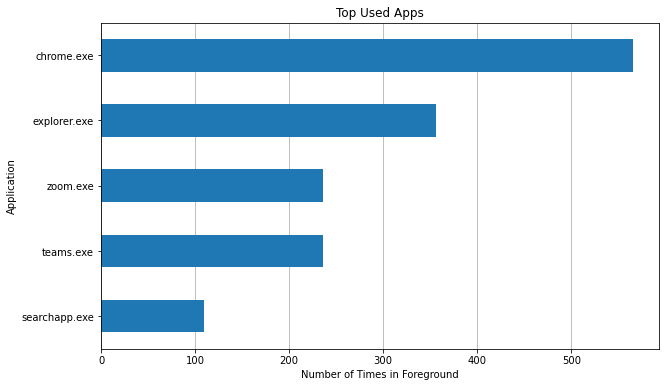

In [112]:
plt.rcParams["figure.figsize"] = (10, 6)
ax = df_string[df_string['ID_INPUT'] == 3]['VALUE'].value_counts()[:5].plot.barh(x = 'index', y = 'VALUE')
ax.set_axisbelow(True)
ax.set_xlabel('Number of Times in Foreground')
ax.set_ylabel('Application')
ax.set_title('Top Used Apps')
ax.invert_yaxis()
plt.grid(axis = 'x')
plt.show()

In [113]:
df_string['VALUE'].value_counts()[-5:]

xboxinstaller.exe          1
accountscontrolhost.exe    1
windowscamera.exe          1
snippingtool.exe           1
peggle.exe                 1
Name: VALUE, dtype: int64

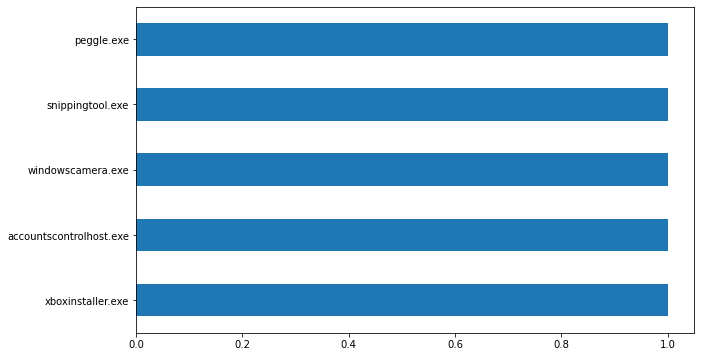

In [114]:
df_string[df_string['ID_INPUT'] == 3]['VALUE'].value_counts()[-5:].plot.barh(x = 'index', y = 'VALUE')
plt.show()

# Probability Matrix

In [3]:
# Only foreground data
df = df_string[df_string['ID_INPUT'] == 3] 

In [4]:
pairCount = defaultdict(int) # dict with pairs being keys
for i in range(df.shape[0]-1):
    pair = (df.iloc[i]['VALUE'], df.iloc[i+1]['VALUE'])
    pairCount[pair] += 1

In [5]:
pairProb = defaultdict(int)
for pair in pairCount:
    b_count = df[df['VALUE'] == pair[0]].shape[0]
    pairProb[pair] = pairCount[pair] / b_count

In [6]:
# Validation
# All Probabilities for each "B" add up to one showing we made the pairs and probabilties correctly
exes = df['VALUE'].unique()
for e in exes:
    pairs = []
    for k in pairProb.keys():
        if k[0] == e:
            pairs.append(k)
    sum_prob = 0
    for p in pairs:
        sum_prob += pairProb[p]
    if sum_prob != 1.0:
        print('Exe: ' + str(e) + '\t\tTotal Probability: ' + str(sum_prob))      

Exe: explorer.exe		Total Probability: 0.9958847736625509
Exe: chrome.exe		Total Probability: 0.9999999999999998
Exe: zoom.exe		Total Probability: 1.0000000000000002
Exe: discord.exe		Total Probability: 0.9999999999999998
Exe: shellexperiencehost.exe		Total Probability: 0.9999999999999999
Exe: microsoft.aad.brokerplugin.exe		Total Probability: 1.0000000000000002
Exe: startmenuexperiencehost.exe		Total Probability: 0.9999999999999999
Exe: db browser for sqlite.exe		Total Probability: 0.9999999999999999
Exe: steam.exe		Total Probability: 1.0000000000000002
Exe: steamwebhelper.exe		Total Probability: 0.9999999999999998
Exe: msedgewebview2.exe		Total Probability: 0.9999999999999999
Exe: eadesktop.exe		Total Probability: 0.9999999999999998
Exe: ts4_x64.exe		Total Probability: 0.9999999999999998


In [15]:
def getPred(numExe, start='s0'):
    pred = [start]
    for action in range(numExe-1):
        prev = pred[-1]
        max_prob = 0
        new_exe = ''
        for k in pairProb.keys():
            if k[0] == prev and pairProb[k] > max_prob:
                new_exe = k[1]
                max_prob = pairProb[k]
        pred.append(new_exe)
    return pred

In [8]:
getPred(7, 's0')

['s0', 'explorer.exe', 'chrome.exe', 'zoom.exe', 'chrome.exe', 'zoom.exe', 'chrome.exe']


In [9]:
getPred(5, 'DB Browser for SQLite.exe')

['DB Browser for SQLite.exe', '', '', '', '']


In [10]:
getPred(4, 'steamwebhelper.exe')

['steamwebhelper.exe', 'steam.exe', 'steamwebhelper.exe', 'steam.exe']


In [17]:
f = open('output.txt', 'w')

for exe in exes:
    prediction = getPred(2, exe)
    string = exe + ', ' + prediction[1] + '\n'
    f.write(string)
    
f.close()

# Probability Matrix

In [24]:
pairProb # currently in a hard to read state

defaultdict(int,
            {('s0', 'explorer.exe'): 0.7428571428571429,
             ('explorer.exe', 'esrv.exe'): 0.07818930041152264,
             ('esrv.exe', 'teams.exe'): 0.0392156862745098,
             ('teams.exe', 'esrv.exe'): 0.007751937984496124,
             ('esrv.exe', 'explorer.exe'): 0.1568627450980392,
             ('teams.exe', 'explorer.exe'): 0.29457364341085274,
             ('esrv.exe', 's0'): 0.5882352941176471,
             ('explorer.exe', 'notepad.exe'): 0.00823045267489712,
             ('notepad.exe', 'explorer.exe'): 0.5,
             ('explorer.exe', 'teams.exe'): 0.12345679012345678,
             ('explorer.exe', 'chrome.exe'): 0.2716049382716049,
             ('chrome.exe', 'mcuicnt.exe'): 0.026785714285714284,
             ('mcuicnt.exe', 'chrome.exe'): 0.28125,
             ('chrome.exe', 'zoom.exe'): 0.27976190476190477,
             ('zoom.exe', 'chrome.exe'): 0.4482758620689655,
             ('zoom.exe', 'discord.exe'): 0.04597701149425287,
      

In [25]:
# # let's see the probability for P(A|B) where B = 's0'
# lst = []
# for i in pairProb:
#     if i[0] == 's0':
#         lst.append([i, pairProb[i]])
# lst

[[('s0', 'explorer.exe'), 0.7428571428571429],
 [('s0', 'esrv.exe'), 0.11428571428571428],
 [('s0', 'teams.exe'), 0.02857142857142857],
 [('s0', 'searchapp.exe'), 0.02857142857142857],
 [('s0', 'msedgewebview2.exe'), 0.02857142857142857],
 [('s0', 'microsoft.aad.brokerplugin.exe'), 0.02857142857142857],
 [('s0', 'discord.exe'), 0.02857142857142857]]

In [26]:
# all_exe = df['VALUE'].unique() # gather all unique .exe
# prob = [] # vlaues for dataframe

# # i = event B
# for i in all_exe:
#     temp_list = []
#     # j = event A
#     for j in all_exe:
#         exe_set = (i, j) # create a set
        
#         try: # see if the set is in one of the pairings
#             temp_list.append(pairProb[exe_set])
#         except: # if set is not in pairing, then the probability is 0
#             temp_list.append(0)
            
#     prob.append(temp_list)

# prob_matrix = pd.DataFrame(prob, index = all_exe, columns = all_exe)

In [31]:
# prob_matrix

s0  explorer.exe  esrv.exe  \
s0                                 0.000000      0.742857  0.114286   
explorer.exe                       0.008230      0.004115  0.078189   
esrv.exe                           0.588235      0.156863  0.000000   
teams.exe                          0.000000      0.294574  0.007752   
notepad.exe                        0.000000      0.500000  0.000000   
chrome.exe                         0.000000      0.130952  0.026786   
mcuicnt.exe                        0.000000      0.187500  0.062500   
zoom.exe                           0.000000      0.172414  0.005747   
discord.exe                        0.000000      0.082474  0.051546   
shellexperiencehost.exe            0.000000      0.206897  0.000000   
msedge.exe                         0.000000      0.210526  0.000000   
origin.exe                         0.000000      0.400000  0.000000   
microsoft.aad.brokerplugin.exe     0.000000      0.152542  0.118644   
utility.exe                        0.000000      0.250000  0.000000   
vpnui.exe                          0.000000      0.100000  0.000000   
docker desktop.exe                 0.000000      0.500000  0.000000   
searchapp.exe                      0.000000      0.206897  0.034483   
devenv.exe                         0.000000      0.166667  0.000000   
code.exe                           0.000000      1.000000  0.000000   
startmenuexperiencehost.exe        0.285714      0.000000  0.000000   
mintty.exe                         0.000000      0.333333  0.000000   
razer synapse service process.exe  0.000000      0.000000  0.000000   
onedrive.exe                       0.000000      1.000000  0.000000   
lockapp.exe                        0.000000      0.333333  0.000000   
xboxinstaller.exe                  0.000000      0.000000  0.000000   
applicationframehost.exe           0.000000      0.166667  0.000000   
xboxidp.exe                        0.000000      0.000000  0.000000   
xboxpcapp.exe                      0.000000      0.125000  0.000000   
accountscontrolhost.exe            0.000000      0.000000  0.000000   
clustertruck.exe                   0.000000      0.000000  0.000000   
admin app                          0.000000      0.000000  0.000000   
werfault.exe                       0.000000      0.000000  0.000000   
systemsettings.exe                 0.000000      0.166667  0.000000   
mccwinstore-win64-shipping.exe     0.000000      0.333333  0.000000   
rundll32.exe                       0.000000      0.000000  0.000000   
donutcounty.exe                    0.000000      0.000000  0.000000   
alertviewer.exe                    0.000000      0.000000  0.000000   
uihost.exe                         0.000000      0.250000  0.000000   
db browser for sqlite.exe          0.000000      0.842105  0.000000   
time.exe                           0.000000      0.095238  0.000000   
steam.exe                          0.000000      0.038462  0.000000   
steamwebhelper.exe                 0.000000      0.068182  0.022727   
msedgewebview2.exe                 0.000000      0.066667  0.000000   
dbfighterz.exe                     0.000000      0.000000  0.000000   
red-win64-shipping.exe             0.000000      0.000000  0.000000   
eadesktopinstaller.exe             0.000000      0.000000  0.000000   
eadesktop.exe                      0.000000      0.103448  0.000000   
peggle.exe                         0.000000      0.000000  0.000000   
installer.exe                      0.000000      0.000000  0.000000   
ts4_x64.exe                        0.000000      0.142857  0.000000   
taskmgr.exe                        0.000000      0.500000  0.000000   
screenclippinghost.exe             0.000000      0.000000  0.000000   
razer synapse 3.exe                0.000000      0.000000  0.000000   
razer central.exe                  0.000000      0.000000  0.000000   
git-cmd.exe                        0.000000      0.000000  0.000000   

                                   teams.exe  notepad.exe  chrom

In [28]:
# prob_matrix.sum(axis = 1)

s0                                   1.000000
explorer.exe                         0.995885
esrv.exe                             1.000000
teams.exe                            1.000000
notepad.exe                          1.000000
chrome.exe                           1.000000
mcuicnt.exe                          1.000000
zoom.exe                             1.000000
discord.exe                          1.000000
shellexperiencehost.exe              1.000000
msedge.exe                           1.000000
origin.exe                           1.000000
microsoft.aad.brokerplugin.exe       1.000000
utility.exe                          1.000000
vpnui.exe                            1.000000
docker desktop.exe                   1.000000
searchapp.exe                        1.000000
devenv.exe                           1.000000
code.exe                             1.000000
startmenuexperiencehost.exe          1.000000
mintty.exe                           1.000000
razer synapse service process.exe 

# HMM

In [46]:
#!pip install hmmlearn

In [57]:
from hmmlearn import hmm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [48]:
enc = OneHotEncoder()
enc.fit(all_exe.reshape(-1, 1))

OneHotEncoder()

In [49]:
allSets = []

for i in range(df.shape[0]-1):
    pair = (df.iloc[i]['VALUE'], df.iloc[i+1]['VALUE'])
    allSets.append(pair)
    
allSets[:5]

[('s0', 'explorer.exe'),
 ('explorer.exe', 'esrv.exe'),
 ('esrv.exe', 'Teams.exe'),
 ('Teams.exe', 'esrv.exe'),
 ('esrv.exe', 'explorer.exe')]

In [41]:
X = [i[0] for i in allSets]
y = [i[1] for i in allSets]

print(X[:5])
print(y[:5])

['s0', 'explorer.exe', 'esrv.exe', 'Teams.exe', 'esrv.exe']
['explorer.exe', 'esrv.exe', 'Teams.exe', 'esrv.exe', 'explorer.exe']


In [66]:
enc.transform(X.reshape(-1, 1))

AttributeError: 'list' object has no attribute 'reshape'

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [48]:
model = hmm.GaussianHMM()

In [49]:
model.fit(allSets)

C:\Users\andyd\AppData\Local\Programs\Python\Python310\lib\site-packages\hmmlearn\base.py:440: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  X = check_array(X)


ValueError: Unable to convert array of bytes/strings into decimal numbers with dtype='numeric'

# Checking for anomalies

In [200]:
df_string['MEASUREMENT_TIME'].min()

Timestamp('2021-11-30 22:14:50.288285')

In [201]:
df_string['MEASUREMENT_TIME'].max()

Timestamp('2022-01-30 21:54:26.312281')

In [68]:
#df_string[df_string['VALUE'] == 'Steam.exe']

MEASUREMENT_TIME  ID_INPUT      VALUE  PRIVATE_DATA
1540 2021-12-23 06:05:24.216         3  Steam.exe             0

In [69]:
#df_string_cleaned = df_string.replace('Steam.exe', 'steam.exe')
#df_string_cleaned.loc[1540]

MEASUREMENT_TIME    2021-12-23 06:05:24.216000
ID_INPUT                                     3
VALUE                                steam.exe
PRIVATE_DATA                                 0
Name: 1540, dtype: object

# Total Time Column

In [43]:
df_string.head()

MEASUREMENT_TIME  ID_INPUT         VALUE  PRIVATE_DATA
0 2021-11-30 22:14:49.985         3            s0             0
1 2021-11-30 22:14:49.985         3  explorer.exe             0
2 2021-11-30 22:14:51.011         3      esrv.exe             0
3 2021-11-30 22:14:51.522         3     teams.exe             0
4 2021-11-30 22:14:52.551         3      esrv.exe             0

In [44]:
# calculate use time
df_string_cleaned = df_string.copy()
df_string_cleaned['USE_TIME'] = df_string_cleaned['MEASUREMENT_TIME'].diff().dt.total_seconds()

In [45]:
# Set start points to 0 use time and shift the use time up
df_string_cleaned['USE_TIME'] = (df_string_cleaned['VALUE'] != 's0').astype('int64') * df_string_cleaned['USE_TIME']
df_string_cleaned['USE_TIME'] = df_string_cleaned['USE_TIME'].shift(periods=-1)

In [46]:
# clean any remaining null values out
df_string_cleaned['USE_TIME'] = df_string_cleaned['USE_TIME'].fillna(0)

In [47]:
df_string_cleaned.head()

MEASUREMENT_TIME  ID_INPUT         VALUE  PRIVATE_DATA  USE_TIME
0 2021-11-30 22:14:49.985         3            s0             0     0.000
1 2021-11-30 22:14:49.985         3  explorer.exe             0     1.026
2 2021-11-30 22:14:51.011         3      esrv.exe             0     0.511
3 2021-11-30 22:14:51.522         3     teams.exe             0     1.029
4 2021-11-30 22:14:52.551         3      esrv.exe             0     0.589

In [48]:
df_string_cleaned.groupby('VALUE')['USE_TIME'].sum().sort_values(ascending = False)[:20]

VALUE
explorer.exe                      215925.938
chrome.exe                        112139.544
msedgewebview2.exe                 40755.026
zoom.exe                           30848.950
teams.exe                          24718.179
xboxpcapp.exe                      11234.501
red-win64-shipping.exe             10032.482
ts4_x64.exe                         6810.709
eadesktop.exe                       5788.924
donutcounty.exe                     5590.805
discord.exe                         3894.513
clustertruck.exe                    3816.894
mccwinstore-win64-shipping.exe      3793.742
applicationframehost.exe            3551.429
msedge.exe                          3194.750
peggle.exe                          2443.825
steamwebhelper.exe                  1921.315
time.exe                            1276.528
microsoft.aad.brokerplugin.exe       813.784
mintty.exe                           787.767
Name: USE_TIME, dtype: float64

In [49]:
out = df_string_cleaned[df_string_cleaned['VALUE'] == 'explorer.exe']['USE_TIME'].sort_values(ascending=False)[1312]
print ('Huge Outlier at 1312 of ' + str(round(out)) + ' minutes for explorer.exe')

Huge Outlier at 1312 of 213399 minutes for explorer.exe


In [50]:
df_string_cleaned.loc[1310:1315, :]

MEASUREMENT_TIME  ID_INPUT                           VALUE  \
1311 2021-12-10 01:30:32.678         3                              s0   
1312 2021-12-10 01:30:32.678         3                    explorer.exe   
1313 2021-12-12 12:47:11.624         3                     lockapp.exe   
1314 2021-12-12 12:47:26.242         3                    explorer.exe   
1315 2021-12-12 12:47:26.870         3  microsoft.aad.brokerplugin.exe   

      PRIVATE_DATA    USE_TIME  
1311             0       0.000  
1312             0  213398.946  
1313             0      14.618  
1314             0       0.628  
1315             0      18.863

In [51]:
df_string_cleaned.drop(1312, inplace=True)

In [52]:
# msedgewebview2.exe has a huge outlier that needs to be dropped
df_string_cleaned.loc[2000:2010, :]
df_string_cleaned.drop(2009, inplace=True)

In [53]:
use_time = df_string_cleaned.groupby('VALUE')['USE_TIME'].sum().sort_values(ascending = False)
use_time[:5]

VALUE
chrome.exe                112139.544
zoom.exe                   30848.950
teams.exe                  24718.179
xboxpcapp.exe              11234.501
red-win64-shipping.exe     10032.482
Name: USE_TIME, dtype: float64

# Graphs

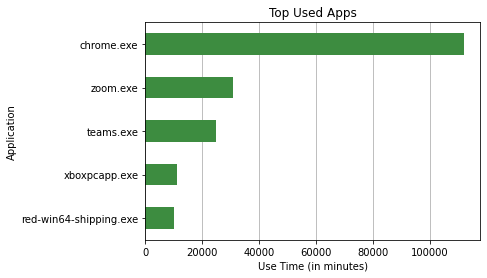

In [54]:
ax = use_time[:5].plot.barh(color = '#3D8C40')
ax.set_axisbelow(True)
ax.set_xlabel('Use Time (in minutes)')
ax.set_ylabel('Application')
ax.set_title('Top Used Apps')
ax.invert_yaxis()
plt.grid(axis = 'x')
plt.show()

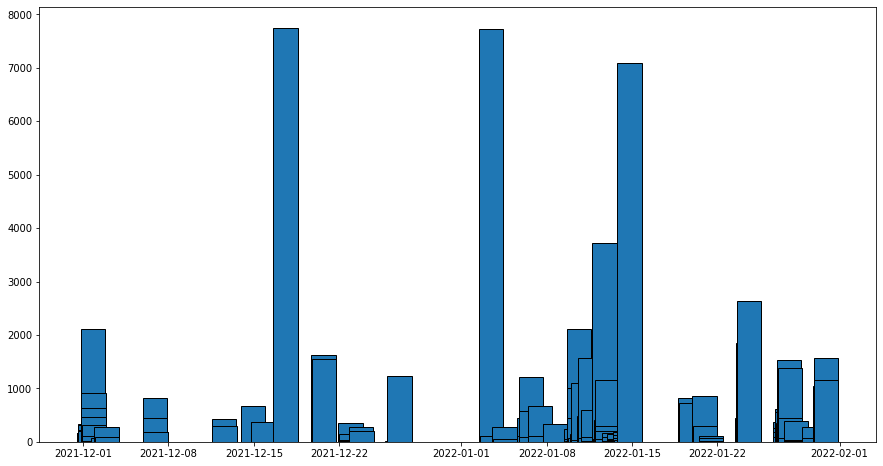

In [55]:
# plan to aggregate for a better plot
chrome = df_string_cleaned[df_string_cleaned['VALUE'] == 'chrome.exe']
x = chrome['MEASUREMENT_TIME']
y = chrome['USE_TIME']


plt.rcParams["figure.figsize"] = (15, 8)
ax = plt.subplot()
ax.bar(x, y, width = 2, edgecolor = 'black')
ax.xaxis_date()

plt.show()

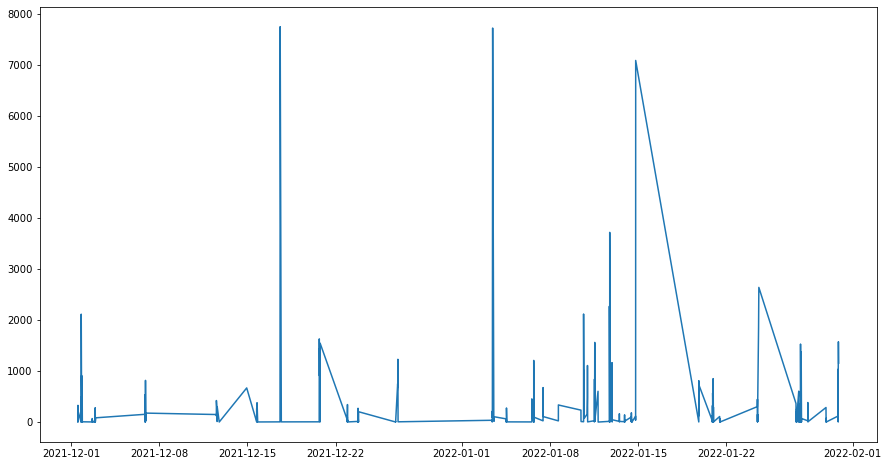

In [230]:
plt.plot(chrome['MEASUREMENT_TIME'], chrome['USE_TIME'])

# RNN

## Data Preparation

In [135]:
chrome = df_string_cleaned[df_string_cleaned['VALUE'] == 'chrome.exe']
chrome = chrome.drop(['ID_INPUT', 'VALUE', 'PRIVATE_DATA'], axis=1)
chrome.head()

MEASUREMENT_TIME  USE_TIME
48 2021-12-01 12:54:25.797   169.566
54 2021-12-01 12:57:16.380     3.160
60 2021-12-01 12:57:21.605   159.664
66 2021-12-01 13:00:31.920    93.454
72 2021-12-01 13:02:12.028    75.076

In [136]:
chrome['END_TIME'] = chrome['MEASUREMENT_TIME'] + pd.to_timedelta(chrome['USE_TIME'], 's')
chrome.head()

MEASUREMENT_TIME  USE_TIME                END_TIME
48 2021-12-01 12:54:25.797   169.566 2021-12-01 12:57:15.363
54 2021-12-01 12:57:16.380     3.160 2021-12-01 12:57:19.540
60 2021-12-01 12:57:21.605   159.664 2021-12-01 13:00:01.269
66 2021-12-01 13:00:31.920    93.454 2021-12-01 13:02:05.374
72 2021-12-01 13:02:12.028    75.076 2021-12-01 13:03:27.104

In [137]:
break_start = pd.to_datetime('2021-12-11 00:00:00')
break_end = pd.to_datetime('2022-01-02 23:59:59')
chrome['ON_BREAK'] = chrome['MEASUREMENT_TIME'].between(break_start, break_end).astype('int64')
chrome.head()

MEASUREMENT_TIME  USE_TIME                END_TIME  ON_BREAK
48 2021-12-01 12:54:25.797   169.566 2021-12-01 12:57:15.363         0
54 2021-12-01 12:57:16.380     3.160 2021-12-01 12:57:19.540         0
60 2021-12-01 12:57:21.605   159.664 2021-12-01 13:00:01.269         0
66 2021-12-01 13:00:31.920    93.454 2021-12-01 13:02:05.374         0
72 2021-12-01 13:02:12.028    75.076 2021-12-01 13:03:27.104         0

In [138]:
first_bin, last_bin = chrome['MEASUREMENT_TIME'].min(), chrome['MEASUREMENT_TIME'].max()
delta = last_bin - first_bin
delta

Timedelta('60 days 08:40:41.866000')

In [139]:
# time delta in hours
(delta.seconds / 3600) + (delta.days * 24)

1448.6780555555556

In [140]:
bins = []
for i in range(1449 + 1):
    hour = first_bin + timedelta(hours=i)
    bins.append(hour)

In [141]:
chrome['MEASUREMENT_TIME'] = pd.cut(chrome['MEASUREMENT_TIME'], bins=bins, right=False)

In [142]:
chrome = chrome.groupby('MEASUREMENT_TIME').sum()
chrome.head()

USE_TIME  ON_BREAK
MEASUREMENT_TIME                                                      
[2021-12-01 12:54:25.797000, 2021-12-01 13:54:2...   1896.17         0
[2021-12-01 13:54:25.797000, 2021-12-01 14:54:2...      0.00         0
[2021-12-01 14:54:25.797000, 2021-12-01 15:54:2...      0.00         0
[2021-12-01 15:54:25.797000, 2021-12-01 16:54:2...      0.00         0
[2021-12-01 16:54:25.797000, 2021-12-01 17:54:2...      0.00         0

In [143]:
chrome = chrome.reset_index()

In [144]:
chrome.head()

MEASUREMENT_TIME  USE_TIME  ON_BREAK
0  [2021-12-01 12:54:25.797000, 2021-12-01 13:54:...   1896.17         0
1  [2021-12-01 13:54:25.797000, 2021-12-01 14:54:...      0.00         0
2  [2021-12-01 14:54:25.797000, 2021-12-01 15:54:...      0.00         0
3  [2021-12-01 15:54:25.797000, 2021-12-01 16:54:...      0.00         0
4  [2021-12-01 16:54:25.797000, 2021-12-01 17:54:...      0.00         0

In [145]:
chrome.iloc[380:390]

MEASUREMENT_TIME  USE_TIME  ON_BREAK
380  [2021-12-17 08:54:25.797000, 2021-12-17 09:54:...     0.000         0
381  [2021-12-17 09:54:25.797000, 2021-12-17 10:54:...     0.000         0
382  [2021-12-17 10:54:25.797000, 2021-12-17 11:54:...     0.000         0
383  [2021-12-17 11:54:25.797000, 2021-12-17 12:54:...     0.000         0
384  [2021-12-17 12:54:25.797000, 2021-12-17 13:54:...   160.361         5
385  [2021-12-17 13:54:25.797000, 2021-12-17 14:54:...  9087.703         4
386  [2021-12-17 14:54:25.797000, 2021-12-17 15:54:...     0.000         0
387  [2021-12-17 15:54:25.797000, 2021-12-17 16:54:...     3.581         1
388  [2021-12-17 16:54:25.797000, 2021-12-17 17:54:...     0.000         0
389  [2021-12-17 17:54:25.797000, 2021-12-17 18:54:...     0.000         0

In [146]:
MAXIMUM_SECONDS = 3600 # 3600 seconds in an hour
use_time = list(chrome['USE_TIME'])

for i in range(len(use_time) - 1):
    row = use_time[i]
    next_row = use_time[i + 1]
    
    if row > MAXIMUM_SECONDS:
        rollover = row - MAXIMUM_SECONDS
        row = MAXIMUM_SECONDS
        next_row += rollover
        use_time[i] = row
        use_time[i + 1] = next_row

In [147]:
chrome['USE_TIME'] = use_time
chrome.iloc[380:390]

MEASUREMENT_TIME  USE_TIME  ON_BREAK
380  [2021-12-17 08:54:25.797000, 2021-12-17 09:54:...     0.000         0
381  [2021-12-17 09:54:25.797000, 2021-12-17 10:54:...     0.000         0
382  [2021-12-17 10:54:25.797000, 2021-12-17 11:54:...     0.000         0
383  [2021-12-17 11:54:25.797000, 2021-12-17 12:54:...     0.000         0
384  [2021-12-17 12:54:25.797000, 2021-12-17 13:54:...   160.361         5
385  [2021-12-17 13:54:25.797000, 2021-12-17 14:54:...  3600.000         4
386  [2021-12-17 14:54:25.797000, 2021-12-17 15:54:...  3600.000         0
387  [2021-12-17 15:54:25.797000, 2021-12-17 16:54:...  1891.284         1
388  [2021-12-17 16:54:25.797000, 2021-12-17 17:54:...     0.000         0
389  [2021-12-17 17:54:25.797000, 2021-12-17 18:54:...     0.000         0

In [148]:
chrome['MEASUREMENT_TIME'] = range(chrome.shape[0])

In [149]:
chrome['ON_BREAK'] = chrome['ON_BREAK'].apply(lambda x: 1 if x > 0 else 0)

In [150]:
chrome.head()

MEASUREMENT_TIME  USE_TIME  ON_BREAK
0                 0   1896.17         0
1                 1      0.00         0
2                 2      0.00         0
3                 3      0.00         0
4                 4      0.00         0

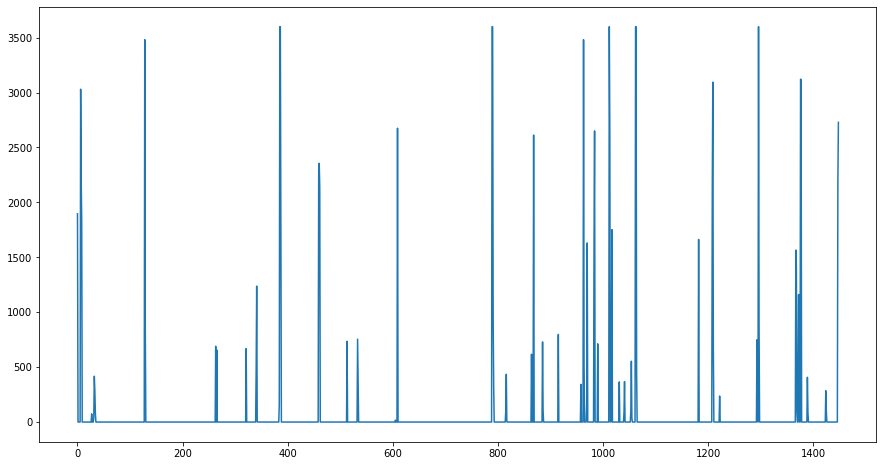

In [151]:
plt.plot(chrome['MEASUREMENT_TIME'], chrome['USE_TIME'])

## LSTM Building

In [152]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math

In [153]:
# normalize the dataset
dataset = np.array(chrome['USE_TIME']).reshape(-1, 1)
# can use other normalization
scaler = MinMaxScaler(feature_range=(0, 1)) # standard deviation x * (max - min) + min
dataset = scaler.fit_transform(dataset)

In [154]:
dataset

array([[0.52671389],
       [0.        ],
       [0.        ],
       ...,
       [0.        ],
       [0.60652583],
       [0.75808278]])

In [155]:
# split into train and test sets, we want it sequential
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

1159 290


# Univariate Time Series

In [28]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [78]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [30]:
trainX[:5]

array([[0.20865229],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ]])

In [31]:
trainY[:5]

array([0., 0., 0., 0., 0.])

In [32]:
testX[:5]

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [33]:
testY[:5]

array([0., 0., 0., 0., 0.])

In [34]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [35]:
trainX[:5]

array([[[0.20865229]],

       [[0.        ]],

       [[0.        ]],

       [[0.        ]],

       [[0.        ]]])

In [36]:
testX[:5]

array([[[0.]],

       [[0.]],

       [[0.]],

       [[0.]],

       [[0.]]])

In [37]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
1157/1157 - 2s - loss: 0.0036 - 2s/epoch - 2ms/step
Epoch 2/100
1157/1157 - 1s - loss: 0.0035 - 816ms/epoch - 705us/step
Epoch 3/100
1157/1157 - 1s - loss: 0.0035 - 840ms/epoch - 726us/step
Epoch 4/100
1157/1157 - 1s - loss: 0.0035 - 858ms/epoch - 741us/step
Epoch 5/100
1157/1157 - 1s - loss: 0.0035 - 884ms/epoch - 764us/step
Epoch 6/100
1157/1157 - 1s - loss: 0.0035 - 905ms/epoch - 782us/step
Epoch 7/100
1157/1157 - 1s - loss: 0.0035 - 885ms/epoch - 765us/step
Epoch 8/100
1157/1157 - 1s - loss: 0.0035 - 909ms/epoch - 786us/step
Epoch 9/100
1157/1157 - 1s - loss: 0.0035 - 912ms/epoch - 788us/step
Epoch 10/100
1157/1157 - 1s - loss: 0.0035 - 928ms/epoch - 802us/step
Epoch 11/100
1157/1157 - 1s - loss: 0.0035 - 888ms/epoch - 767us/step
Epoch 12/100
1157/1157 - 1s - loss: 0.0035 - 860ms/epoch - 743us/step
Epoch 13/100
1157/1157 - 1s - loss: 0.0035 - 909ms/epoch - 785us/step
Epoch 14/100
1157/1157 - 1s - loss: 0.0035 - 902ms/epoch - 779us/step
Epoch 15/100
1157/1157 - 1s - loss

In [38]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 531.09 RMSE
Test Score: 455.73 RMSE


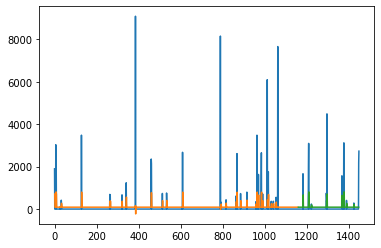

In [39]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [186]:
def basic_LSTM(lookback, num_inputs = 1, epochs = 100, batch_size = 1, verbose = 2, loss = 'mean_squared_error', optimizer = 'adam', density = 1):
    '''
    Creates and returns a basic LSTM model given a series of hyperparameters
    All are defaulted except lookback, which is the number of inputs used to predict the outputs
    
    *** Lookback must be greater than 1
    '''
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)
    
    # reshape input to be [samples, time steps, features]
    trainX = np.reshape(trainX, (trainX.shape[0], num_inputs, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], num_inputs, testX.shape[1]))
    
    # create and fit the LSTM network
    model = Sequential()
    model.add(LSTM(4, input_shape=(num_inputs, look_back)))
    model.add(Dense(density))
    model.compile(loss = loss, optimizer = optimizer, metrics = ['accuracy'])
    model.fit(trainX, trainY, epochs = epochs, batch_size = batch_size, verbose = verbose)
    
    # make predictions
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)
    # invert predictions
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform([trainY])
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform([testY])
    # calculate root mean squared error
    trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
    print('Train Score: %.2f RMSE' % (trainScore))
    testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
    print('Test Score: %.2f RMSE' % (testScore))
    
    # shift train predictions for plotting
    trainPredictPlot = np.empty_like(dataset)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
    # shift test predictions for plotting
    testPredictPlot = np.empty_like(dataset)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
    # plot baseline and predictions
    fig, ax = plt.subplots()
    ax.plot(scaler.inverse_transform(dataset[:, 0].reshape(-1, 1)), label = 'Dataset')
    ax.plot(trainPredictPlot, label = 'Train Prediction')
    ax.plot(testPredictPlot, label = 'Test Prediction')
    ax.legend()
    plt.show()
    
    return model, testPredict, testY

Epoch 1/100
964/964 - 2s - loss: 0.0029 - accuracy: 0.9575 - 2s/epoch - 2ms/step
Epoch 2/100
964/964 - 1s - loss: 0.0029 - accuracy: 0.9575 - 863ms/epoch - 895us/step
Epoch 3/100
964/964 - 1s - loss: 0.0028 - accuracy: 0.9575 - 895ms/epoch - 928us/step
Epoch 4/100
964/964 - 1s - loss: 0.0028 - accuracy: 0.9575 - 752ms/epoch - 780us/step
Epoch 5/100
964/964 - 1s - loss: 0.0028 - accuracy: 0.9575 - 903ms/epoch - 936us/step
Epoch 6/100
964/964 - 1s - loss: 0.0028 - accuracy: 0.9575 - 930ms/epoch - 965us/step
Epoch 7/100
964/964 - 1s - loss: 0.0028 - accuracy: 0.9575 - 801ms/epoch - 831us/step
Epoch 8/100
964/964 - 1s - loss: 0.0028 - accuracy: 0.9575 - 787ms/epoch - 816us/step
Epoch 9/100
964/964 - 1s - loss: 0.0028 - accuracy: 0.9575 - 752ms/epoch - 780us/step
Epoch 10/100
964/964 - 1s - loss: 0.0028 - accuracy: 0.9575 - 775ms/epoch - 803us/step
Epoch 11/100
964/964 - 1s - loss: 0.0028 - accuracy: 0.9575 - 749ms/epoch - 777us/step
Epoch 12/100
964/964 - 1s - loss: 0.0028 - accuracy: 0.95

Epoch 96/100
964/964 - 1s - loss: 0.0027 - accuracy: 0.9575 - 841ms/epoch - 873us/step
Epoch 97/100
964/964 - 1s - loss: 0.0027 - accuracy: 0.9575 - 827ms/epoch - 857us/step
Epoch 98/100
964/964 - 1s - loss: 0.0027 - accuracy: 0.9575 - 818ms/epoch - 849us/step
Epoch 99/100
964/964 - 1s - loss: 0.0027 - accuracy: 0.9575 - 830ms/epoch - 861us/step
Epoch 100/100
964/964 - 1s - loss: 0.0027 - accuracy: 0.9575 - 820ms/epoch - 851us/step
Train Score: 469.09 RMSE
Test Score: 606.88 RMSE


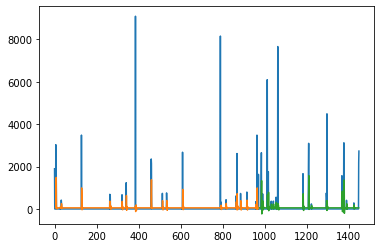

In [113]:
basic_LSTM(10)

Epoch 1/100
964/964 - 2s - loss: 0.0029 - 2s/epoch - 2ms/step
Epoch 2/100
964/964 - 1s - loss: 0.0029 - 838ms/epoch - 869us/step
Epoch 3/100
964/964 - 1s - loss: 0.0028 - 887ms/epoch - 920us/step
Epoch 4/100
964/964 - 1s - loss: 0.0028 - 840ms/epoch - 871us/step
Epoch 5/100
964/964 - 1s - loss: 0.0028 - 756ms/epoch - 784us/step
Epoch 6/100
964/964 - 1s - loss: 0.0028 - 755ms/epoch - 783us/step
Epoch 7/100
964/964 - 1s - loss: 0.0028 - 728ms/epoch - 755us/step
Epoch 8/100
964/964 - 1s - loss: 0.0028 - 783ms/epoch - 812us/step
Epoch 9/100
964/964 - 1s - loss: 0.0028 - 941ms/epoch - 976us/step
Epoch 10/100
964/964 - 1s - loss: 0.0028 - 985ms/epoch - 1ms/step
Epoch 11/100
964/964 - 1s - loss: 0.0028 - 743ms/epoch - 771us/step
Epoch 12/100
964/964 - 1s - loss: 0.0028 - 797ms/epoch - 827us/step
Epoch 13/100
964/964 - 1s - loss: 0.0028 - 992ms/epoch - 1ms/step
Epoch 14/100
964/964 - 1s - loss: 0.0028 - 780ms/epoch - 809us/step
Epoch 15/100
964/964 - 1s - loss: 0.0028 - 754ms/epoch - 782us/ste

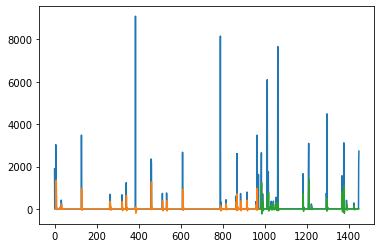

In [110]:
basic_LSTM(3)

Epoch 1/100
964/964 - 2s - loss: 0.0030 - 2s/epoch - 2ms/step
Epoch 2/100
964/964 - 1s - loss: 0.0029 - 814ms/epoch - 844us/step
Epoch 3/100
964/964 - 1s - loss: 0.0029 - 764ms/epoch - 793us/step
Epoch 4/100
964/964 - 1s - loss: 0.0028 - 766ms/epoch - 795us/step
Epoch 5/100
964/964 - 1s - loss: 0.0028 - 752ms/epoch - 780us/step
Epoch 6/100
964/964 - 1s - loss: 0.0028 - 760ms/epoch - 788us/step
Epoch 7/100
964/964 - 1s - loss: 0.0028 - 752ms/epoch - 780us/step
Epoch 8/100
964/964 - 1s - loss: 0.0028 - 754ms/epoch - 782us/step
Epoch 9/100
964/964 - 1s - loss: 0.0028 - 751ms/epoch - 779us/step
Epoch 10/100
964/964 - 1s - loss: 0.0028 - 742ms/epoch - 770us/step
Epoch 11/100
964/964 - 1s - loss: 0.0028 - 802ms/epoch - 832us/step
Epoch 12/100
964/964 - 1s - loss: 0.0028 - 753ms/epoch - 781us/step
Epoch 13/100
964/964 - 1s - loss: 0.0028 - 759ms/epoch - 787us/step
Epoch 14/100
964/964 - 1s - loss: 0.0028 - 751ms/epoch - 779us/step
Epoch 15/100
964/964 - 1s - loss: 0.0028 - 761ms/epoch - 790us

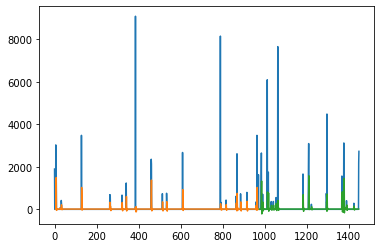

In [111]:
basic_LSTM(4)

In [76]:
def LSTM_elbow(lookback, epochs = 100, batch_size = 1, verbose = 2, loss = 'mean_squared_error', optimizer = 'adam', density = 1):
    '''
    Used to find the elbow for this LSTM model
    '''
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)
    
    # reshape input to be [samples, time steps, features]
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    
    # create and fit the LSTM network
    model = Sequential()
    model.add(LSTM(4, input_shape=(1, look_back)))
    model.add(Dense(density))
    model.compile(loss = loss, optimizer = optimizer, metrics = ['accuracy'])
    model.fit(trainX, trainY, epochs = epochs, batch_size = batch_size, verbose = verbose)
    
    # make predictions
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)
    # invert predictions
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform([trainY])
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform([testY])
    # calculate root mean squared error
    trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
    testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
    return trainScore, testScore

In [56]:
RMSE_train = []
RMSE_test = []

for i in range(10):
    trainScore, testScore = LSTM_elbow(i)
    RMSE_train.append(trainScore)
    RMSE_test.append(testScore)

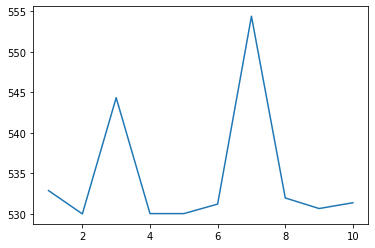

In [115]:
plt.plot(range(1, 11), RMSE_train)

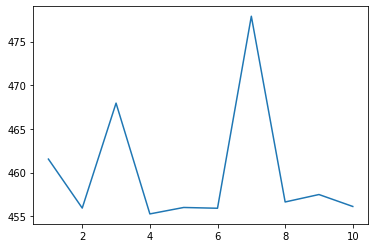

In [114]:
plt.plot(range(1, 11), RMSE_test)

# Multivariate Time Series

In [187]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
chrome['SCALED_USE_TIME'] = scaler.fit_transform(np.array(chrome['USE_TIME']).reshape(-1, 1))
dataset = np.array(chrome.loc[:, ['SCALED_USE_TIME', 'ON_BREAK']])

In [188]:
# split into train and test sets, we want it sequential
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

1159 290


In [189]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

Epoch 1/200
1157/1157 - 2s - loss: 0.0037 - accuracy: 0.9499 - 2s/epoch - 2ms/step
Epoch 2/200
1157/1157 - 1s - loss: 0.0035 - accuracy: 0.9499 - 1s/epoch - 985us/step
Epoch 3/200
1157/1157 - 1s - loss: 0.0035 - accuracy: 0.9499 - 1s/epoch - 959us/step
Epoch 4/200
1157/1157 - 1s - loss: 0.0035 - accuracy: 0.9499 - 1s/epoch - 985us/step
Epoch 5/200
1157/1157 - 1s - loss: 0.0035 - accuracy: 0.9499 - 1s/epoch - 999us/step
Epoch 6/200
1157/1157 - 1s - loss: 0.0035 - accuracy: 0.9499 - 1s/epoch - 965us/step
Epoch 7/200
1157/1157 - 1s - loss: 0.0035 - accuracy: 0.9499 - 1s/epoch - 997us/step
Epoch 8/200
1157/1157 - 1s - loss: 0.0035 - accuracy: 0.9499 - 1s/epoch - 958us/step
Epoch 9/200
1157/1157 - 1s - loss: 0.0035 - accuracy: 0.9499 - 1s/epoch - 931us/step
Epoch 10/200
1157/1157 - 1s - loss: 0.0035 - accuracy: 0.9499 - 1s/epoch - 938us/step
Epoch 11/200
1157/1157 - 1s - loss: 0.0035 - accuracy: 0.9499 - 1s/epoch - 953us/step
Epoch 12/200
1157/1157 - 1s - loss: 0.0034 - accuracy: 0.9499 - 1

Epoch 98/200
1157/1157 - 1s - loss: 0.0034 - accuracy: 0.9499 - 1s/epoch - 1ms/step
Epoch 99/200
1157/1157 - 1s - loss: 0.0034 - accuracy: 0.9499 - 1s/epoch - 1ms/step
Epoch 100/200
1157/1157 - 1s - loss: 0.0034 - accuracy: 0.9499 - 1s/epoch - 1ms/step
Epoch 101/200
1157/1157 - 1s - loss: 0.0034 - accuracy: 0.9499 - 1s/epoch - 967us/step
Epoch 102/200
1157/1157 - 1s - loss: 0.0034 - accuracy: 0.9499 - 1s/epoch - 1ms/step
Epoch 103/200
1157/1157 - 1s - loss: 0.0034 - accuracy: 0.9499 - 1s/epoch - 1ms/step
Epoch 104/200
1157/1157 - 1s - loss: 0.0034 - accuracy: 0.9499 - 1s/epoch - 991us/step
Epoch 105/200
1157/1157 - 1s - loss: 0.0034 - accuracy: 0.9499 - 1s/epoch - 1ms/step
Epoch 106/200
1157/1157 - 1s - loss: 0.0034 - accuracy: 0.9499 - 1s/epoch - 1ms/step
Epoch 107/200
1157/1157 - 1s - loss: 0.0034 - accuracy: 0.9499 - 1s/epoch - 995us/step
Epoch 108/200
1157/1157 - 1s - loss: 0.0034 - accuracy: 0.9499 - 1s/epoch - 1ms/step
Epoch 109/200
1157/1157 - 1s - loss: 0.0034 - accuracy: 0.949

Epoch 194/200
1157/1157 - 1s - loss: 0.0034 - accuracy: 0.9499 - 1s/epoch - 1ms/step
Epoch 195/200
1157/1157 - 1s - loss: 0.0034 - accuracy: 0.9499 - 1s/epoch - 943us/step
Epoch 196/200
1157/1157 - 1s - loss: 0.0034 - accuracy: 0.9499 - 1s/epoch - 967us/step
Epoch 197/200
1157/1157 - 1s - loss: 0.0034 - accuracy: 0.9499 - 1s/epoch - 1ms/step
Epoch 198/200
1157/1157 - 1s - loss: 0.0034 - accuracy: 0.9499 - 1s/epoch - 1ms/step
Epoch 199/200
1157/1157 - 1s - loss: 0.0034 - accuracy: 0.9499 - 1s/epoch - 957us/step
Epoch 200/200
1157/1157 - 1s - loss: 0.0034 - accuracy: 0.9499 - 1s/epoch - 978us/step
Train Score: 524.62 RMSE
Test Score: 459.05 RMSE


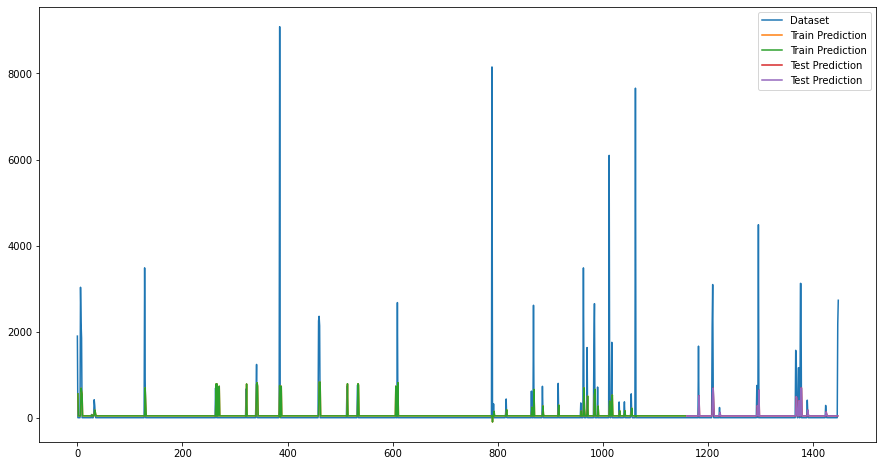

In [79]:
basic_LSTM(lookback = 3, num_inputs = 2, epochs = 200)

In [124]:
print(f'RMSE_train: {min(RMSE_train)}\nRMSE_test: {min(RMSE_test)}')

RMSE_train: 529.9731899503641
RMSE_test: 455.2760351038273


Epoch 1/200
1155/1155 - 2s - loss: 0.0038 - accuracy: 0.9498 - 2s/epoch - 2ms/step
Epoch 2/200
1155/1155 - 1s - loss: 0.0036 - accuracy: 0.9498 - 1s/epoch - 888us/step
Epoch 3/200
1155/1155 - 1s - loss: 0.0035 - accuracy: 0.9498 - 1s/epoch - 886us/step
Epoch 4/200
1155/1155 - 1s - loss: 0.0035 - accuracy: 0.9498 - 1s/epoch - 894us/step
Epoch 5/200
1155/1155 - 1s - loss: 0.0035 - accuracy: 0.9498 - 1s/epoch - 898us/step
Epoch 6/200
1155/1155 - 1s - loss: 0.0035 - accuracy: 0.9498 - 1s/epoch - 978us/step
Epoch 7/200
1155/1155 - 1s - loss: 0.0034 - accuracy: 0.9498 - 1s/epoch - 1ms/step
Epoch 8/200
1155/1155 - 1s - loss: 0.0034 - accuracy: 0.9498 - 1s/epoch - 1ms/step
Epoch 9/200
1155/1155 - 1s - loss: 0.0034 - accuracy: 0.9498 - 1s/epoch - 943us/step
Epoch 10/200
1155/1155 - 1s - loss: 0.0034 - accuracy: 0.9498 - 1s/epoch - 976us/step
Epoch 11/200
1155/1155 - 1s - loss: 0.0034 - accuracy: 0.9498 - 1s/epoch - 991us/step
Epoch 12/200
1155/1155 - 1s - loss: 0.0034 - accuracy: 0.9498 - 1s/ep

Epoch 97/200
1155/1155 - 1s - loss: 0.0033 - accuracy: 0.9498 - 1s/epoch - 875us/step
Epoch 98/200
1155/1155 - 1s - loss: 0.0033 - accuracy: 0.9498 - 1s/epoch - 886us/step
Epoch 99/200
1155/1155 - 1s - loss: 0.0033 - accuracy: 0.9498 - 1s/epoch - 898us/step
Epoch 100/200
1155/1155 - 1s - loss: 0.0033 - accuracy: 0.9498 - 1s/epoch - 879us/step
Epoch 101/200
1155/1155 - 1s - loss: 0.0033 - accuracy: 0.9498 - 1s/epoch - 883us/step
Epoch 102/200
1155/1155 - 1s - loss: 0.0033 - accuracy: 0.9498 - 1s/epoch - 878us/step
Epoch 103/200
1155/1155 - 1s - loss: 0.0033 - accuracy: 0.9498 - 1s/epoch - 871us/step
Epoch 104/200
1155/1155 - 1s - loss: 0.0034 - accuracy: 0.9498 - 1s/epoch - 891us/step
Epoch 105/200
1155/1155 - 1s - loss: 0.0033 - accuracy: 0.9498 - 1s/epoch - 887us/step
Epoch 106/200
1155/1155 - 1s - loss: 0.0033 - accuracy: 0.9498 - 1s/epoch - 883us/step
Epoch 107/200
1155/1155 - 1s - loss: 0.0033 - accuracy: 0.9498 - 1s/epoch - 884us/step
Epoch 108/200
1155/1155 - 1s - loss: 0.0034 - 

Epoch 192/200
1155/1155 - 1s - loss: 0.0033 - accuracy: 0.9498 - 1s/epoch - 890us/step
Epoch 193/200
1155/1155 - 1s - loss: 0.0033 - accuracy: 0.9498 - 1s/epoch - 885us/step
Epoch 194/200
1155/1155 - 1s - loss: 0.0033 - accuracy: 0.9498 - 1s/epoch - 966us/step
Epoch 195/200
1155/1155 - 1s - loss: 0.0033 - accuracy: 0.9498 - 1s/epoch - 985us/step
Epoch 196/200
1155/1155 - 1s - loss: 0.0033 - accuracy: 0.9498 - 1s/epoch - 1ms/step
Epoch 197/200
1155/1155 - 1s - loss: 0.0033 - accuracy: 0.9498 - 1s/epoch - 1ms/step
Epoch 198/200
1155/1155 - 1s - loss: 0.0033 - accuracy: 0.9498 - 1s/epoch - 928us/step
Epoch 199/200
1155/1155 - 1s - loss: 0.0033 - accuracy: 0.9498 - 1s/epoch - 934us/step
Epoch 200/200
1155/1155 - 1s - loss: 0.0033 - accuracy: 0.9498 - 1s/epoch - 885us/step
Train Score: 523.24 RMSE
Test Score: 467.64 RMSE


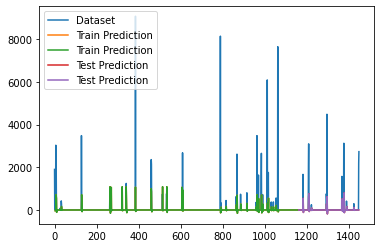

In [125]:
basic_LSTM(lookback = 5, num_inputs = 2, epochs = 200) # lookback = 5, more epochs

Epoch 1/100
1155/1155 - 2s - loss: -3.4632e-02 - accuracy: 0.9498 - 2s/epoch - 2ms/step
Epoch 2/100
1155/1155 - 1s - loss: -3.9827e-02 - accuracy: 0.9498 - 1s/epoch - 973us/step
Epoch 3/100
1155/1155 - 1s - loss: -4.1558e-02 - accuracy: 0.9498 - 1s/epoch - 989us/step
Epoch 4/100
1155/1155 - 1s - loss: -4.3290e-02 - accuracy: 0.9498 - 1s/epoch - 974us/step
Epoch 5/100
1155/1155 - 1s - loss: -4.3290e-02 - accuracy: 0.9498 - 1s/epoch - 1ms/step
Epoch 6/100
1155/1155 - 1s - loss: -4.3290e-02 - accuracy: 0.9498 - 1s/epoch - 901us/step
Epoch 7/100
1155/1155 - 1s - loss: -4.3290e-02 - accuracy: 0.9498 - 1s/epoch - 899us/step
Epoch 8/100
1155/1155 - 1s - loss: -4.3290e-02 - accuracy: 0.9498 - 1s/epoch - 924us/step
Epoch 9/100
1155/1155 - 1s - loss: -4.3290e-02 - accuracy: 0.9498 - 1s/epoch - 907us/step
Epoch 10/100
1155/1155 - 1s - loss: -4.3290e-02 - accuracy: 0.9498 - 1s/epoch - 925us/step
Epoch 11/100
1155/1155 - 1s - loss: -4.3290e-02 - accuracy: 0.9498 - 1s/epoch - 938us/step
Epoch 12/100

Epoch 90/100
1155/1155 - 1s - loss: -5.0216e-02 - accuracy: 8.6580e-04 - 1s/epoch - 934us/step
Epoch 91/100
1155/1155 - 1s - loss: -5.0216e-02 - accuracy: 8.6580e-04 - 1s/epoch - 1ms/step
Epoch 92/100
1155/1155 - 1s - loss: -5.0216e-02 - accuracy: 8.6580e-04 - 1s/epoch - 1ms/step
Epoch 93/100
1155/1155 - 1s - loss: -5.0216e-02 - accuracy: 8.6580e-04 - 1s/epoch - 988us/step
Epoch 94/100
1155/1155 - 1s - loss: -5.0216e-02 - accuracy: 8.6580e-04 - 1s/epoch - 904us/step
Epoch 95/100
1155/1155 - 1s - loss: -5.0216e-02 - accuracy: 8.6580e-04 - 1s/epoch - 977us/step
Epoch 96/100
1155/1155 - 1s - loss: -5.0216e-02 - accuracy: 8.6580e-04 - 1s/epoch - 905us/step
Epoch 97/100
1155/1155 - 1s - loss: -5.0216e-02 - accuracy: 8.6580e-04 - 1s/epoch - 901us/step
Epoch 98/100
1155/1155 - 1s - loss: -5.0216e-02 - accuracy: 8.6580e-04 - 1s/epoch - 902us/step
Epoch 99/100
1155/1155 - 1s - loss: -5.0216e-02 - accuracy: 8.6580e-04 - 1s/epoch - 928us/step
Epoch 100/100
1155/1155 - 1s - loss: -5.0216e-02 - acc

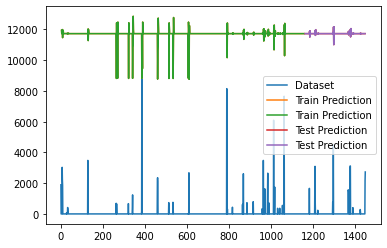

In [126]:
basic_LSTM(lookback = 3, num_inputs = 2, loss = 'cosine_similarity') # cosine similarity

Epoch 1/100
1155/1155 - 2s - loss: 0.0093 - accuracy: 0.9498 - 2s/epoch - 2ms/step
Epoch 2/100
1155/1155 - 1s - loss: 0.0082 - accuracy: 0.9498 - 1s/epoch - 935us/step
Epoch 3/100
1155/1155 - 1s - loss: 0.0081 - accuracy: 0.9498 - 1s/epoch - 893us/step
Epoch 4/100
1155/1155 - 1s - loss: 0.0080 - accuracy: 0.9498 - 1s/epoch - 897us/step
Epoch 5/100
1155/1155 - 1s - loss: 0.0080 - accuracy: 0.9498 - 1s/epoch - 894us/step
Epoch 6/100
1155/1155 - 1s - loss: 0.0079 - accuracy: 0.9498 - 1s/epoch - 887us/step
Epoch 7/100
1155/1155 - 1s - loss: 0.0080 - accuracy: 0.9498 - 1s/epoch - 887us/step
Epoch 8/100
1155/1155 - 1s - loss: 0.0079 - accuracy: 0.9498 - 1s/epoch - 934us/step
Epoch 9/100
1155/1155 - 1s - loss: 0.0079 - accuracy: 0.9498 - 1s/epoch - 984us/step
Epoch 10/100
1155/1155 - 1s - loss: 0.0079 - accuracy: 0.9498 - 1s/epoch - 894us/step
Epoch 11/100
1155/1155 - 1s - loss: 0.0079 - accuracy: 0.9498 - 1s/epoch - 886us/step
Epoch 12/100
1155/1155 - 1s - loss: 0.0078 - accuracy: 0.9498 - 1

Epoch 97/100
1155/1155 - 1s - loss: 0.0077 - accuracy: 0.9498 - 1s/epoch - 887us/step
Epoch 98/100
1155/1155 - 1s - loss: 0.0077 - accuracy: 0.9498 - 1s/epoch - 992us/step
Epoch 99/100
1155/1155 - 1s - loss: 0.0077 - accuracy: 0.9498 - 1s/epoch - 957us/step
Epoch 100/100
1155/1155 - 1s - loss: 0.0077 - accuracy: 0.9498 - 1s/epoch - 932us/step
Train Score: 543.04 RMSE
Test Score: 494.62 RMSE


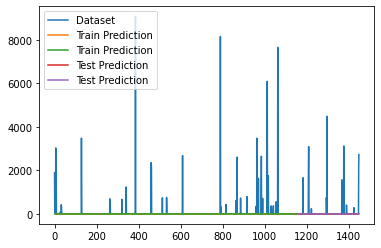

In [127]:
basic_LSTM(lookback = 3, num_inputs = 2, loss = 'mean_absolute_error') # MAE

Epoch 1/100
1155/1155 - 2s - loss: 0.0038 - accuracy: 0.9498 - 2s/epoch - 2ms/step
Epoch 2/100
1155/1155 - 1s - loss: 0.0037 - accuracy: 0.9498 - 1s/epoch - 1ms/step
Epoch 3/100
1155/1155 - 1s - loss: 0.0037 - accuracy: 0.9498 - 1s/epoch - 928us/step
Epoch 4/100
1155/1155 - 1s - loss: 0.0036 - accuracy: 0.9498 - 1s/epoch - 1ms/step
Epoch 5/100
1155/1155 - 1s - loss: 0.0036 - accuracy: 0.9498 - 1s/epoch - 962us/step
Epoch 6/100
1155/1155 - 1s - loss: 0.0036 - accuracy: 0.9498 - 1s/epoch - 900us/step
Epoch 7/100
1155/1155 - 1s - loss: 0.0036 - accuracy: 0.9498 - 1s/epoch - 931us/step
Epoch 8/100
1155/1155 - 1s - loss: 0.0036 - accuracy: 0.9498 - 1s/epoch - 883us/step
Epoch 9/100
1155/1155 - 1s - loss: 0.0036 - accuracy: 0.9498 - 1s/epoch - 884us/step
Epoch 10/100
1155/1155 - 1s - loss: 0.0035 - accuracy: 0.9498 - 1s/epoch - 886us/step
Epoch 11/100
1155/1155 - 1s - loss: 0.0035 - accuracy: 0.9498 - 1s/epoch - 963us/step
Epoch 12/100
1155/1155 - 1s - loss: 0.0035 - accuracy: 0.9498 - 1s/ep

1155/1155 - 1s - loss: 0.0034 - accuracy: 0.9498 - 1s/epoch - 903us/step
Epoch 98/100
1155/1155 - 1s - loss: 0.0034 - accuracy: 0.9498 - 1s/epoch - 988us/step
Epoch 99/100
1155/1155 - 1s - loss: 0.0034 - accuracy: 0.9498 - 1s/epoch - 1ms/step
Epoch 100/100
1155/1155 - 1s - loss: 0.0034 - accuracy: 0.9498 - 1s/epoch - 955us/step
Train Score: 527.75 RMSE
Test Score: 482.14 RMSE


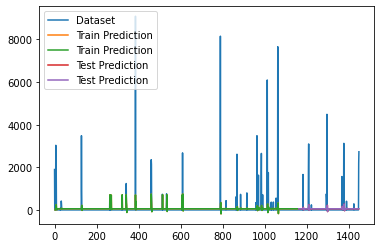

In [129]:
basic_LSTM(lookback = 3, num_inputs = 2, optimizer = 'Adamax') # different optimizer

Epoch 1/100
1157/1157 - 2s - loss: 0.0123 - accuracy: 0.3596 - 2s/epoch - 2ms/step
Epoch 2/100
1157/1157 - 1s - loss: 0.0118 - accuracy: 0.2506 - 1s/epoch - 964us/step
Epoch 3/100
1157/1157 - 1s - loss: 0.0113 - accuracy: 0.3397 - 1s/epoch - 1ms/step
Epoch 4/100
1157/1157 - 1s - loss: 0.0110 - accuracy: 0.3198 - 1s/epoch - 958us/step
Epoch 5/100
1157/1157 - 1s - loss: 0.0109 - accuracy: 0.2861 - 1s/epoch - 945us/step
Epoch 6/100
1157/1157 - 1s - loss: 0.0108 - accuracy: 0.3725 - 1s/epoch - 946us/step
Epoch 7/100
1157/1157 - 1s - loss: 0.0106 - accuracy: 0.3103 - 1s/epoch - 906us/step
Epoch 8/100
1157/1157 - 1s - loss: 0.0107 - accuracy: 0.4313 - 1s/epoch - 900us/step
Epoch 9/100
1157/1157 - 1s - loss: 0.0107 - accuracy: 0.4443 - 1s/epoch - 900us/step
Epoch 10/100
1157/1157 - 1s - loss: 0.0106 - accuracy: 0.3863 - 1s/epoch - 867us/step
Epoch 11/100
1157/1157 - 1s - loss: 0.0106 - accuracy: 0.4036 - 1s/epoch - 941us/step
Epoch 12/100
1157/1157 - 1s - loss: 0.0105 - accuracy: 0.4296 - 1s/

Epoch 97/100
1157/1157 - 1s - loss: 0.0100 - accuracy: 0.4736 - 1s/epoch - 878us/step
Epoch 98/100
1157/1157 - 1s - loss: 0.0101 - accuracy: 0.5687 - 1s/epoch - 889us/step
Epoch 99/100
1157/1157 - 1s - loss: 0.0101 - accuracy: 0.4659 - 1s/epoch - 886us/step
Epoch 100/100
1157/1157 - 1s - loss: 0.0101 - accuracy: 0.4209 - 1s/epoch - 877us/step
Train Score: 361.74 RMSE
Test Score: 430.66 RMSE


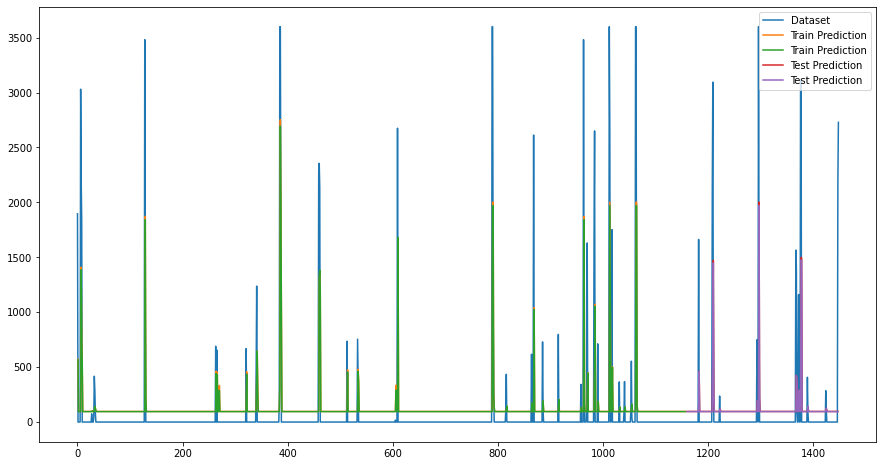

In [192]:
model, testPredict, testY = basic_LSTM(lookback = 3, num_inputs = 2, epochs = 100, density = 2)

In [193]:
testPredict

array([[  96.47624 ,   94.879654],
       [  96.47624 ,   94.879654],
       [  96.47624 ,   94.879654],
       [  96.47624 ,   94.879654],
       [  96.47624 ,   94.879654],
       [  96.47624 ,   94.879654],
       [  96.47624 ,   94.879654],
       [  96.47624 ,   94.879654],
       [  96.47624 ,   94.879654],
       [  96.47624 ,   94.879654],
       [  96.47624 ,   94.879654],
       [  96.47624 ,   94.879654],
       [  96.47624 ,   94.879654],
       [  96.47624 ,   94.879654],
       [  96.47624 ,   94.879654],
       [  96.47624 ,   94.879654],
       [  96.47624 ,   94.879654],
       [  96.47624 ,   94.879654],
       [  96.47624 ,   94.879654],
       [  96.47624 ,   94.879654],
       [  96.47624 ,   94.879654],
       [  96.47624 ,   94.879654],
       [  96.47624 ,   94.879654],
       [ 463.02444 ,  460.0454  ],
       [  96.47624 ,   94.879654],
       [  96.47624 ,   94.879654],
       [  96.47624 ,   94.879654],
       [  96.47624 ,   94.879654],
       [  96.47624 ,

In [194]:
testY

array([[   0.   ,    0.   ,    0.   ,    0.   ,    0.   ,    0.   ,
           0.   ,    0.   ,    0.   ,    0.   ,    0.   ,    0.   ,
           0.   ,    0.   ,    0.   ,    0.   ,    0.   ,    0.   ,
           0.   ,    0.   ,    0.   ,    0.   , 1662.888,    0.   ,
           0.   ,    0.   ,    0.   ,    0.   ,    0.   ,    0.   ,
           0.   ,    0.   ,    0.   ,    0.   ,    0.   ,    0.   ,
           0.   ,    0.   ,    0.   ,    0.   ,    0.   ,    0.   ,
           0.   ,    0.   ,    0.   ,    0.   ,    0.   ,    0.   ,
        2105.827, 3094.763,  681.409,    0.   ,    0.   ,    0.   ,
           0.   ,    0.   ,    0.   ,    0.   ,    0.   ,    0.   ,
           0.   ,    0.   ,  236.599,    0.   ,    0.   ,    0.   ,
           0.   ,    0.   ,    0.   ,    0.   ,    0.   ,    0.   ,
           0.   ,    0.   ,    0.   ,    0.   ,    0.   ,    0.   ,
           0.   ,    0.   ,    0.   ,    0.   ,    0.   ,    0.   ,
           0.   ,    0.   ,    0.   ,    0.   , 

Epoch 1/100
1157/1157 - 2s - loss: 0.0195 - accuracy: 0.4901 - 2s/epoch - 2ms/step
Epoch 2/100
1157/1157 - 1s - loss: 0.0194 - accuracy: 0.5212 - 1s/epoch - 911us/step
Epoch 3/100
1157/1157 - 1s - loss: 0.0194 - accuracy: 0.4572 - 1s/epoch - 922us/step
Epoch 4/100
1157/1157 - 1s - loss: 0.0193 - accuracy: 0.4745 - 1s/epoch - 952us/step
Epoch 5/100
1157/1157 - 1s - loss: 0.0192 - accuracy: 0.5073 - 1s/epoch - 972us/step
Epoch 6/100
1157/1157 - 1s - loss: 0.0193 - accuracy: 0.5013 - 1s/epoch - 900us/step
Epoch 7/100
1157/1157 - 1s - loss: 0.0192 - accuracy: 0.4788 - 1s/epoch - 927us/step
Epoch 8/100
1157/1157 - 1s - loss: 0.0191 - accuracy: 0.4909 - 1s/epoch - 906us/step
Epoch 9/100
1157/1157 - 1s - loss: 0.0192 - accuracy: 0.5039 - 1s/epoch - 928us/step
Epoch 10/100
1157/1157 - 1s - loss: 0.0191 - accuracy: 0.4970 - 1s/epoch - 940us/step
Epoch 11/100
1157/1157 - 1s - loss: 0.0191 - accuracy: 0.5004 - 1s/epoch - 982us/step
Epoch 12/100
1157/1157 - 1s - loss: 0.0191 - accuracy: 0.5056 - 1

Epoch 97/100
1157/1157 - 1s - loss: 0.0179 - accuracy: 0.4641 - 1s/epoch - 903us/step
Epoch 98/100
1157/1157 - 1s - loss: 0.0180 - accuracy: 0.4676 - 1s/epoch - 893us/step
Epoch 99/100
1157/1157 - 1s - loss: 0.0180 - accuracy: 0.4641 - 1s/epoch - 898us/step
Epoch 100/100
1157/1157 - 1s - loss: 0.0180 - accuracy: 0.4693 - 1s/epoch - 916us/step
Train Score: 373.45 RMSE
Test Score: 449.58 RMSE


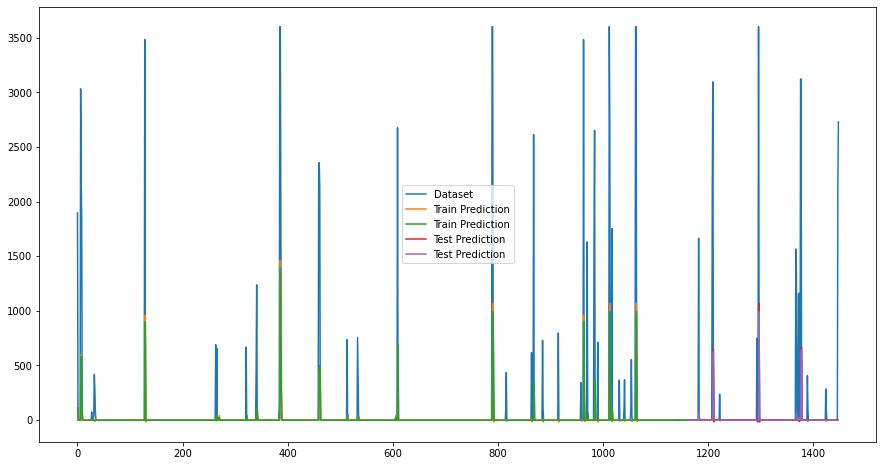

In [195]:
model, testPredict, testY= basic_LSTM(lookback = 3, num_inputs = 2, epochs = 100, density = 2, loss = 'mean_absolute_error')

In [197]:
testPredict

array([[ 6.4216483e-01, -1.0569646e+00],
       [ 6.4216483e-01, -1.0569646e+00],
       [ 6.4216483e-01, -1.0569646e+00],
       [ 6.4216483e-01, -1.0569646e+00],
       [ 6.4216483e-01, -1.0569646e+00],
       [ 6.4216483e-01, -1.0569646e+00],
       [ 6.4216483e-01, -1.0569646e+00],
       [ 6.4216483e-01, -1.0569646e+00],
       [ 6.4216483e-01, -1.0569646e+00],
       [ 6.4216483e-01, -1.0569646e+00],
       [ 6.4216483e-01, -1.0569646e+00],
       [ 6.4216483e-01, -1.0569646e+00],
       [ 6.4216483e-01, -1.0569646e+00],
       [ 6.4216483e-01, -1.0569646e+00],
       [ 6.4216483e-01, -1.0569646e+00],
       [ 6.4216483e-01, -1.0569646e+00],
       [ 6.4216483e-01, -1.0569646e+00],
       [ 6.4216483e-01, -1.0569646e+00],
       [ 6.4216483e-01, -1.0569646e+00],
       [ 6.4216483e-01, -1.0569646e+00],
       [ 6.4216483e-01, -1.0569646e+00],
       [ 6.4216483e-01, -1.0569646e+00],
       [ 6.4216483e-01, -1.0569646e+00],
       [ 3.1799566e+01,  6.9847702e+01],
       [ 6.42164

In [198]:
testY

array([[   0.   ,    0.   ,    0.   ,    0.   ,    0.   ,    0.   ,
           0.   ,    0.   ,    0.   ,    0.   ,    0.   ,    0.   ,
           0.   ,    0.   ,    0.   ,    0.   ,    0.   ,    0.   ,
           0.   ,    0.   ,    0.   ,    0.   , 1662.888,    0.   ,
           0.   ,    0.   ,    0.   ,    0.   ,    0.   ,    0.   ,
           0.   ,    0.   ,    0.   ,    0.   ,    0.   ,    0.   ,
           0.   ,    0.   ,    0.   ,    0.   ,    0.   ,    0.   ,
           0.   ,    0.   ,    0.   ,    0.   ,    0.   ,    0.   ,
        2105.827, 3094.763,  681.409,    0.   ,    0.   ,    0.   ,
           0.   ,    0.   ,    0.   ,    0.   ,    0.   ,    0.   ,
           0.   ,    0.   ,  236.599,    0.   ,    0.   ,    0.   ,
           0.   ,    0.   ,    0.   ,    0.   ,    0.   ,    0.   ,
           0.   ,    0.   ,    0.   ,    0.   ,    0.   ,    0.   ,
           0.   ,    0.   ,    0.   ,    0.   ,    0.   ,    0.   ,
           0.   ,    0.   ,    0.   ,    0.   , 

In [259]:
def calculate_accuracy(prediction, actual, threshold = .1):
    accurate = []
    
    for i in range(len(actual)):
        if actual[i] == 0: # edge case
            left_bound = -threshold
            right_bound = threshold
        else:
            left_bound -= actual[i] * threshold
            right_bound += actual[i] * threshold
        
        if left_bound <= prediction[i] <= right_bound:
            accurate.append(1)
        else:
            accurate.append(0)
            
    return np.mean(accurate)

Epoch 1/100
1157/1157 - 2s - loss: 0.0139 - accuracy: 0.3812 - 2s/epoch - 2ms/step
Epoch 2/100
1157/1157 - 1s - loss: 0.0137 - accuracy: 0.2783 - 995ms/epoch - 860us/step
Epoch 3/100
1157/1157 - 1s - loss: 0.0135 - accuracy: 0.2195 - 985ms/epoch - 851us/step
Epoch 4/100
1157/1157 - 1s - loss: 0.0134 - accuracy: 0.2264 - 981ms/epoch - 848us/step
Epoch 5/100
1157/1157 - 1s - loss: 0.0133 - accuracy: 0.2195 - 983ms/epoch - 850us/step
Epoch 6/100
1157/1157 - 1s - loss: 0.0131 - accuracy: 0.1824 - 981ms/epoch - 848us/step
Epoch 7/100
1157/1157 - 1s - loss: 0.0130 - accuracy: 0.1530 - 1s/epoch - 886us/step
Epoch 8/100
1157/1157 - 1s - loss: 0.0129 - accuracy: 0.1357 - 1s/epoch - 1ms/step
Epoch 9/100
1157/1157 - 1s - loss: 0.0128 - accuracy: 0.1322 - 1s/epoch - 942us/step
Epoch 10/100
1157/1157 - 1s - loss: 0.0127 - accuracy: 0.1089 - 1s/epoch - 869us/step
Epoch 11/100
1157/1157 - 1s - loss: 0.0126 - accuracy: 0.1305 - 987ms/epoch - 853us/step
Epoch 12/100
1157/1157 - 1s - loss: 0.0125 - accu

Epoch 96/100
1157/1157 - 1s - loss: 0.0110 - accuracy: 0.2748 - 1s/epoch - 877us/step
Epoch 97/100
1157/1157 - 1s - loss: 0.0110 - accuracy: 0.3042 - 1s/epoch - 890us/step
Epoch 98/100
1157/1157 - 1s - loss: 0.0110 - accuracy: 0.3284 - 1s/epoch - 1ms/step
Epoch 99/100
1157/1157 - 1s - loss: 0.0110 - accuracy: 0.3863 - 1s/epoch - 1ms/step
Epoch 100/100
1157/1157 - 1s - loss: 0.0110 - accuracy: 0.2602 - 1s/epoch - 869us/step
Train Score: 377.40 RMSE
Test Score: 432.83 RMSE


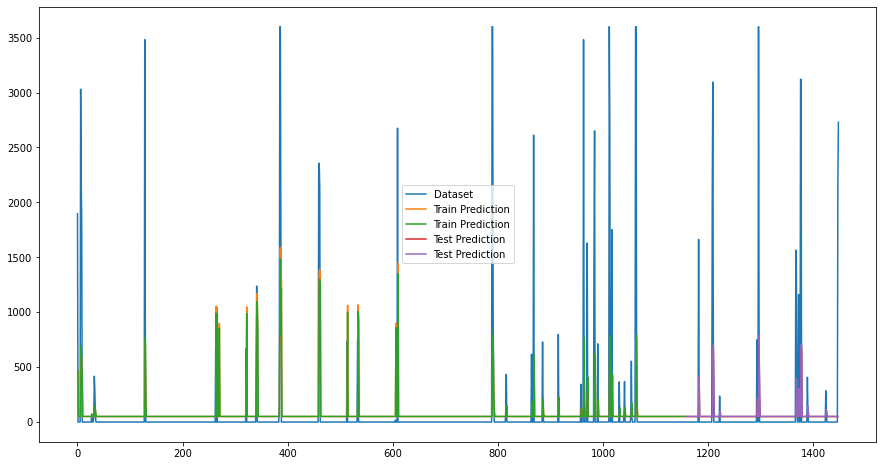

Epoch 1/100
1157/1157 - 2s - loss: 0.0133 - accuracy: 0.5532 - 2s/epoch - 2ms/step
Epoch 2/100
1157/1157 - 1s - loss: 0.0129 - accuracy: 0.4745 - 1s/epoch - 887us/step
Epoch 3/100
1157/1157 - 1s - loss: 0.0128 - accuracy: 0.4676 - 1s/epoch - 898us/step
Epoch 4/100
1157/1157 - 1s - loss: 0.0127 - accuracy: 0.4425 - 1s/epoch - 899us/step
Epoch 5/100
1157/1157 - 1s - loss: 0.0125 - accuracy: 0.4745 - 1s/epoch - 948us/step
Epoch 6/100
1157/1157 - 1s - loss: 0.0123 - accuracy: 0.4952 - 1s/epoch - 1ms/step
Epoch 7/100
1157/1157 - 1s - loss: 0.0123 - accuracy: 0.4373 - 1s/epoch - 1ms/step
Epoch 8/100
1157/1157 - 1s - loss: 0.0121 - accuracy: 0.5203 - 1s/epoch - 1ms/step
Epoch 9/100
1157/1157 - 1s - loss: 0.0120 - accuracy: 0.4771 - 1s/epoch - 972us/step
Epoch 10/100
1157/1157 - 1s - loss: 0.0118 - accuracy: 0.5099 - 1s/epoch - 1ms/step
Epoch 11/100
1157/1157 - 1s - loss: 0.0118 - accuracy: 0.4218 - 1s/epoch - 960us/step
Epoch 12/100
1157/1157 - 1s - loss: 0.0117 - accuracy: 0.4857 - 1s/epoch 

Epoch 97/100
1157/1157 - 1s - loss: 0.0114 - accuracy: 0.4788 - 1s/epoch - 1ms/step
Epoch 98/100
1157/1157 - 1s - loss: 0.0112 - accuracy: 0.3604 - 1s/epoch - 969us/step
Epoch 99/100
1157/1157 - 1s - loss: 0.0111 - accuracy: 0.4546 - 1s/epoch - 902us/step
Epoch 100/100
1157/1157 - 1s - loss: 0.0110 - accuracy: 0.4780 - 1s/epoch - 1ms/step
Train Score: 376.34 RMSE
Test Score: 430.22 RMSE


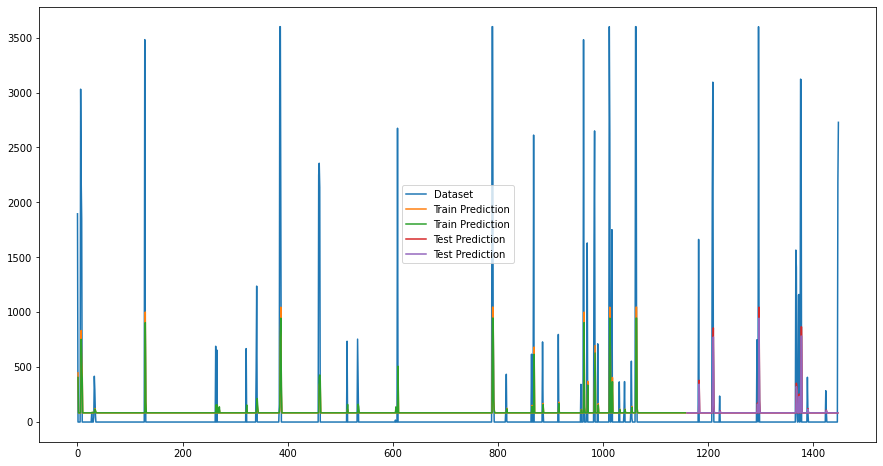

Epoch 1/100
1157/1157 - 2s - loss: 0.0124 - accuracy: 0.8237 - 2s/epoch - 2ms/step
Epoch 2/100
1157/1157 - 1s - loss: 0.0118 - accuracy: 0.7848 - 1s/epoch - 1ms/step
Epoch 3/100
1157/1157 - 1s - loss: 0.0113 - accuracy: 0.7347 - 1s/epoch - 1ms/step
Epoch 4/100
1157/1157 - 1s - loss: 0.0110 - accuracy: 0.6923 - 1s/epoch - 1ms/step
Epoch 5/100
1157/1157 - 1s - loss: 0.0108 - accuracy: 0.6776 - 1s/epoch - 963us/step
Epoch 6/100
1157/1157 - 1s - loss: 0.0108 - accuracy: 0.7139 - 1s/epoch - 868us/step
Epoch 7/100
1157/1157 - 1s - loss: 0.0108 - accuracy: 0.5912 - 1s/epoch - 925us/step
Epoch 8/100
1157/1157 - 1s - loss: 0.0107 - accuracy: 0.5955 - 1s/epoch - 956us/step
Epoch 9/100
1157/1157 - 1s - loss: 0.0107 - accuracy: 0.5946 - 1s/epoch - 1ms/step
Epoch 10/100
1157/1157 - 1s - loss: 0.0108 - accuracy: 0.6508 - 1s/epoch - 950us/step
Epoch 11/100
1157/1157 - 1s - loss: 0.0107 - accuracy: 0.6482 - 1s/epoch - 914us/step
Epoch 12/100
1157/1157 - 1s - loss: 0.0107 - accuracy: 0.6681 - 1s/epoch 

Epoch 97/100
1157/1157 - 1s - loss: 0.0102 - accuracy: 0.5402 - 1s/epoch - 1ms/step
Epoch 98/100
1157/1157 - 1s - loss: 0.0101 - accuracy: 0.6301 - 1s/epoch - 1ms/step
Epoch 99/100
1157/1157 - 1s - loss: 0.0101 - accuracy: 0.5039 - 1s/epoch - 927us/step
Epoch 100/100
1157/1157 - 1s - loss: 0.0101 - accuracy: 0.4105 - 1s/epoch - 911us/step
Train Score: 359.26 RMSE
Test Score: 436.70 RMSE


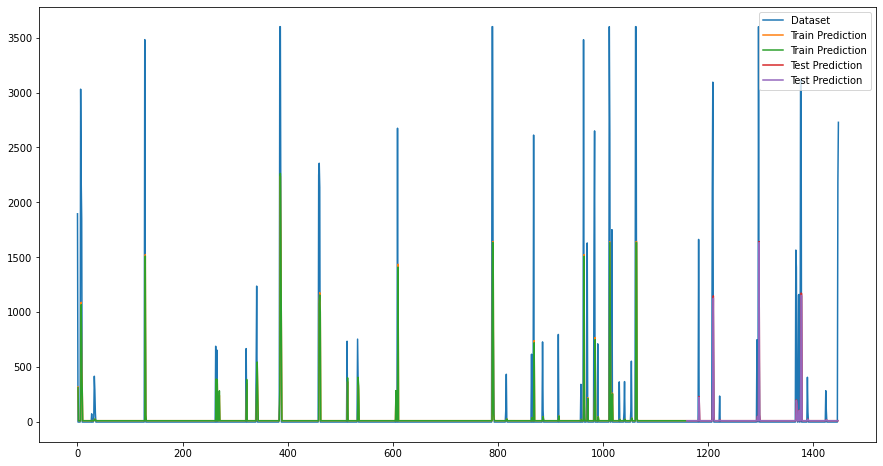

Epoch 1/100
1157/1157 - 2s - loss: 0.0128 - accuracy: 0.4460 - 2s/epoch - 2ms/step
Epoch 2/100
1157/1157 - 1s - loss: 0.0128 - accuracy: 0.0320 - 1s/epoch - 1ms/step
Epoch 3/100
1157/1157 - 1s - loss: 0.0128 - accuracy: 0.0311 - 1s/epoch - 940us/step
Epoch 4/100
1157/1157 - 1s - loss: 0.0128 - accuracy: 0.0311 - 1s/epoch - 925us/step
Epoch 5/100
1157/1157 - 1s - loss: 0.0128 - accuracy: 0.0311 - 1s/epoch - 935us/step
Epoch 6/100
1157/1157 - 1s - loss: 0.0128 - accuracy: 0.0311 - 1s/epoch - 965us/step
Epoch 7/100
1157/1157 - 1s - loss: 0.0128 - accuracy: 0.0311 - 1s/epoch - 987us/step
Epoch 8/100
1157/1157 - 1s - loss: 0.0128 - accuracy: 0.0311 - 1s/epoch - 1ms/step
Epoch 9/100
1157/1157 - 1s - loss: 0.0128 - accuracy: 0.0303 - 1s/epoch - 867us/step
Epoch 10/100
1157/1157 - 1s - loss: 0.0128 - accuracy: 0.0303 - 1s/epoch - 880us/step
Epoch 11/100
1157/1157 - 1s - loss: 0.0128 - accuracy: 0.0303 - 993ms/epoch - 858us/step
Epoch 12/100
1157/1157 - 1s - loss: 0.0128 - accuracy: 0.0303 - 1s

Epoch 95/100
1157/1157 - 1s - loss: 0.0127 - accuracy: 0.0303 - 973ms/epoch - 841us/step
Epoch 96/100
1157/1157 - 1s - loss: 0.0127 - accuracy: 0.0303 - 966ms/epoch - 835us/step
Epoch 97/100
1157/1157 - 1s - loss: 0.0127 - accuracy: 0.0303 - 965ms/epoch - 834us/step
Epoch 98/100
1157/1157 - 1s - loss: 0.0127 - accuracy: 0.0303 - 962ms/epoch - 831us/step
Epoch 99/100
1157/1157 - 1s - loss: 0.0127 - accuracy: 0.0303 - 970ms/epoch - 838us/step
Epoch 100/100
1157/1157 - 1s - loss: 0.0127 - accuracy: 0.0303 - 981ms/epoch - 848us/step
Train Score: 387.76 RMSE
Test Score: 449.39 RMSE


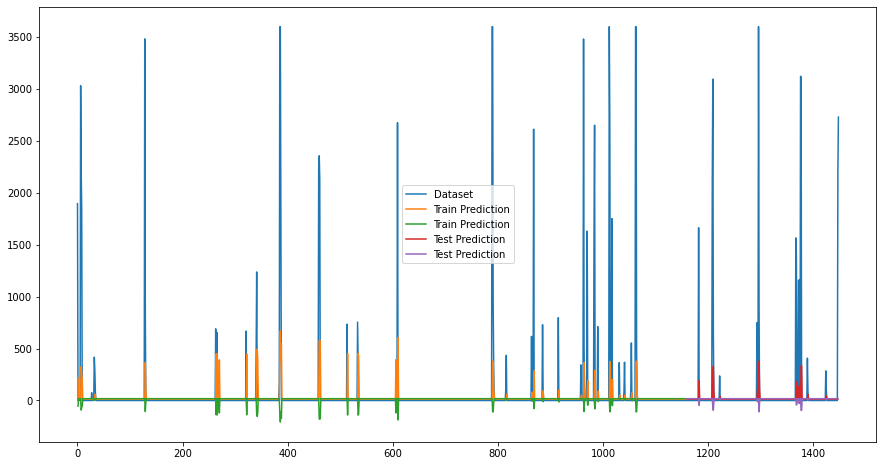

Epoch 1/100
1157/1157 - 2s - loss: 0.0140 - accuracy: 0.9231 - 2s/epoch - 2ms/step
Epoch 2/100
1157/1157 - 1s - loss: 0.0139 - accuracy: 0.9248 - 977ms/epoch - 844us/step
Epoch 3/100
1157/1157 - 1s - loss: 0.0138 - accuracy: 0.9248 - 996ms/epoch - 861us/step
Epoch 4/100
1157/1157 - 1s - loss: 0.0138 - accuracy: 0.9248 - 1s/epoch - 938us/step
Epoch 5/100
1157/1157 - 1s - loss: 0.0138 - accuracy: 0.9248 - 1s/epoch - 971us/step
Epoch 6/100
1157/1157 - 1s - loss: 0.0137 - accuracy: 0.9248 - 1s/epoch - 891us/step
Epoch 7/100
1157/1157 - 1s - loss: 0.0137 - accuracy: 0.9248 - 1s/epoch - 896us/step
Epoch 8/100
1157/1157 - 1s - loss: 0.0137 - accuracy: 0.9248 - 1s/epoch - 969us/step
Epoch 9/100
1157/1157 - 1s - loss: 0.0137 - accuracy: 0.9248 - 1s/epoch - 865us/step
Epoch 10/100
1157/1157 - 1s - loss: 0.0137 - accuracy: 0.9248 - 988ms/epoch - 854us/step
Epoch 11/100
1157/1157 - 1s - loss: 0.0137 - accuracy: 0.9248 - 999ms/epoch - 864us/step
Epoch 12/100
1157/1157 - 1s - loss: 0.0137 - accuracy

Epoch 95/100
1157/1157 - 1s - loss: 0.0133 - accuracy: 0.9248 - 981ms/epoch - 848us/step
Epoch 96/100
1157/1157 - 1s - loss: 0.0132 - accuracy: 0.9248 - 971ms/epoch - 840us/step
Epoch 97/100
1157/1157 - 1s - loss: 0.0132 - accuracy: 0.9248 - 998ms/epoch - 862us/step
Epoch 98/100
1157/1157 - 1s - loss: 0.0132 - accuracy: 0.9248 - 1s/epoch - 957us/step
Epoch 99/100
1157/1157 - 1s - loss: 0.0132 - accuracy: 0.9248 - 1s/epoch - 1ms/step
Epoch 100/100
1157/1157 - 1s - loss: 0.0132 - accuracy: 0.9248 - 969ms/epoch - 838us/step
Train Score: 432.94 RMSE
Test Score: 473.59 RMSE


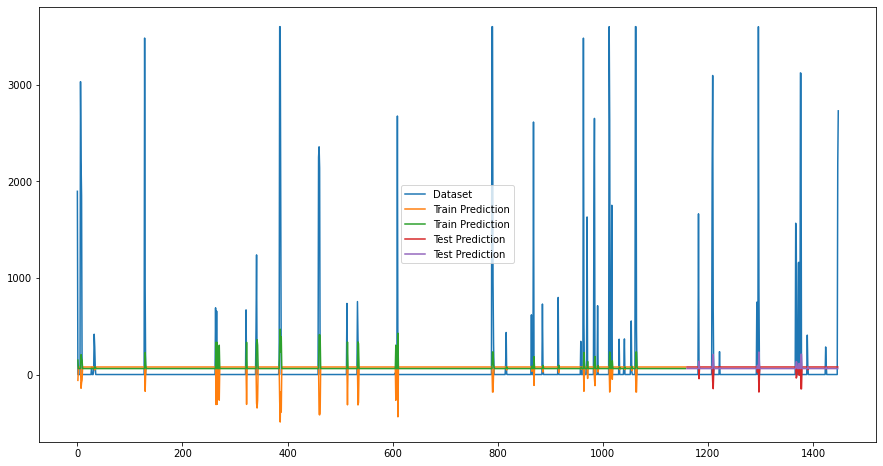

Epoch 1/100
1157/1157 - 2s - loss: 0.0150 - accuracy: 0.0510 - 2s/epoch - 2ms/step
Epoch 2/100
1157/1157 - 1s - loss: 0.0148 - accuracy: 0.0268 - 957ms/epoch - 827us/step
Epoch 3/100
1157/1157 - 1s - loss: 0.0146 - accuracy: 0.0320 - 970ms/epoch - 838us/step
Epoch 4/100
1157/1157 - 1s - loss: 0.0144 - accuracy: 0.0268 - 1s/epoch - 874us/step
Epoch 5/100
1157/1157 - 1s - loss: 0.0142 - accuracy: 0.0268 - 1s/epoch - 866us/step
Epoch 6/100
1157/1157 - 1s - loss: 0.0140 - accuracy: 0.0268 - 1s/epoch - 869us/step
Epoch 7/100
1157/1157 - 1s - loss: 0.0139 - accuracy: 0.0683 - 1s/epoch - 912us/step
Epoch 8/100
1157/1157 - 1s - loss: 0.0137 - accuracy: 0.0259 - 997ms/epoch - 862us/step
Epoch 9/100
1157/1157 - 1s - loss: 0.0136 - accuracy: 0.0259 - 983ms/epoch - 849us/step
Epoch 10/100
1157/1157 - 1s - loss: 0.0135 - accuracy: 0.0372 - 970ms/epoch - 838us/step
Epoch 11/100
1157/1157 - 1s - loss: 0.0133 - accuracy: 0.0268 - 965ms/epoch - 834us/step
Epoch 12/100
1157/1157 - 1s - loss: 0.0132 - ac

Epoch 95/100
1157/1157 - 1s - loss: 0.0104 - accuracy: 0.1271 - 1s/epoch - 875us/step
Epoch 96/100
1157/1157 - 1s - loss: 0.0104 - accuracy: 0.1962 - 963ms/epoch - 832us/step
Epoch 97/100
1157/1157 - 1s - loss: 0.0104 - accuracy: 0.2213 - 1s/epoch - 880us/step
Epoch 98/100
1157/1157 - 1s - loss: 0.0104 - accuracy: 0.2169 - 1s/epoch - 908us/step
Epoch 99/100
1157/1157 - 1s - loss: 0.0104 - accuracy: 0.4313 - 963ms/epoch - 833us/step
Epoch 100/100
1157/1157 - 1s - loss: 0.0104 - accuracy: 0.3284 - 1s/epoch - 907us/step
Train Score: 365.34 RMSE
Test Score: 423.15 RMSE


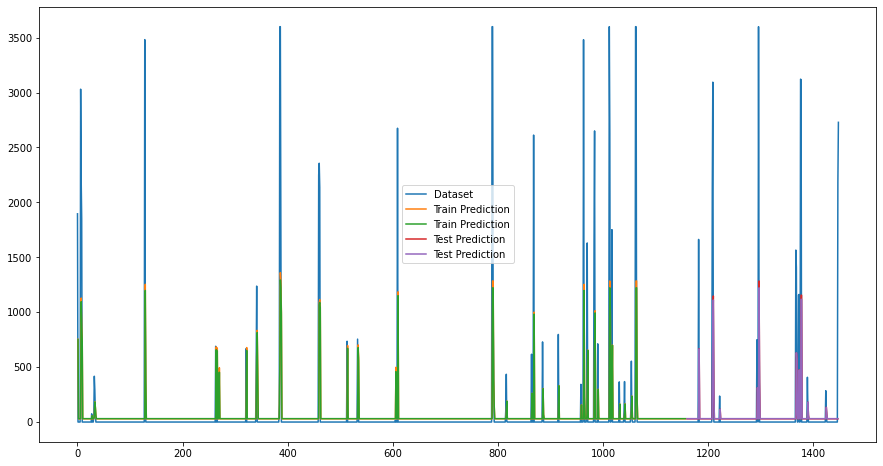

Epoch 1/100
1157/1157 - 2s - loss: 0.0129 - accuracy: 0.0346 - 2s/epoch - 2ms/step
Epoch 2/100
1157/1157 - 1s - loss: 0.0119 - accuracy: 0.0285 - 1s/epoch - 886us/step
Epoch 3/100
1157/1157 - 1s - loss: 0.0114 - accuracy: 0.0346 - 1s/epoch - 964us/step
Epoch 4/100
1157/1157 - 1s - loss: 0.0111 - accuracy: 0.3293 - 1s/epoch - 942us/step
Epoch 5/100
1157/1157 - 1s - loss: 0.0108 - accuracy: 0.2766 - 1s/epoch - 965us/step
Epoch 6/100
1157/1157 - 1s - loss: 0.0108 - accuracy: 0.4105 - 1s/epoch - 910us/step
Epoch 7/100
1157/1157 - 1s - loss: 0.0107 - accuracy: 0.4062 - 1s/epoch - 880us/step
Epoch 8/100
1157/1157 - 1s - loss: 0.0106 - accuracy: 0.4460 - 1s/epoch - 888us/step
Epoch 9/100
1157/1157 - 1s - loss: 0.0106 - accuracy: 0.5212 - 1s/epoch - 890us/step
Epoch 10/100
1157/1157 - 1s - loss: 0.0105 - accuracy: 0.4417 - 1s/epoch - 918us/step
Epoch 11/100
1157/1157 - 1s - loss: 0.0105 - accuracy: 0.4503 - 1s/epoch - 895us/step
Epoch 12/100
1157/1157 - 1s - loss: 0.0105 - accuracy: 0.4434 - 1

Epoch 96/100
1157/1157 - 1s - loss: 0.0101 - accuracy: 0.5497 - 1s/epoch - 877us/step
Epoch 97/100
1157/1157 - 1s - loss: 0.0100 - accuracy: 0.3907 - 999ms/epoch - 863us/step
Epoch 98/100
1157/1157 - 1s - loss: 0.0100 - accuracy: 0.5817 - 1s/epoch - 869us/step
Epoch 99/100
1157/1157 - 1s - loss: 0.0100 - accuracy: 0.5030 - 1s/epoch - 881us/step
Epoch 100/100
1157/1157 - 1s - loss: 0.0100 - accuracy: 0.5592 - 1s/epoch - 864us/step
Train Score: 356.64 RMSE
Test Score: 431.23 RMSE


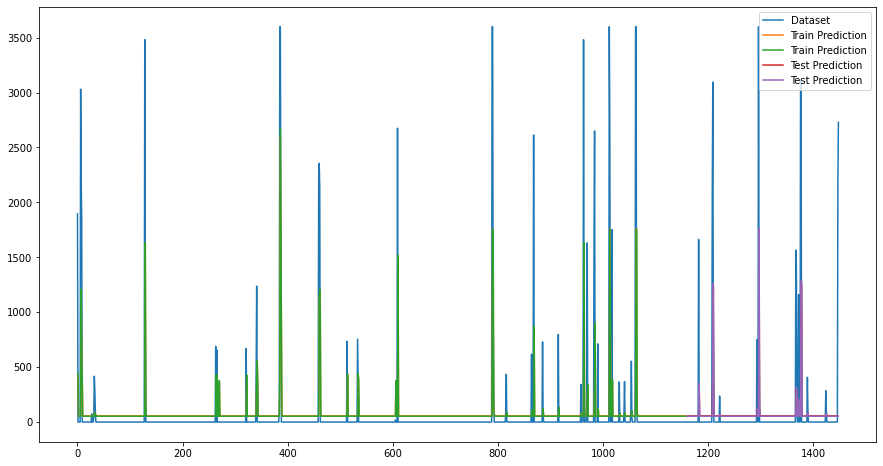

Epoch 1/100
1157/1157 - 2s - loss: 0.0130 - accuracy: 0.9455 - 2s/epoch - 2ms/step
Epoch 2/100
1157/1157 - 1s - loss: 0.0129 - accuracy: 0.9455 - 992ms/epoch - 857us/step
Epoch 3/100
1157/1157 - 1s - loss: 0.0129 - accuracy: 0.9455 - 986ms/epoch - 853us/step
Epoch 4/100
1157/1157 - 1s - loss: 0.0129 - accuracy: 0.9455 - 988ms/epoch - 854us/step
Epoch 5/100
1157/1157 - 1s - loss: 0.0129 - accuracy: 0.9455 - 982ms/epoch - 849us/step
Epoch 6/100
1157/1157 - 1s - loss: 0.0129 - accuracy: 0.9455 - 990ms/epoch - 856us/step
Epoch 7/100
1157/1157 - 1s - loss: 0.0128 - accuracy: 0.9455 - 988ms/epoch - 854us/step
Epoch 8/100
1157/1157 - 1s - loss: 0.0128 - accuracy: 0.9455 - 985ms/epoch - 852us/step
Epoch 9/100
1157/1157 - 1s - loss: 0.0128 - accuracy: 0.9455 - 993ms/epoch - 858us/step
Epoch 10/100
1157/1157 - 1s - loss: 0.0128 - accuracy: 0.9455 - 985ms/epoch - 851us/step
Epoch 11/100
1157/1157 - 1s - loss: 0.0128 - accuracy: 0.9455 - 982ms/epoch - 849us/step
Epoch 12/100
1157/1157 - 1s - loss:

Epoch 94/100
1157/1157 - 1s - loss: 0.0128 - accuracy: 0.9455 - 985ms/epoch - 851us/step
Epoch 95/100
1157/1157 - 1s - loss: 0.0128 - accuracy: 0.9455 - 983ms/epoch - 850us/step
Epoch 96/100
1157/1157 - 1s - loss: 0.0128 - accuracy: 0.9455 - 985ms/epoch - 851us/step
Epoch 97/100
1157/1157 - 1s - loss: 0.0128 - accuracy: 0.9455 - 987ms/epoch - 853us/step
Epoch 98/100
1157/1157 - 1s - loss: 0.0128 - accuracy: 0.9455 - 989ms/epoch - 855us/step
Epoch 99/100
1157/1157 - 1s - loss: 0.0128 - accuracy: 0.9455 - 1000ms/epoch - 864us/step
Epoch 100/100
1157/1157 - 1s - loss: 0.0128 - accuracy: 0.9455 - 986ms/epoch - 853us/step
Train Score: 407.68 RMSE
Test Score: 460.17 RMSE


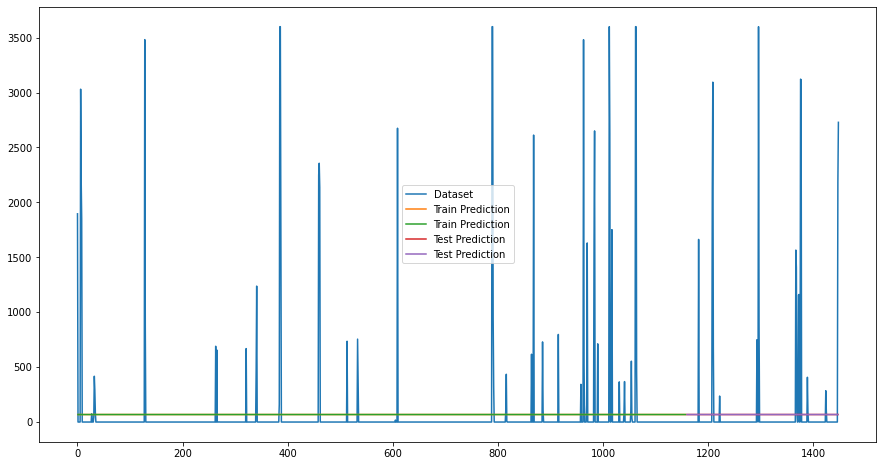

Epoch 1/100
1157/1157 - 2s - loss: 0.0225 - accuracy: 0.2437 - 2s/epoch - 2ms/step
Epoch 2/100
1157/1157 - 1s - loss: 0.0222 - accuracy: 0.6768 - 964ms/epoch - 833us/step
Epoch 3/100
1157/1157 - 1s - loss: 0.0222 - accuracy: 0.8012 - 951ms/epoch - 822us/step
Epoch 4/100
1157/1157 - 1s - loss: 0.0222 - accuracy: 0.9049 - 961ms/epoch - 831us/step
Epoch 5/100
1157/1157 - 1s - loss: 0.0221 - accuracy: 0.7701 - 961ms/epoch - 831us/step
Epoch 6/100
1157/1157 - 1s - loss: 0.0222 - accuracy: 0.8358 - 956ms/epoch - 826us/step
Epoch 7/100
1157/1157 - 1s - loss: 0.0222 - accuracy: 0.8989 - 960ms/epoch - 830us/step
Epoch 8/100
1157/1157 - 1s - loss: 0.0221 - accuracy: 0.8747 - 946ms/epoch - 818us/step
Epoch 9/100
1157/1157 - 1s - loss: 0.0221 - accuracy: 0.9343 - 978ms/epoch - 846us/step
Epoch 10/100
1157/1157 - 1s - loss: 0.0220 - accuracy: 0.7753 - 945ms/epoch - 817us/step
Epoch 11/100
1157/1157 - 1s - loss: 0.0221 - accuracy: 0.9378 - 957ms/epoch - 827us/step
Epoch 12/100
1157/1157 - 1s - loss:

Epoch 94/100
1157/1157 - 1s - loss: 0.0216 - accuracy: 0.4831 - 964ms/epoch - 833us/step
Epoch 95/100
1157/1157 - 1s - loss: 0.0216 - accuracy: 0.4754 - 955ms/epoch - 826us/step
Epoch 96/100
1157/1157 - 1s - loss: 0.0216 - accuracy: 0.4831 - 963ms/epoch - 832us/step
Epoch 97/100
1157/1157 - 1s - loss: 0.0216 - accuracy: 0.4771 - 950ms/epoch - 821us/step
Epoch 98/100
1157/1157 - 1s - loss: 0.0216 - accuracy: 0.4823 - 990ms/epoch - 855us/step
Epoch 99/100
1157/1157 - 1s - loss: 0.0216 - accuracy: 0.4736 - 977ms/epoch - 845us/step
Epoch 100/100
1157/1157 - 1s - loss: 0.0216 - accuracy: 0.4797 - 963ms/epoch - 832us/step
Train Score: 406.56 RMSE
Test Score: 462.20 RMSE


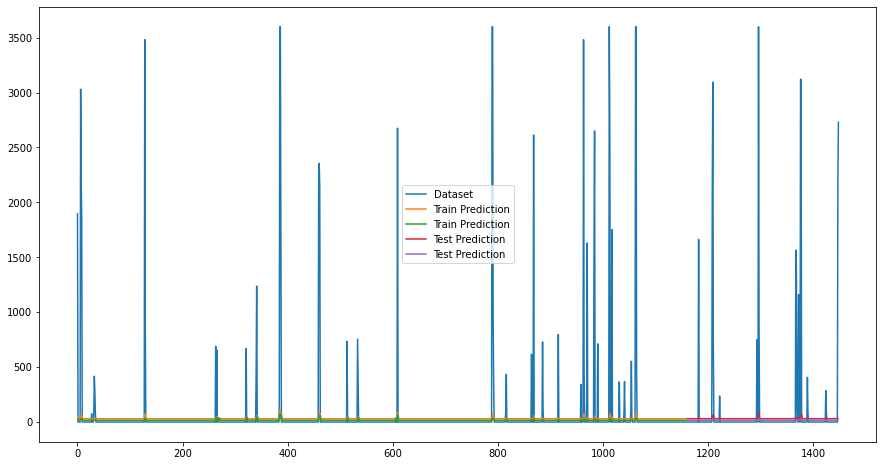

Epoch 1/100
1157/1157 - 2s - loss: 0.0209 - accuracy: 0.2558 - 2s/epoch - 2ms/step
Epoch 2/100
1157/1157 - 1s - loss: 0.0197 - accuracy: 0.3673 - 983ms/epoch - 850us/step
Epoch 3/100
1157/1157 - 1s - loss: 0.0197 - accuracy: 0.1634 - 973ms/epoch - 841us/step
Epoch 4/100
1157/1157 - 1s - loss: 0.0196 - accuracy: 0.1780 - 994ms/epoch - 859us/step
Epoch 5/100
1157/1157 - 1s - loss: 0.0196 - accuracy: 0.0778 - 975ms/epoch - 843us/step
Epoch 6/100
1157/1157 - 1s - loss: 0.0196 - accuracy: 0.0596 - 985ms/epoch - 852us/step
Epoch 7/100
1157/1157 - 1s - loss: 0.0196 - accuracy: 0.1400 - 989ms/epoch - 855us/step
Epoch 8/100
1157/1157 - 1s - loss: 0.0196 - accuracy: 0.1184 - 985ms/epoch - 852us/step
Epoch 9/100
1157/1157 - 1s - loss: 0.0195 - accuracy: 0.0726 - 981ms/epoch - 848us/step
Epoch 10/100
1157/1157 - 1s - loss: 0.0195 - accuracy: 0.2498 - 993ms/epoch - 859us/step
Epoch 11/100
1157/1157 - 1s - loss: 0.0195 - accuracy: 0.4443 - 988ms/epoch - 854us/step
Epoch 12/100
1157/1157 - 1s - loss:

Epoch 94/100
1157/1157 - 1s - loss: 0.0187 - accuracy: 0.1971 - 982ms/epoch - 849us/step
Epoch 95/100
1157/1157 - 1s - loss: 0.0188 - accuracy: 0.1184 - 989ms/epoch - 855us/step
Epoch 96/100
1157/1157 - 1s - loss: 0.0188 - accuracy: 0.0207 - 981ms/epoch - 848us/step
Epoch 97/100
1157/1157 - 1s - loss: 0.0188 - accuracy: 0.0553 - 987ms/epoch - 853us/step
Epoch 98/100
1157/1157 - 1s - loss: 0.0187 - accuracy: 0.0415 - 986ms/epoch - 852us/step
Epoch 99/100
1157/1157 - 1s - loss: 0.0188 - accuracy: 0.1262 - 1s/epoch - 865us/step
Epoch 100/100
1157/1157 - 1s - loss: 0.0187 - accuracy: 0.0424 - 988ms/epoch - 854us/step
Train Score: 386.16 RMSE
Test Score: 447.01 RMSE


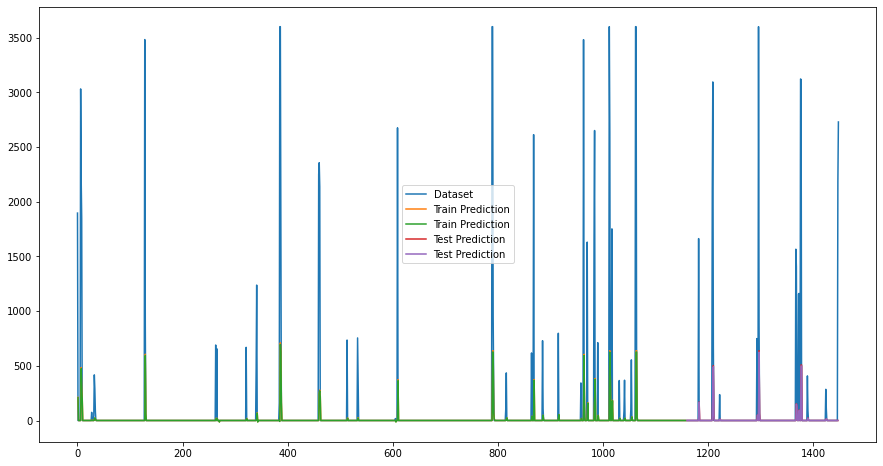

Epoch 1/100
1157/1157 - 2s - loss: 0.0198 - accuracy: 0.4857 - 2s/epoch - 2ms/step
Epoch 2/100
1157/1157 - 1s - loss: 0.0195 - accuracy: 0.4667 - 976ms/epoch - 843us/step
Epoch 3/100
1157/1157 - 1s - loss: 0.0194 - accuracy: 0.4434 - 989ms/epoch - 854us/step
Epoch 4/100
1157/1157 - 1s - loss: 0.0193 - accuracy: 0.4538 - 987ms/epoch - 853us/step
Epoch 5/100
1157/1157 - 1s - loss: 0.0193 - accuracy: 0.4615 - 988ms/epoch - 854us/step
Epoch 6/100
1157/1157 - 1s - loss: 0.0193 - accuracy: 0.4762 - 1s/epoch - 1ms/step
Epoch 7/100
1157/1157 - 1s - loss: 0.0192 - accuracy: 0.4771 - 1s/epoch - 867us/step
Epoch 8/100
1157/1157 - 1s - loss: 0.0192 - accuracy: 0.4745 - 979ms/epoch - 846us/step
Epoch 9/100
1157/1157 - 1s - loss: 0.0191 - accuracy: 0.4659 - 965ms/epoch - 834us/step
Epoch 10/100
1157/1157 - 1s - loss: 0.0190 - accuracy: 0.4399 - 987ms/epoch - 853us/step
Epoch 11/100
1157/1157 - 1s - loss: 0.0189 - accuracy: 0.4555 - 971ms/epoch - 840us/step
Epoch 12/100
1157/1157 - 1s - loss: 0.0189 

Epoch 94/100
1157/1157 - 1s - loss: 0.0180 - accuracy: 0.4633 - 983ms/epoch - 849us/step
Epoch 95/100
1157/1157 - 1s - loss: 0.0180 - accuracy: 0.4494 - 987ms/epoch - 853us/step
Epoch 96/100
1157/1157 - 1s - loss: 0.0178 - accuracy: 0.4633 - 980ms/epoch - 847us/step
Epoch 97/100
1157/1157 - 1s - loss: 0.0180 - accuracy: 0.4676 - 983ms/epoch - 850us/step
Epoch 98/100
1157/1157 - 1s - loss: 0.0180 - accuracy: 0.4685 - 984ms/epoch - 851us/step
Epoch 99/100
1157/1157 - 1s - loss: 0.0180 - accuracy: 0.4710 - 992ms/epoch - 858us/step
Epoch 100/100
1157/1157 - 1s - loss: 0.0179 - accuracy: 0.4806 - 982ms/epoch - 849us/step
Train Score: 376.09 RMSE
Test Score: 449.07 RMSE


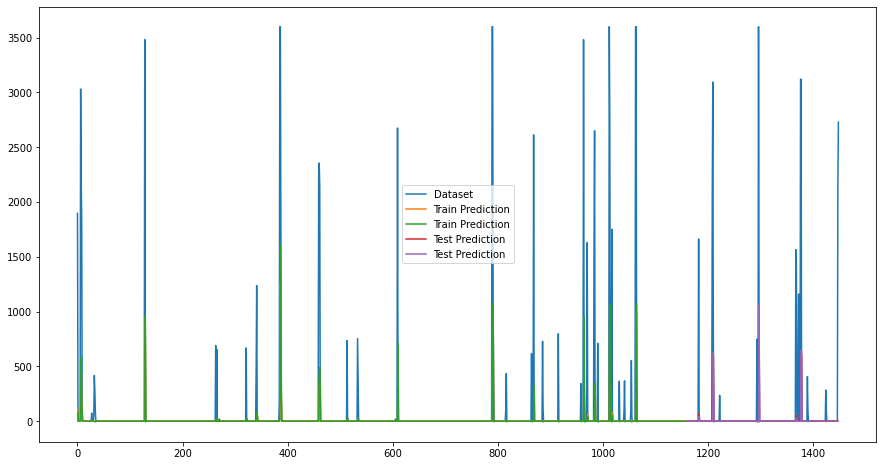

Epoch 1/100
1157/1157 - 2s - loss: 0.0197 - accuracy: 0.4866 - 2s/epoch - 2ms/step
Epoch 2/100
1157/1157 - 1s - loss: 0.0197 - accuracy: 0.4261 - 999ms/epoch - 864us/step
Epoch 3/100
1157/1157 - 1s - loss: 0.0197 - accuracy: 0.5030 - 992ms/epoch - 857us/step
Epoch 4/100
1157/1157 - 1s - loss: 0.0197 - accuracy: 0.5488 - 968ms/epoch - 836us/step
Epoch 5/100
1157/1157 - 1s - loss: 0.0197 - accuracy: 0.1772 - 976ms/epoch - 844us/step
Epoch 6/100
1157/1157 - 1s - loss: 0.0197 - accuracy: 0.7113 - 976ms/epoch - 844us/step
Epoch 7/100
1157/1157 - 1s - loss: 0.0197 - accuracy: 0.2463 - 979ms/epoch - 846us/step
Epoch 8/100
1157/1157 - 1s - loss: 0.0197 - accuracy: 0.5549 - 975ms/epoch - 843us/step
Epoch 9/100
1157/1157 - 1s - loss: 0.0197 - accuracy: 0.6474 - 974ms/epoch - 842us/step
Epoch 10/100
1157/1157 - 1s - loss: 0.0197 - accuracy: 0.0882 - 987ms/epoch - 853us/step
Epoch 11/100
1157/1157 - 1s - loss: 0.0197 - accuracy: 0.8315 - 985ms/epoch - 851us/step
Epoch 12/100
1157/1157 - 1s - loss:

Epoch 94/100
1157/1157 - 1s - loss: 0.0196 - accuracy: 0.1668 - 975ms/epoch - 843us/step
Epoch 95/100
1157/1157 - 1s - loss: 0.0196 - accuracy: 0.0320 - 977ms/epoch - 845us/step
Epoch 96/100
1157/1157 - 1s - loss: 0.0196 - accuracy: 0.4140 - 986ms/epoch - 853us/step
Epoch 97/100
1157/1157 - 1s - loss: 0.0196 - accuracy: 0.8989 - 989ms/epoch - 855us/step
Epoch 98/100
1157/1157 - 1s - loss: 0.0196 - accuracy: 0.9127 - 989ms/epoch - 855us/step
Epoch 99/100
1157/1157 - 1s - loss: 0.0196 - accuracy: 0.3232 - 1s/epoch - 890us/step
Epoch 100/100
1157/1157 - 1s - loss: 0.0196 - accuracy: 0.0320 - 985ms/epoch - 851us/step
Train Score: 404.23 RMSE
Test Score: 464.10 RMSE


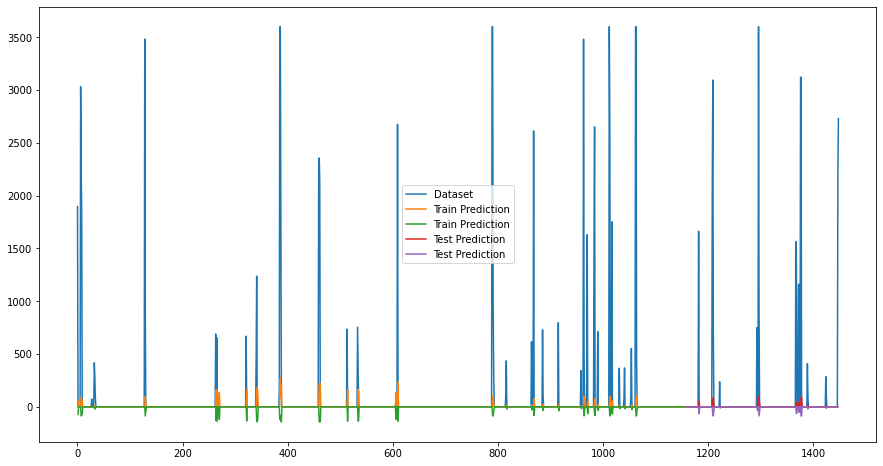

Epoch 1/100
1157/1157 - 2s - loss: 0.0199 - accuracy: 0.4002 - 2s/epoch - 2ms/step
Epoch 2/100
1157/1157 - 1s - loss: 0.0199 - accuracy: 0.3302 - 970ms/epoch - 838us/step
Epoch 3/100
1157/1157 - 1s - loss: 0.0198 - accuracy: 0.5385 - 968ms/epoch - 836us/step
Epoch 4/100
1157/1157 - 1s - loss: 0.0198 - accuracy: 0.3794 - 974ms/epoch - 842us/step
Epoch 5/100
1157/1157 - 1s - loss: 0.0198 - accuracy: 0.5143 - 965ms/epoch - 834us/step
Epoch 6/100
1157/1157 - 1s - loss: 0.0197 - accuracy: 0.6698 - 962ms/epoch - 832us/step
Epoch 7/100
1157/1157 - 1s - loss: 0.0197 - accuracy: 0.3829 - 967ms/epoch - 836us/step
Epoch 8/100
1157/1157 - 1s - loss: 0.0197 - accuracy: 0.5428 - 965ms/epoch - 834us/step
Epoch 9/100
1157/1157 - 1s - loss: 0.0197 - accuracy: 0.5549 - 969ms/epoch - 837us/step
Epoch 10/100
1157/1157 - 1s - loss: 0.0197 - accuracy: 0.4788 - 982ms/epoch - 848us/step
Epoch 11/100
1157/1157 - 1s - loss: 0.0196 - accuracy: 0.5877 - 965ms/epoch - 834us/step
Epoch 12/100
1157/1157 - 1s - loss:

Epoch 94/100
1157/1157 - 1s - loss: 0.0194 - accuracy: 0.6327 - 969ms/epoch - 837us/step
Epoch 95/100
1157/1157 - 1s - loss: 0.0193 - accuracy: 0.4512 - 966ms/epoch - 835us/step
Epoch 96/100
1157/1157 - 1s - loss: 0.0193 - accuracy: 0.8012 - 969ms/epoch - 837us/step
Epoch 97/100
1157/1157 - 1s - loss: 0.0193 - accuracy: 0.4840 - 971ms/epoch - 840us/step
Epoch 98/100
1157/1157 - 1s - loss: 0.0193 - accuracy: 0.6681 - 968ms/epoch - 837us/step
Epoch 99/100
1157/1157 - 1s - loss: 0.0193 - accuracy: 0.4754 - 968ms/epoch - 837us/step
Epoch 100/100
1157/1157 - 1s - loss: 0.0193 - accuracy: 0.4840 - 971ms/epoch - 839us/step
Train Score: 382.40 RMSE
Test Score: 445.59 RMSE


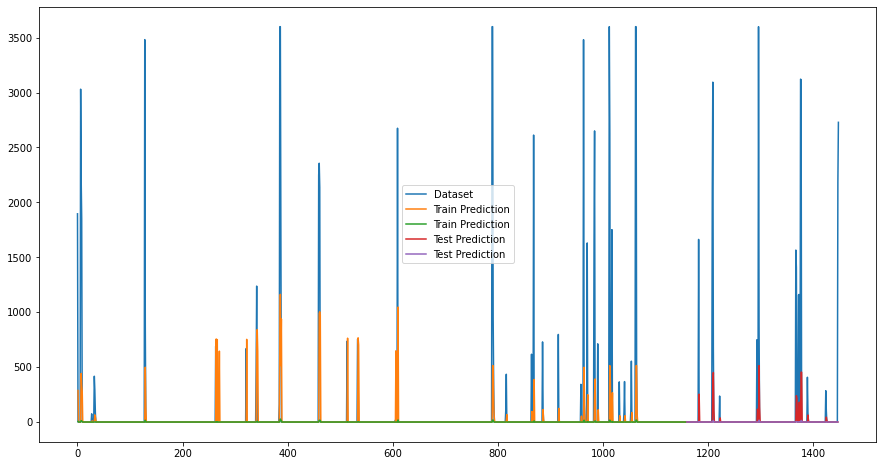

Epoch 1/100
1157/1157 - 2s - loss: 0.0195 - accuracy: 0.4901 - 2s/epoch - 2ms/step
Epoch 2/100
1157/1157 - 1s - loss: 0.0194 - accuracy: 0.4607 - 988ms/epoch - 854us/step
Epoch 3/100
1157/1157 - 1s - loss: 0.0194 - accuracy: 0.4849 - 979ms/epoch - 846us/step
Epoch 4/100
1157/1157 - 1s - loss: 0.0194 - accuracy: 0.4719 - 977ms/epoch - 844us/step
Epoch 5/100
1157/1157 - 1s - loss: 0.0194 - accuracy: 0.4417 - 985ms/epoch - 851us/step
Epoch 6/100
1157/1157 - 1s - loss: 0.0194 - accuracy: 0.4693 - 986ms/epoch - 852us/step
Epoch 7/100
1157/1157 - 1s - loss: 0.0194 - accuracy: 0.4728 - 986ms/epoch - 852us/step
Epoch 8/100
1157/1157 - 1s - loss: 0.0194 - accuracy: 0.4555 - 984ms/epoch - 850us/step
Epoch 9/100
1157/1157 - 1s - loss: 0.0194 - accuracy: 0.4520 - 985ms/epoch - 851us/step
Epoch 10/100
1157/1157 - 1s - loss: 0.0194 - accuracy: 0.4797 - 982ms/epoch - 849us/step
Epoch 11/100
1157/1157 - 1s - loss: 0.0193 - accuracy: 0.4486 - 986ms/epoch - 852us/step
Epoch 12/100
1157/1157 - 1s - loss:

Epoch 94/100
1157/1157 - 1s - loss: 0.0191 - accuracy: 0.4676 - 985ms/epoch - 852us/step
Epoch 95/100
1157/1157 - 1s - loss: 0.0191 - accuracy: 0.4685 - 980ms/epoch - 847us/step
Epoch 96/100
1157/1157 - 1s - loss: 0.0191 - accuracy: 0.4685 - 984ms/epoch - 850us/step
Epoch 97/100
1157/1157 - 1s - loss: 0.0190 - accuracy: 0.4831 - 985ms/epoch - 852us/step
Epoch 98/100
1157/1157 - 1s - loss: 0.0190 - accuracy: 0.4883 - 985ms/epoch - 852us/step
Epoch 99/100
1157/1157 - 1s - loss: 0.0190 - accuracy: 0.4780 - 985ms/epoch - 851us/step
Epoch 100/100
1157/1157 - 1s - loss: 0.0190 - accuracy: 0.5039 - 979ms/epoch - 847us/step
Train Score: 392.88 RMSE
Test Score: 449.50 RMSE


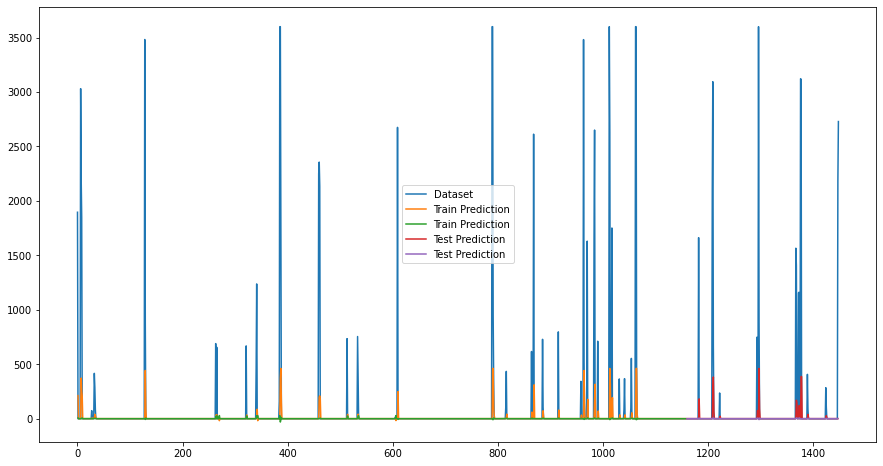

Epoch 1/100
1157/1157 - 2s - loss: 0.0197 - accuracy: 0.3319 - 2s/epoch - 2ms/step
Epoch 2/100
1157/1157 - 1s - loss: 0.0195 - accuracy: 0.4071 - 1s/epoch - 865us/step
Epoch 3/100
1157/1157 - 1s - loss: 0.0194 - accuracy: 0.4339 - 1s/epoch - 866us/step
Epoch 4/100
1157/1157 - 1s - loss: 0.0193 - accuracy: 0.4572 - 1s/epoch - 879us/step
Epoch 5/100
1157/1157 - 1s - loss: 0.0193 - accuracy: 0.4875 - 1s/epoch - 885us/step
Epoch 6/100
1157/1157 - 1s - loss: 0.0192 - accuracy: 0.5376 - 1s/epoch - 868us/step
Epoch 7/100
1157/1157 - 1s - loss: 0.0191 - accuracy: 0.5583 - 1s/epoch - 875us/step
Epoch 8/100
1157/1157 - 1s - loss: 0.0190 - accuracy: 0.5290 - 1s/epoch - 874us/step
Epoch 9/100
1157/1157 - 1s - loss: 0.0190 - accuracy: 0.5765 - 1s/epoch - 877us/step
Epoch 10/100
1157/1157 - 1s - loss: 0.0189 - accuracy: 0.5264 - 1s/epoch - 887us/step
Epoch 11/100
1157/1157 - 1s - loss: 0.0188 - accuracy: 0.5108 - 1s/epoch - 870us/step
Epoch 12/100
1157/1157 - 1s - loss: 0.0188 - accuracy: 0.4045 - 9

Epoch 96/100
1157/1157 - 1s - loss: 0.0179 - accuracy: 0.4831 - 992ms/epoch - 857us/step
Epoch 97/100
1157/1157 - 1s - loss: 0.0178 - accuracy: 0.5177 - 1s/epoch - 867us/step
Epoch 98/100
1157/1157 - 1s - loss: 0.0178 - accuracy: 0.5125 - 1s/epoch - 875us/step
Epoch 99/100
1157/1157 - 1s - loss: 0.0178 - accuracy: 0.3129 - 1s/epoch - 871us/step
Epoch 100/100
1157/1157 - 1s - loss: 0.0178 - accuracy: 0.2939 - 1s/epoch - 879us/step
Train Score: 372.65 RMSE
Test Score: 449.76 RMSE


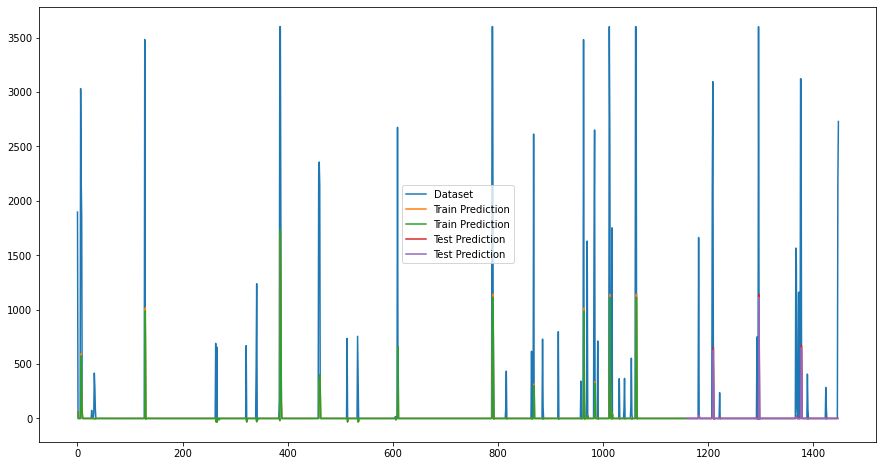

Epoch 1/100
1157/1157 - 2s - loss: 0.0191 - accuracy: 0.9455 - 2s/epoch - 2ms/step
Epoch 2/100
1157/1157 - 1s - loss: 0.0190 - accuracy: 0.9455 - 997ms/epoch - 862us/step
Epoch 3/100
1157/1157 - 1s - loss: 0.0190 - accuracy: 0.9455 - 1s/epoch - 869us/step
Epoch 4/100
1157/1157 - 1s - loss: 0.0190 - accuracy: 0.9455 - 997ms/epoch - 862us/step
Epoch 5/100
1157/1157 - 1s - loss: 0.0190 - accuracy: 0.9455 - 999ms/epoch - 864us/step
Epoch 6/100
1157/1157 - 1s - loss: 0.0190 - accuracy: 0.9455 - 1s/epoch - 868us/step
Epoch 7/100
1157/1157 - 1s - loss: 0.0190 - accuracy: 0.9455 - 1s/epoch - 865us/step
Epoch 8/100
1157/1157 - 1s - loss: 0.0190 - accuracy: 0.9455 - 1s/epoch - 867us/step
Epoch 9/100
1157/1157 - 1s - loss: 0.0190 - accuracy: 0.9455 - 998ms/epoch - 862us/step
Epoch 10/100
1157/1157 - 1s - loss: 0.0190 - accuracy: 0.9455 - 999ms/epoch - 863us/step
Epoch 11/100
1157/1157 - 1s - loss: 0.0190 - accuracy: 0.9455 - 998ms/epoch - 862us/step
Epoch 12/100
1157/1157 - 1s - loss: 0.0190 - ac

Epoch 95/100
1157/1157 - 1s - loss: 0.0190 - accuracy: 0.9455 - 1s/epoch - 867us/step
Epoch 96/100
1157/1157 - 1s - loss: 0.0190 - accuracy: 0.9455 - 997ms/epoch - 862us/step
Epoch 97/100
1157/1157 - 1s - loss: 0.0190 - accuracy: 0.9455 - 998ms/epoch - 862us/step
Epoch 98/100
1157/1157 - 1s - loss: 0.0190 - accuracy: 0.9455 - 994ms/epoch - 859us/step
Epoch 99/100
1157/1157 - 1s - loss: 0.0190 - accuracy: 0.9455 - 1s/epoch - 868us/step
Epoch 100/100
1157/1157 - 1s - loss: 0.0190 - accuracy: 0.9455 - 995ms/epoch - 860us/step
Train Score: 413.40 RMSE
Test Score: 469.56 RMSE


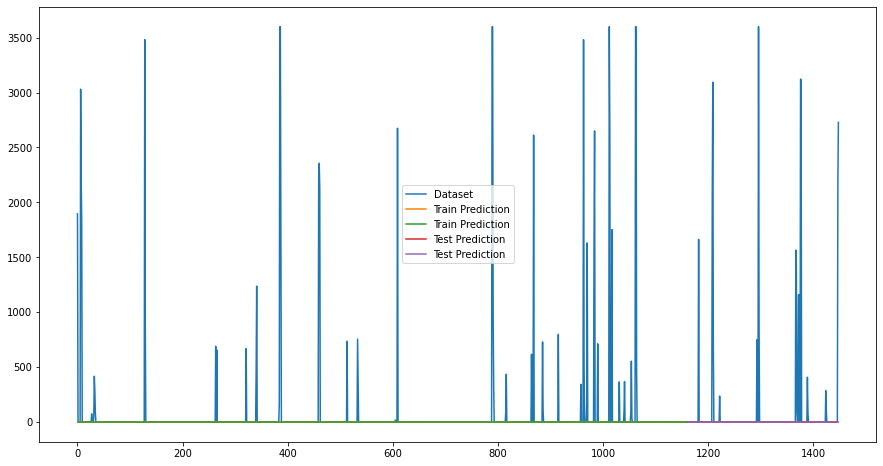

Epoch 1/100
1157/1157 - 2s - loss: 6589556795113472.0000 - accuracy: 0.1279 - 2s/epoch - 2ms/step
Epoch 2/100
1157/1157 - 1s - loss: 6757630676566016.0000 - accuracy: 0.0614 - 965ms/epoch - 834us/step
Epoch 3/100
1157/1157 - 1s - loss: 6757625307856896.0000 - accuracy: 0.1443 - 960ms/epoch - 830us/step
Epoch 4/100
1157/1157 - 1s - loss: 6757594706214912.0000 - accuracy: 0.1564 - 962ms/epoch - 831us/step
Epoch 5/100
1157/1157 - 1s - loss: 6757590948118528.0000 - accuracy: 0.1141 - 963ms/epoch - 833us/step
Epoch 6/100
1157/1157 - 1s - loss: 6757553367154688.0000 - accuracy: 0.1590 - 959ms/epoch - 829us/step
Epoch 7/100
1157/1157 - 1s - loss: 6757592021860352.0000 - accuracy: 0.0743 - 965ms/epoch - 834us/step
Epoch 8/100
1157/1157 - 1s - loss: 6757582358183936.0000 - accuracy: 0.2048 - 954ms/epoch - 825us/step
Epoch 9/100
1157/1157 - 1s - loss: 6757648930177024.0000 - accuracy: 0.1314 - 962ms/epoch - 831us/step
Epoch 10/100
1157/1157 - 1s - loss: 6757554977767424.0000 - accuracy: 0.1167 -

Epoch 80/100
1157/1157 - 1s - loss: 6757641950855168.0000 - accuracy: 0.1366 - 957ms/epoch - 827us/step
Epoch 81/100
1157/1157 - 1s - loss: 6757626918469632.0000 - accuracy: 0.1755 - 949ms/epoch - 820us/step
Epoch 82/100
1157/1157 - 1s - loss: 6757629602824192.0000 - accuracy: 0.1426 - 946ms/epoch - 817us/step
Epoch 83/100
1157/1157 - 1s - loss: 6757589874376704.0000 - accuracy: 0.1271 - 955ms/epoch - 825us/step
Epoch 84/100
1157/1157 - 1s - loss: 6757594706214912.0000 - accuracy: 0.1504 - 962ms/epoch - 831us/step
Epoch 85/100
1157/1157 - 1s - loss: 6757612959825920.0000 - accuracy: 0.1547 - 947ms/epoch - 818us/step
Epoch 86/100
1157/1157 - 1s - loss: 6757588800634880.0000 - accuracy: 0.1262 - 961ms/epoch - 830us/step
Epoch 87/100
1157/1157 - 1s - loss: 6757580747571200.0000 - accuracy: 0.1478 - 970ms/epoch - 839us/step
Epoch 88/100
1157/1157 - 1s - loss: 6757638729629696.0000 - accuracy: 0.1426 - 971ms/epoch - 839us/step
Epoch 89/100
1157/1157 - 1s - loss: 6757629602824192.0000 - accu

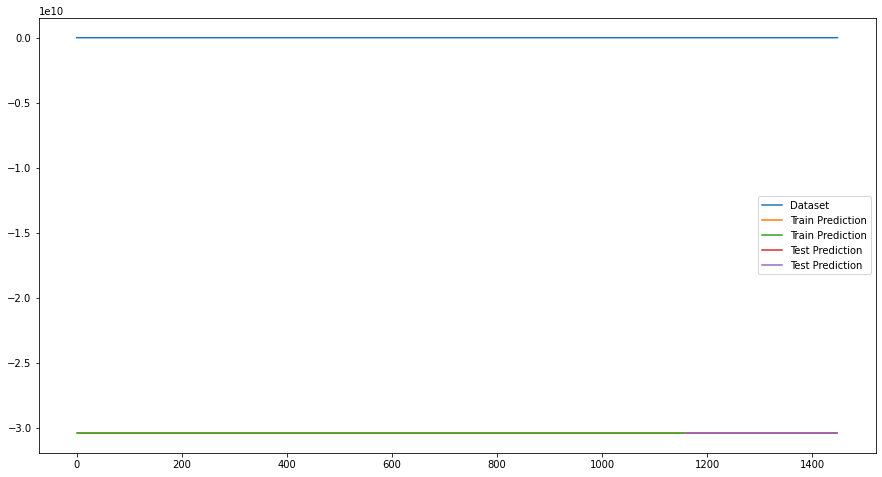

Epoch 1/100
1157/1157 - 2s - loss: 1068772.6250 - accuracy: 0.5540 - 2s/epoch - 2ms/step
Epoch 2/100
1157/1157 - 1s - loss: 726044.1875 - accuracy: 0.7960 - 981ms/epoch - 848us/step
Epoch 3/100
1157/1157 - 1s - loss: 609520.8750 - accuracy: 0.8954 - 982ms/epoch - 849us/step
Epoch 4/100
1157/1157 - 1s - loss: 519552.1562 - accuracy: 0.8531 - 978ms/epoch - 846us/step
Epoch 5/100
1157/1157 - 1s - loss: 492164.5938 - accuracy: 0.9231 - 1s/epoch - 865us/step
Epoch 6/100
1157/1157 - 1s - loss: 494311.8125 - accuracy: 0.8591 - 1s/epoch - 873us/step
Epoch 7/100
1157/1157 - 1s - loss: 487424.5625 - accuracy: 0.4598 - 982ms/epoch - 849us/step
Epoch 8/100
1157/1157 - 1s - loss: 485374.7188 - accuracy: 0.4365 - 1s/epoch - 871us/step
Epoch 9/100
1157/1157 - 1s - loss: 485813.8125 - accuracy: 0.3587 - 992ms/epoch - 858us/step
Epoch 10/100
1157/1157 - 1s - loss: 485646.8750 - accuracy: 0.2273 - 984ms/epoch - 850us/step
Epoch 11/100
1157/1157 - 1s - loss: 485528.1250 - accuracy: 0.0847 - 999ms/epoch -

Epoch 89/100
1157/1157 - 1s - loss: 485509.8125 - accuracy: 0.9447 - 978ms/epoch - 846us/step
Epoch 90/100
1157/1157 - 1s - loss: 485043.5938 - accuracy: 0.9455 - 985ms/epoch - 852us/step
Epoch 91/100
1157/1157 - 1s - loss: 485754.1875 - accuracy: 0.9455 - 1s/epoch - 869us/step
Epoch 92/100
1157/1157 - 1s - loss: 485340.2188 - accuracy: 0.9438 - 999ms/epoch - 864us/step
Epoch 93/100
1157/1157 - 1s - loss: 485371.7500 - accuracy: 0.9455 - 1s/epoch - 876us/step
Epoch 94/100
1157/1157 - 1s - loss: 485324.6250 - accuracy: 0.9455 - 1s/epoch - 944us/step
Epoch 95/100
1157/1157 - 1s - loss: 485297.1250 - accuracy: 0.9455 - 1s/epoch - 869us/step
Epoch 96/100
1157/1157 - 1s - loss: 485157.7812 - accuracy: 0.9455 - 1s/epoch - 890us/step
Epoch 97/100
1157/1157 - 1s - loss: 485287.8750 - accuracy: 0.9455 - 994ms/epoch - 859us/step
Epoch 98/100
1157/1157 - 1s - loss: 485316.4375 - accuracy: 0.9455 - 997ms/epoch - 861us/step
Epoch 99/100
1157/1157 - 1s - loss: 485325.2812 - accuracy: 0.9447 - 981ms/

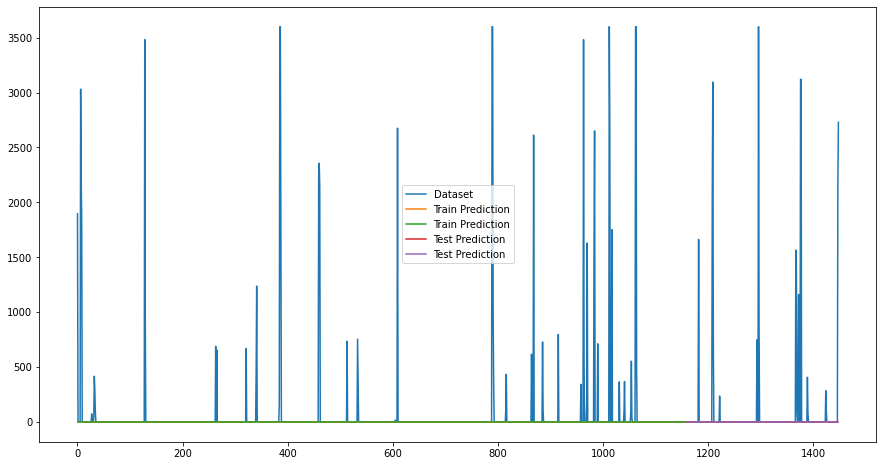

Epoch 1/100
1157/1157 - 2s - loss: 2226948.2500 - accuracy: 0.4745 - 2s/epoch - 2ms/step
Epoch 2/100
1157/1157 - 1s - loss: 1012041.2500 - accuracy: 0.4840 - 992ms/epoch - 857us/step
Epoch 3/100
1157/1157 - 1s - loss: 366383.0938 - accuracy: 0.5065 - 987ms/epoch - 853us/step
Epoch 4/100
1157/1157 - 1s - loss: 238386.2031 - accuracy: 0.5082 - 1s/epoch - 869us/step
Epoch 5/100
1157/1157 - 1s - loss: 219030.5000 - accuracy: 0.4927 - 1s/epoch - 874us/step
Epoch 6/100
1157/1157 - 1s - loss: 205338.8281 - accuracy: 0.4978 - 995ms/epoch - 860us/step
Epoch 7/100
1157/1157 - 1s - loss: 202856.3594 - accuracy: 0.4918 - 997ms/epoch - 862us/step
Epoch 8/100
1157/1157 - 1s - loss: 196859.3750 - accuracy: 0.4909 - 1s/epoch - 866us/step
Epoch 9/100
1157/1157 - 1s - loss: 198654.1250 - accuracy: 0.4996 - 991ms/epoch - 857us/step
Epoch 10/100
1157/1157 - 1s - loss: 195450.0156 - accuracy: 0.5117 - 989ms/epoch - 855us/step
Epoch 11/100
1157/1157 - 1s - loss: 200751.0156 - accuracy: 0.4918 - 990ms/epoch 

Epoch 90/100
1157/1157 - 1s - loss: 144884.4375 - accuracy: 0.4935 - 993ms/epoch - 858us/step
Epoch 91/100
1157/1157 - 1s - loss: 122924.7500 - accuracy: 0.5376 - 992ms/epoch - 857us/step
Epoch 92/100
1157/1157 - 1s - loss: 130527.5703 - accuracy: 0.4745 - 982ms/epoch - 849us/step
Epoch 93/100
1157/1157 - 1s - loss: 127597.2656 - accuracy: 0.4460 - 1s/epoch - 867us/step
Epoch 94/100
1157/1157 - 1s - loss: 136822.3281 - accuracy: 0.5298 - 997ms/epoch - 862us/step
Epoch 95/100
1157/1157 - 1s - loss: 118343.3594 - accuracy: 0.4857 - 983ms/epoch - 850us/step
Epoch 96/100
1157/1157 - 1s - loss: 126786.5000 - accuracy: 0.5056 - 996ms/epoch - 861us/step
Epoch 97/100
1157/1157 - 1s - loss: 125348.7969 - accuracy: 0.4987 - 986ms/epoch - 852us/step
Epoch 98/100
1157/1157 - 1s - loss: 136823.8281 - accuracy: 0.5134 - 990ms/epoch - 855us/step
Epoch 99/100
1157/1157 - 1s - loss: 133845.9219 - accuracy: 0.4572 - 985ms/epoch - 852us/step
Epoch 100/100
1157/1157 - 1s - loss: 133170.7344 - accuracy: 0.

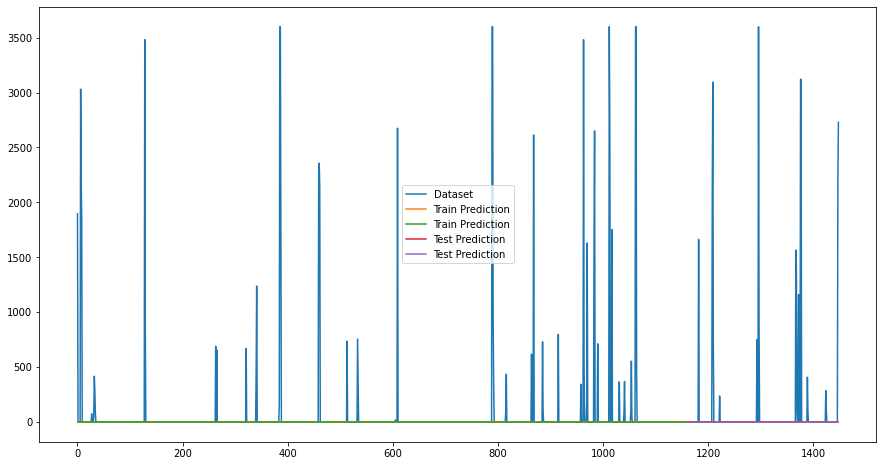

Epoch 1/100
1157/1157 - 2s - loss: 850410.8750 - accuracy: 0.1711 - 2s/epoch - 2ms/step
Epoch 2/100
1157/1157 - 1s - loss: 850708.4375 - accuracy: 0.2904 - 995ms/epoch - 860us/step
Epoch 3/100
1157/1157 - 1s - loss: 850637.0000 - accuracy: 0.4857 - 992ms/epoch - 857us/step
Epoch 4/100
1157/1157 - 1s - loss: 850533.1250 - accuracy: 0.5843 - 997ms/epoch - 862us/step
Epoch 5/100
1157/1157 - 1s - loss: 850402.8750 - accuracy: 0.4883 - 991ms/epoch - 856us/step
Epoch 6/100
1157/1157 - 1s - loss: 850280.5625 - accuracy: 0.5160 - 993ms/epoch - 858us/step
Epoch 7/100
1157/1157 - 1s - loss: 850462.6250 - accuracy: 0.9455 - 992ms/epoch - 857us/step
Epoch 8/100
1157/1157 - 1s - loss: 850300.0625 - accuracy: 0.6716 - 1s/epoch - 894us/step
Epoch 9/100
1157/1157 - 1s - loss: 850130.1875 - accuracy: 0.7476 - 1s/epoch - 877us/step
Epoch 10/100
1157/1157 - 1s - loss: 850021.5625 - accuracy: 0.2221 - 1s/epoch - 874us/step
Epoch 11/100
1157/1157 - 1s - loss: 849658.3750 - accuracy: 0.4961 - 987ms/epoch - 

Epoch 89/100
1157/1157 - 1s - loss: 831032.6250 - accuracy: 0.4866 - 1s/epoch - 865us/step
Epoch 90/100
1157/1157 - 1s - loss: 830753.3125 - accuracy: 0.4883 - 1000ms/epoch - 864us/step
Epoch 91/100
1157/1157 - 1s - loss: 830470.8125 - accuracy: 0.4866 - 983ms/epoch - 849us/step
Epoch 92/100
1157/1157 - 1s - loss: 830427.5000 - accuracy: 0.8289 - 985ms/epoch - 852us/step
Epoch 93/100
1157/1157 - 1s - loss: 830049.8750 - accuracy: 0.4901 - 985ms/epoch - 851us/step
Epoch 94/100
1157/1157 - 1s - loss: 829768.1250 - accuracy: 0.4909 - 982ms/epoch - 849us/step
Epoch 95/100
1157/1157 - 1s - loss: 829621.9375 - accuracy: 0.7191 - 982ms/epoch - 849us/step
Epoch 96/100
1157/1157 - 1s - loss: 829631.5625 - accuracy: 0.9455 - 991ms/epoch - 857us/step
Epoch 97/100
1157/1157 - 1s - loss: 829372.9375 - accuracy: 0.3881 - 1s/epoch - 873us/step
Epoch 98/100
1157/1157 - 1s - loss: 829166.3750 - accuracy: 0.0320 - 991ms/epoch - 857us/step
Epoch 99/100
1157/1157 - 1s - loss: 828851.5625 - accuracy: 0.392

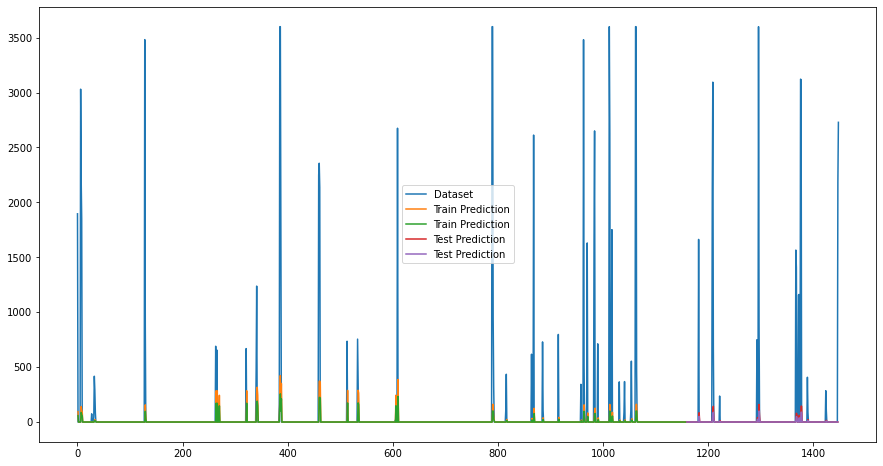

Epoch 1/100
1157/1157 - 2s - loss: 1620856.5000 - accuracy: 0.3250 - 2s/epoch - 2ms/step
Epoch 2/100
1157/1157 - 1s - loss: 1500980.6250 - accuracy: 0.7373 - 966ms/epoch - 835us/step
Epoch 3/100
1157/1157 - 1s - loss: 1426950.8750 - accuracy: 0.4927 - 972ms/epoch - 841us/step
Epoch 4/100
1157/1157 - 1s - loss: 1379493.0000 - accuracy: 0.5307 - 974ms/epoch - 842us/step
Epoch 5/100
1157/1157 - 1s - loss: 1332417.5000 - accuracy: 0.2221 - 965ms/epoch - 834us/step
Epoch 6/100
1157/1157 - 1s - loss: 1293013.2500 - accuracy: 0.4261 - 971ms/epoch - 839us/step
Epoch 7/100
1157/1157 - 1s - loss: 1259430.0000 - accuracy: 0.3362 - 963ms/epoch - 833us/step
Epoch 8/100
1157/1157 - 1s - loss: 1226246.0000 - accuracy: 0.3345 - 961ms/epoch - 831us/step
Epoch 9/100
1157/1157 - 1s - loss: 1198802.2500 - accuracy: 0.2783 - 965ms/epoch - 834us/step
Epoch 10/100
1157/1157 - 1s - loss: 1168936.2500 - accuracy: 0.2100 - 970ms/epoch - 838us/step
Epoch 11/100
1157/1157 - 1s - loss: 1147740.8750 - accuracy: 0.3

1157/1157 - 1s - loss: 661378.4375 - accuracy: 0.3630 - 1s/epoch - 865us/step
Epoch 89/100
1157/1157 - 1s - loss: 656883.3125 - accuracy: 0.4762 - 1s/epoch - 867us/step
Epoch 90/100
1157/1157 - 1s - loss: 653343.6250 - accuracy: 0.4356 - 1s/epoch - 868us/step
Epoch 91/100
1157/1157 - 1s - loss: 648987.0625 - accuracy: 0.2126 - 989ms/epoch - 855us/step
Epoch 92/100
1157/1157 - 1s - loss: 645490.3750 - accuracy: 0.4105 - 999ms/epoch - 863us/step
Epoch 93/100
1157/1157 - 1s - loss: 641637.3125 - accuracy: 0.1296 - 999ms/epoch - 864us/step
Epoch 94/100
1157/1157 - 1s - loss: 637389.9375 - accuracy: 0.7035 - 993ms/epoch - 859us/step
Epoch 95/100
1157/1157 - 1s - loss: 633656.3125 - accuracy: 0.3051 - 997ms/epoch - 862us/step
Epoch 96/100
1157/1157 - 1s - loss: 630087.5625 - accuracy: 0.2385 - 986ms/epoch - 852us/step
Epoch 97/100
1157/1157 - 1s - loss: 626438.6250 - accuracy: 0.3829 - 989ms/epoch - 855us/step
Epoch 98/100
1157/1157 - 1s - loss: 622436.3750 - accuracy: 0.3829 - 967ms/epoch -

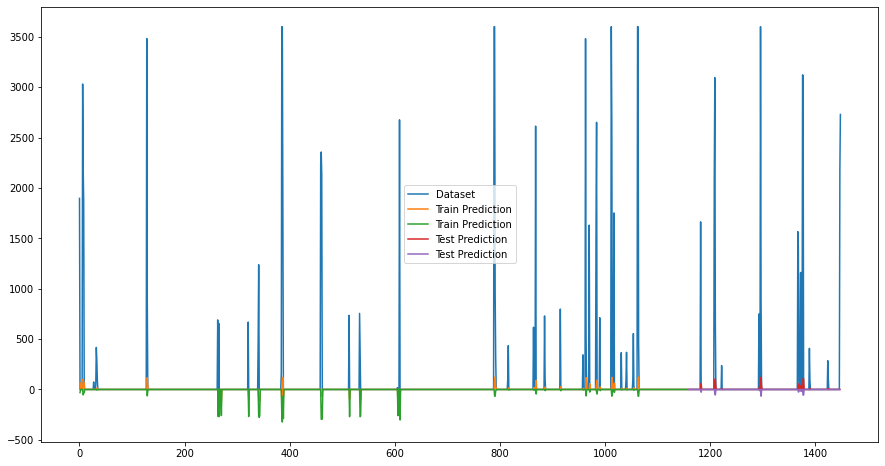

Epoch 1/100
1157/1157 - 2s - loss: 669483.8750 - accuracy: 0.4849 - 2s/epoch - 2ms/step
Epoch 2/100
1157/1157 - 1s - loss: 579818.0000 - accuracy: 0.4762 - 1s/epoch - 871us/step
Epoch 3/100
1157/1157 - 1s - loss: 465965.9688 - accuracy: 0.4676 - 1s/epoch - 873us/step
Epoch 4/100
1157/1157 - 1s - loss: 334776.4062 - accuracy: 0.4754 - 999ms/epoch - 863us/step
Epoch 5/100
1157/1157 - 1s - loss: 304471.3125 - accuracy: 0.4624 - 1s/epoch - 867us/step
Epoch 6/100
1157/1157 - 1s - loss: 258959.3281 - accuracy: 0.4840 - 1s/epoch - 871us/step
Epoch 7/100
1157/1157 - 1s - loss: 251106.6250 - accuracy: 0.4806 - 1s/epoch - 867us/step
Epoch 8/100
1157/1157 - 1s - loss: 232619.9219 - accuracy: 0.5022 - 1s/epoch - 869us/step
Epoch 9/100
1157/1157 - 1s - loss: 238531.8438 - accuracy: 0.4978 - 1s/epoch - 876us/step
Epoch 10/100
1157/1157 - 1s - loss: 228585.4688 - accuracy: 0.5160 - 1s/epoch - 865us/step
Epoch 11/100
1157/1157 - 1s - loss: 251628.6094 - accuracy: 0.4659 - 1s/epoch - 866us/step
Epoch 1

1157/1157 - 1s - loss: 171608.0938 - accuracy: 0.4650 - 997ms/epoch - 862us/step
Epoch 91/100
1157/1157 - 1s - loss: 168852.6406 - accuracy: 0.4745 - 1s/epoch - 867us/step
Epoch 92/100
1157/1157 - 1s - loss: 193156.6406 - accuracy: 0.4754 - 1s/epoch - 875us/step
Epoch 93/100
1157/1157 - 1s - loss: 174816.3594 - accuracy: 0.4771 - 1s/epoch - 872us/step
Epoch 94/100
1157/1157 - 1s - loss: 174635.5312 - accuracy: 0.4935 - 988ms/epoch - 854us/step
Epoch 95/100
1157/1157 - 1s - loss: 150976.8594 - accuracy: 0.4961 - 999ms/epoch - 863us/step
Epoch 96/100
1157/1157 - 1s - loss: 182815.6562 - accuracy: 0.4952 - 991ms/epoch - 857us/step
Epoch 97/100
1157/1157 - 1s - loss: 161235.4375 - accuracy: 0.5117 - 991ms/epoch - 857us/step
Epoch 98/100
1157/1157 - 1s - loss: 151237.1250 - accuracy: 0.4503 - 1s/epoch - 867us/step
Epoch 99/100
1157/1157 - 1s - loss: 181257.9219 - accuracy: 0.3959 - 999ms/epoch - 863us/step
Epoch 100/100
1157/1157 - 1s - loss: 167452.2969 - accuracy: 0.4927 - 995ms/epoch - 8

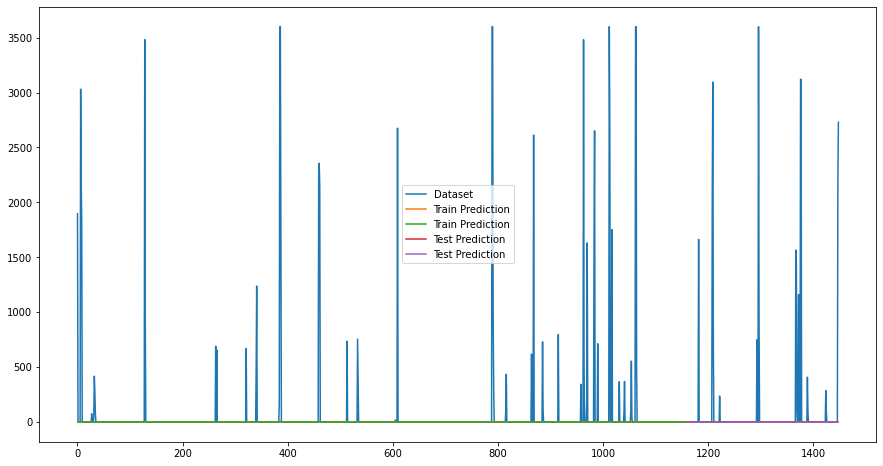

Epoch 1/100
1157/1157 - 2s - loss: 682542.0625 - accuracy: 0.2515 - 2s/epoch - 2ms/step
Epoch 2/100
1157/1157 - 1s - loss: 419136.9688 - accuracy: 0.0346 - 1s/epoch - 901us/step
Epoch 3/100
1157/1157 - 1s - loss: 352206.2500 - accuracy: 0.1694 - 1s/epoch - 883us/step
Epoch 4/100
1157/1157 - 1s - loss: 311074.4375 - accuracy: 0.2264 - 1s/epoch - 892us/step
Epoch 5/100
1157/1157 - 1s - loss: 285740.6875 - accuracy: 0.4806 - 1s/epoch - 885us/step
Epoch 6/100
1157/1157 - 1s - loss: 261017.7500 - accuracy: 0.3950 - 1s/epoch - 920us/step
Epoch 7/100
1157/1157 - 1s - loss: 228948.7812 - accuracy: 0.4330 - 1s/epoch - 879us/step
Epoch 8/100
1157/1157 - 1s - loss: 218429.0938 - accuracy: 0.5246 - 1s/epoch - 903us/step
Epoch 9/100
1157/1157 - 1s - loss: 205159.9062 - accuracy: 0.4399 - 1s/epoch - 877us/step
Epoch 10/100
1157/1157 - 1s - loss: 198290.3281 - accuracy: 0.5151 - 1s/epoch - 879us/step
Epoch 11/100
1157/1157 - 1s - loss: 189006.5625 - accuracy: 0.5177 - 1s/epoch - 900us/step
Epoch 12/1

Epoch 92/100
1157/1157 - 1s - loss: 94008.5625 - accuracy: 0.6223 - 1s/epoch - 887us/step
Epoch 93/100
1157/1157 - 1s - loss: 93248.7344 - accuracy: 0.6422 - 1s/epoch - 898us/step
Epoch 94/100
1157/1157 - 1s - loss: 93927.7969 - accuracy: 0.6188 - 1s/epoch - 884us/step
Epoch 95/100
1157/1157 - 1s - loss: 95443.7578 - accuracy: 0.6033 - 1s/epoch - 876us/step
Epoch 96/100
1157/1157 - 1s - loss: 93600.5703 - accuracy: 0.6232 - 1s/epoch - 875us/step
Epoch 97/100
1157/1157 - 1s - loss: 93298.6797 - accuracy: 0.6093 - 1s/epoch - 882us/step
Epoch 98/100
1157/1157 - 1s - loss: 93225.3125 - accuracy: 0.6111 - 1s/epoch - 883us/step
Epoch 99/100
1157/1157 - 1s - loss: 94547.7031 - accuracy: 0.6041 - 1s/epoch - 882us/step
Epoch 100/100
1157/1157 - 1s - loss: 94209.8906 - accuracy: 0.6249 - 1s/epoch - 879us/step
Train Score: 413.28 RMSE
Test Score: 469.40 RMSE


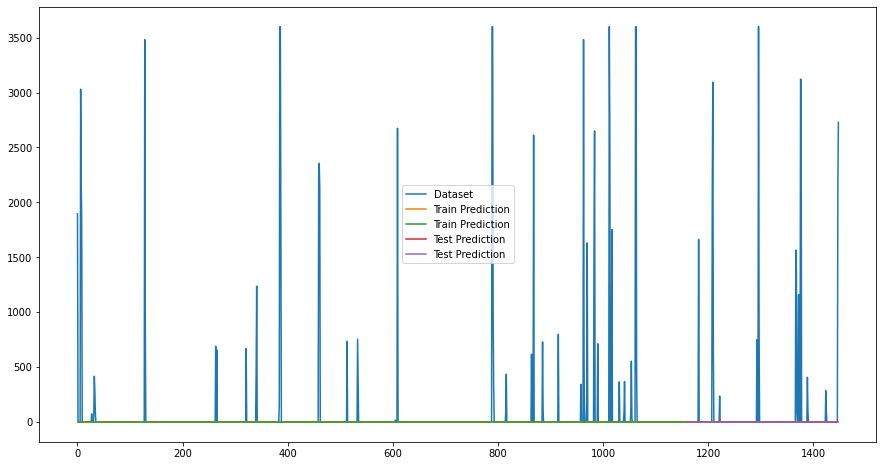

Epoch 1/100
1157/1157 - 2s - loss: 27485.9922 - accuracy: 0.9455 - 2s/epoch - 2ms/step
Epoch 2/100
1157/1157 - 1s - loss: 11810.6416 - accuracy: 0.9455 - 1s/epoch - 868us/step
Epoch 3/100
1157/1157 - 1s - loss: 8447.7637 - accuracy: 0.9455 - 991ms/epoch - 857us/step
Epoch 4/100
1157/1157 - 1s - loss: 7907.9482 - accuracy: 0.9455 - 1s/epoch - 875us/step
Epoch 5/100
1157/1157 - 1s - loss: 6905.7520 - accuracy: 0.9455 - 996ms/epoch - 861us/step
Epoch 6/100
1157/1157 - 1s - loss: 6227.7979 - accuracy: 0.9455 - 994ms/epoch - 859us/step
Epoch 7/100
1157/1157 - 1s - loss: 5519.0825 - accuracy: 0.9455 - 1s/epoch - 870us/step
Epoch 8/100
1157/1157 - 1s - loss: 5315.8184 - accuracy: 0.9455 - 1000ms/epoch - 864us/step
Epoch 9/100
1157/1157 - 1s - loss: 4983.1294 - accuracy: 0.9455 - 1s/epoch - 872us/step
Epoch 10/100
1157/1157 - 1s - loss: 4706.0825 - accuracy: 0.9455 - 995ms/epoch - 860us/step
Epoch 11/100
1157/1157 - 1s - loss: 4438.8403 - accuracy: 0.9455 - 997ms/epoch - 862us/step
Epoch 12/10

Epoch 92/100
1157/1157 - 1s - loss: 1508.1821 - accuracy: 0.9455 - 993ms/epoch - 858us/step
Epoch 93/100
1157/1157 - 1s - loss: 1459.0737 - accuracy: 0.9455 - 997ms/epoch - 861us/step
Epoch 94/100
1157/1157 - 1s - loss: 1492.0659 - accuracy: 0.9455 - 1s/epoch - 866us/step
Epoch 95/100
1157/1157 - 1s - loss: 1438.2567 - accuracy: 0.9455 - 1s/epoch - 882us/step
Epoch 96/100
1157/1157 - 1s - loss: 1473.8047 - accuracy: 0.9455 - 988ms/epoch - 854us/step
Epoch 97/100
1157/1157 - 1s - loss: 1468.7743 - accuracy: 0.9455 - 990ms/epoch - 856us/step
Epoch 98/100
1157/1157 - 1s - loss: 1418.6929 - accuracy: 0.9455 - 1s/epoch - 872us/step
Epoch 99/100
1157/1157 - 1s - loss: 1435.4054 - accuracy: 0.9455 - 999ms/epoch - 864us/step
Epoch 100/100
1157/1157 - 1s - loss: 1441.3530 - accuracy: 0.9455 - 1s/epoch - 867us/step
Train Score: 413.40 RMSE
Test Score: 469.55 RMSE


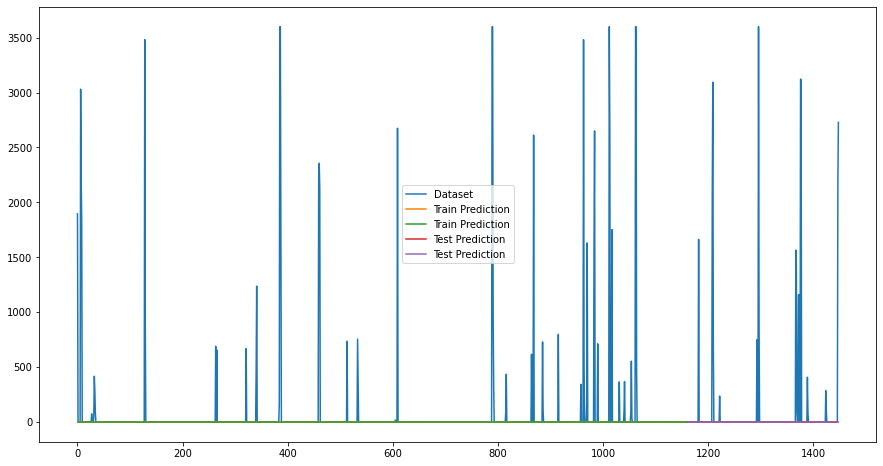

Epoch 1/100
1157/1157 - 2s - loss: 0.0070 - accuracy: 0.8894 - 2s/epoch - 2ms/step
Epoch 2/100
1157/1157 - 1s - loss: 0.0070 - accuracy: 0.8643 - 975ms/epoch - 842us/step
Epoch 3/100
1157/1157 - 1s - loss: 0.0070 - accuracy: 0.8418 - 983ms/epoch - 850us/step
Epoch 4/100
1157/1157 - 1s - loss: 0.0070 - accuracy: 0.9144 - 960ms/epoch - 830us/step
Epoch 5/100
1157/1157 - 1s - loss: 0.0069 - accuracy: 0.9455 - 968ms/epoch - 836us/step
Epoch 6/100
1157/1157 - 1s - loss: 0.0069 - accuracy: 0.8453 - 976ms/epoch - 844us/step
Epoch 7/100
1157/1157 - 1s - loss: 0.0069 - accuracy: 0.9412 - 968ms/epoch - 837us/step
Epoch 8/100
1157/1157 - 1s - loss: 0.0068 - accuracy: 0.7848 - 985ms/epoch - 852us/step
Epoch 9/100
1157/1157 - 1s - loss: 0.0068 - accuracy: 0.9300 - 964ms/epoch - 833us/step
Epoch 10/100
1157/1157 - 1s - loss: 0.0068 - accuracy: 0.9162 - 976ms/epoch - 843us/step
Epoch 11/100
1157/1157 - 1s - loss: 0.0068 - accuracy: 0.9455 - 957ms/epoch - 827us/step
Epoch 12/100
1157/1157 - 1s - loss:

Epoch 94/100
1157/1157 - 1s - loss: 0.0065 - accuracy: 0.3388 - 964ms/epoch - 834us/step
Epoch 95/100
1157/1157 - 1s - loss: 0.0065 - accuracy: 0.3025 - 968ms/epoch - 837us/step
Epoch 96/100
1157/1157 - 1s - loss: 0.0065 - accuracy: 0.5134 - 966ms/epoch - 835us/step
Epoch 97/100
1157/1157 - 1s - loss: 0.0065 - accuracy: 0.5073 - 955ms/epoch - 825us/step
Epoch 98/100
1157/1157 - 1s - loss: 0.0065 - accuracy: 0.5246 - 965ms/epoch - 834us/step
Epoch 99/100
1157/1157 - 1s - loss: 0.0065 - accuracy: 0.4823 - 999ms/epoch - 864us/step
Epoch 100/100
1157/1157 - 1s - loss: 0.0065 - accuracy: 0.5739 - 991ms/epoch - 856us/step
Train Score: 379.90 RMSE
Test Score: 439.33 RMSE


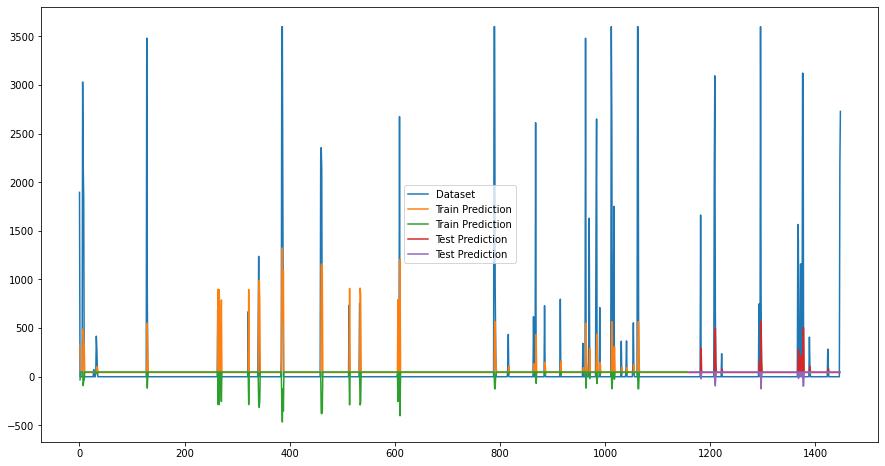

Epoch 1/100
1157/1157 - 2s - loss: 0.0071 - accuracy: 0.9196 - 2s/epoch - 2ms/step
Epoch 2/100
1157/1157 - 1s - loss: 0.0071 - accuracy: 0.9196 - 989ms/epoch - 855us/step
Epoch 3/100
1157/1157 - 1s - loss: 0.0071 - accuracy: 0.9196 - 991ms/epoch - 856us/step
Epoch 4/100
1157/1157 - 1s - loss: 0.0071 - accuracy: 0.9196 - 1s/epoch - 865us/step
Epoch 5/100
1157/1157 - 1s - loss: 0.0071 - accuracy: 0.9196 - 982ms/epoch - 849us/step
Epoch 6/100
1157/1157 - 1s - loss: 0.0071 - accuracy: 0.9196 - 996ms/epoch - 861us/step
Epoch 7/100
1157/1157 - 1s - loss: 0.0071 - accuracy: 0.9196 - 985ms/epoch - 851us/step
Epoch 8/100
1157/1157 - 1s - loss: 0.0071 - accuracy: 0.9196 - 984ms/epoch - 851us/step
Epoch 9/100
1157/1157 - 1s - loss: 0.0071 - accuracy: 0.9196 - 1s/epoch - 885us/step
Epoch 10/100
1157/1157 - 1s - loss: 0.0071 - accuracy: 0.9196 - 1s/epoch - 871us/step
Epoch 11/100
1157/1157 - 1s - loss: 0.0071 - accuracy: 0.9196 - 1s/epoch - 867us/step
Epoch 12/100
1157/1157 - 1s - loss: 0.0071 - ac

1157/1157 - 1s - loss: 0.0071 - accuracy: 0.9196 - 985ms/epoch - 851us/step
Epoch 95/100
1157/1157 - 1s - loss: 0.0071 - accuracy: 0.9196 - 1s/epoch - 873us/step
Epoch 96/100
1157/1157 - 1s - loss: 0.0071 - accuracy: 0.9196 - 983ms/epoch - 850us/step
Epoch 97/100
1157/1157 - 1s - loss: 0.0071 - accuracy: 0.9196 - 997ms/epoch - 861us/step
Epoch 98/100
1157/1157 - 1s - loss: 0.0071 - accuracy: 0.9196 - 997ms/epoch - 862us/step
Epoch 99/100
1157/1157 - 1s - loss: 0.0071 - accuracy: 0.9196 - 1s/epoch - 878us/step
Epoch 100/100
1157/1157 - 1s - loss: 0.0071 - accuracy: 0.9196 - 981ms/epoch - 848us/step
Train Score: 437.51 RMSE
Test Score: 482.78 RMSE


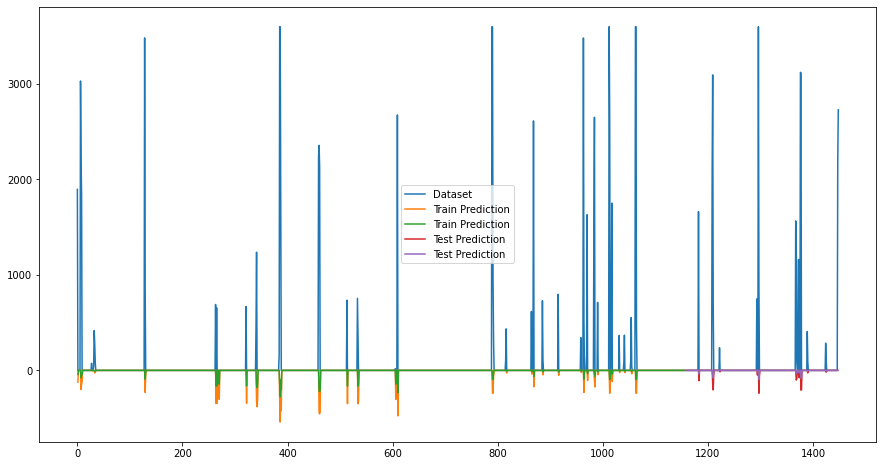

Epoch 1/100
1157/1157 - 2s - loss: 0.0066 - accuracy: 0.3068 - 2s/epoch - 2ms/step
Epoch 2/100
1157/1157 - 1s - loss: 0.0065 - accuracy: 0.1487 - 993ms/epoch - 858us/step
Epoch 3/100
1157/1157 - 1s - loss: 0.0065 - accuracy: 0.1314 - 1s/epoch - 872us/step
Epoch 4/100
1157/1157 - 1s - loss: 0.0065 - accuracy: 0.5877 - 1s/epoch - 871us/step
Epoch 5/100
1157/1157 - 1s - loss: 0.0064 - accuracy: 0.8081 - 1s/epoch - 868us/step
Epoch 6/100
1157/1157 - 1s - loss: 0.0064 - accuracy: 0.6482 - 1000ms/epoch - 864us/step
Epoch 7/100
1157/1157 - 1s - loss: 0.0064 - accuracy: 0.8280 - 1s/epoch - 871us/step
Epoch 8/100
1157/1157 - 1s - loss: 0.0064 - accuracy: 0.8384 - 1s/epoch - 868us/step
Epoch 9/100
1157/1157 - 1s - loss: 0.0064 - accuracy: 0.8254 - 985ms/epoch - 851us/step
Epoch 10/100
1157/1157 - 1s - loss: 0.0064 - accuracy: 0.9248 - 990ms/epoch - 856us/step
Epoch 11/100
1157/1157 - 1s - loss: 0.0064 - accuracy: 0.9274 - 1s/epoch - 871us/step
Epoch 12/100
1157/1157 - 1s - loss: 0.0064 - accurac

Epoch 96/100
1157/1157 - 1s - loss: 0.0063 - accuracy: 0.8989 - 1s/epoch - 874us/step
Epoch 97/100
1157/1157 - 1s - loss: 0.0063 - accuracy: 0.6966 - 1s/epoch - 864us/step
Epoch 98/100
1157/1157 - 1s - loss: 0.0063 - accuracy: 0.8150 - 1s/epoch - 866us/step
Epoch 99/100
1157/1157 - 1s - loss: 0.0063 - accuracy: 0.7934 - 1s/epoch - 870us/step
Epoch 100/100
1157/1157 - 1s - loss: 0.0063 - accuracy: 0.4097 - 1s/epoch - 866us/step
Train Score: 451.97 RMSE
Test Score: 485.87 RMSE


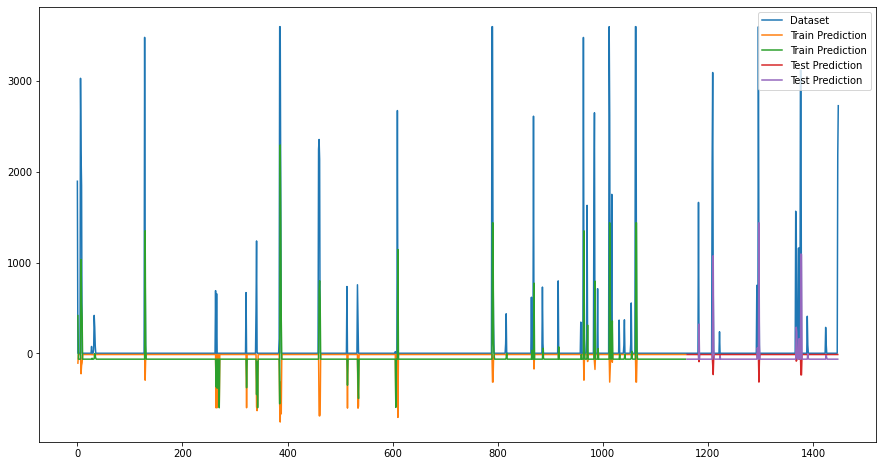

Epoch 1/100
1157/1157 - 2s - loss: 0.0066 - accuracy: 0.9179 - 2s/epoch - 2ms/step
Epoch 2/100
1157/1157 - 1s - loss: 0.0066 - accuracy: 0.9455 - 1s/epoch - 870us/step
Epoch 3/100
1157/1157 - 1s - loss: 0.0066 - accuracy: 0.9455 - 1s/epoch - 868us/step
Epoch 4/100
1157/1157 - 1s - loss: 0.0066 - accuracy: 0.9455 - 995ms/epoch - 860us/step
Epoch 5/100
1157/1157 - 1s - loss: 0.0066 - accuracy: 0.9455 - 1s/epoch - 869us/step
Epoch 6/100
1157/1157 - 1s - loss: 0.0066 - accuracy: 0.9455 - 994ms/epoch - 859us/step
Epoch 7/100
1157/1157 - 1s - loss: 0.0066 - accuracy: 0.9455 - 1s/epoch - 865us/step
Epoch 8/100
1157/1157 - 1s - loss: 0.0066 - accuracy: 0.9455 - 1s/epoch - 874us/step
Epoch 9/100
1157/1157 - 1s - loss: 0.0066 - accuracy: 0.9455 - 998ms/epoch - 863us/step
Epoch 10/100
1157/1157 - 1s - loss: 0.0066 - accuracy: 0.9455 - 1s/epoch - 865us/step
Epoch 11/100
1157/1157 - 1s - loss: 0.0066 - accuracy: 0.9455 - 1s/epoch - 882us/step
Epoch 12/100
1157/1157 - 1s - loss: 0.0066 - accuracy: 0

Epoch 96/100
1157/1157 - 1s - loss: 0.0066 - accuracy: 0.9455 - 1s/epoch - 868us/step
Epoch 97/100
1157/1157 - 1s - loss: 0.0066 - accuracy: 0.9455 - 1s/epoch - 876us/step
Epoch 98/100
1157/1157 - 1s - loss: 0.0066 - accuracy: 0.9455 - 1s/epoch - 869us/step
Epoch 99/100
1157/1157 - 1s - loss: 0.0066 - accuracy: 0.9455 - 1s/epoch - 877us/step
Epoch 100/100
1157/1157 - 1s - loss: 0.0066 - accuracy: 0.9455 - 1s/epoch - 872us/step
Train Score: 388.66 RMSE
Test Score: 451.95 RMSE


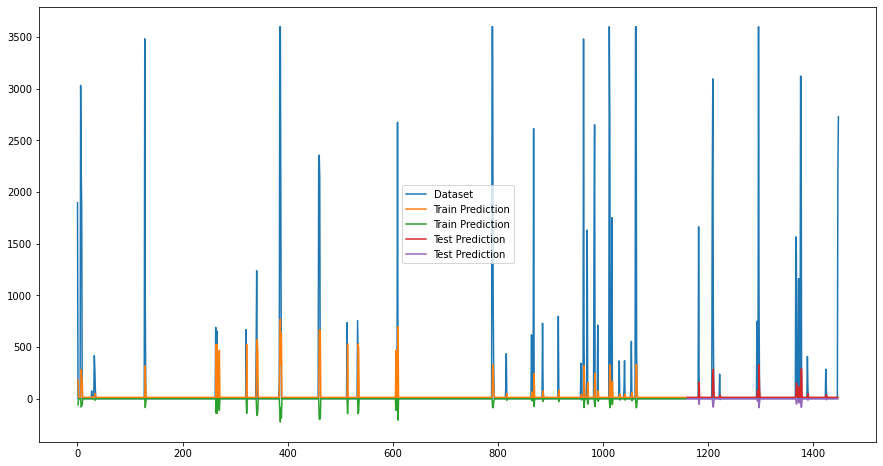

Epoch 1/100
1157/1157 - 2s - loss: 0.0065 - accuracy: 0.9231 - 2s/epoch - 2ms/step
Epoch 2/100
1157/1157 - 1s - loss: 0.0064 - accuracy: 0.9248 - 1s/epoch - 898us/step
Epoch 3/100
1157/1157 - 1s - loss: 0.0064 - accuracy: 0.9248 - 996ms/epoch - 861us/step
Epoch 4/100
1157/1157 - 1s - loss: 0.0064 - accuracy: 0.9248 - 997ms/epoch - 862us/step
Epoch 5/100
1157/1157 - 1s - loss: 0.0064 - accuracy: 0.9248 - 1s/epoch - 867us/step
Epoch 6/100
1157/1157 - 1s - loss: 0.0064 - accuracy: 0.9248 - 995ms/epoch - 860us/step
Epoch 7/100
1157/1157 - 1s - loss: 0.0064 - accuracy: 0.9248 - 1000ms/epoch - 864us/step
Epoch 8/100
1157/1157 - 1s - loss: 0.0064 - accuracy: 0.9248 - 997ms/epoch - 862us/step
Epoch 9/100
1157/1157 - 1s - loss: 0.0064 - accuracy: 0.9248 - 992ms/epoch - 858us/step
Epoch 10/100
1157/1157 - 1s - loss: 0.0064 - accuracy: 0.9248 - 993ms/epoch - 858us/step
Epoch 11/100
1157/1157 - 1s - loss: 0.0064 - accuracy: 0.9248 - 1s/epoch - 871us/step
Epoch 12/100
1157/1157 - 1s - loss: 0.0064 

Epoch 95/100
1157/1157 - 1s - loss: 0.0062 - accuracy: 0.9248 - 1s/epoch - 866us/step
Epoch 96/100
1157/1157 - 1s - loss: 0.0062 - accuracy: 0.9248 - 1s/epoch - 866us/step
Epoch 97/100
1157/1157 - 1s - loss: 0.0062 - accuracy: 0.9248 - 1s/epoch - 871us/step
Epoch 98/100
1157/1157 - 1s - loss: 0.0062 - accuracy: 0.9248 - 992ms/epoch - 858us/step
Epoch 99/100
1157/1157 - 1s - loss: 0.0062 - accuracy: 0.9248 - 992ms/epoch - 857us/step
Epoch 100/100
1157/1157 - 1s - loss: 0.0062 - accuracy: 0.9248 - 998ms/epoch - 863us/step
Train Score: 397.55 RMSE
Test Score: 455.81 RMSE


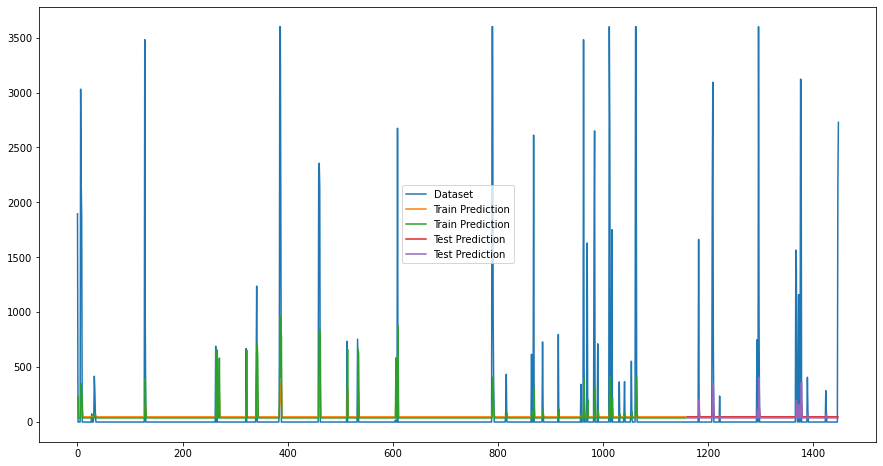

Epoch 1/100
1157/1157 - 2s - loss: 0.0069 - accuracy: 0.9170 - 2s/epoch - 2ms/step
Epoch 2/100
1157/1157 - 1s - loss: 0.0068 - accuracy: 0.9455 - 1s/epoch - 865us/step
Epoch 3/100
1157/1157 - 1s - loss: 0.0068 - accuracy: 0.9455 - 1s/epoch - 868us/step
Epoch 4/100
1157/1157 - 1s - loss: 0.0068 - accuracy: 0.9455 - 1s/epoch - 867us/step
Epoch 5/100
1157/1157 - 1s - loss: 0.0068 - accuracy: 0.9455 - 1s/epoch - 874us/step
Epoch 6/100
1157/1157 - 1s - loss: 0.0068 - accuracy: 0.9455 - 1s/epoch - 867us/step
Epoch 7/100
1157/1157 - 1s - loss: 0.0067 - accuracy: 0.9455 - 1s/epoch - 864us/step
Epoch 8/100
1157/1157 - 1s - loss: 0.0067 - accuracy: 0.9455 - 1s/epoch - 865us/step
Epoch 9/100
1157/1157 - 1s - loss: 0.0067 - accuracy: 0.9455 - 1s/epoch - 867us/step
Epoch 10/100
1157/1157 - 1s - loss: 0.0067 - accuracy: 0.9455 - 995ms/epoch - 860us/step
Epoch 11/100
1157/1157 - 1s - loss: 0.0067 - accuracy: 0.9455 - 993ms/epoch - 859us/step
Epoch 12/100
1157/1157 - 1s - loss: 0.0067 - accuracy: 0.94

1157/1157 - 1s - loss: 0.0063 - accuracy: 0.9455 - 1s/epoch - 866us/step
Epoch 96/100
1157/1157 - 1s - loss: 0.0063 - accuracy: 0.9455 - 1s/epoch - 865us/step
Epoch 97/100
1157/1157 - 1s - loss: 0.0063 - accuracy: 0.9455 - 1s/epoch - 864us/step
Epoch 98/100
1157/1157 - 1s - loss: 0.0063 - accuracy: 0.9455 - 997ms/epoch - 862us/step
Epoch 99/100
1157/1157 - 1s - loss: 0.0063 - accuracy: 0.9455 - 994ms/epoch - 859us/step
Epoch 100/100
1157/1157 - 1s - loss: 0.0063 - accuracy: 0.9455 - 998ms/epoch - 863us/step
Train Score: 368.90 RMSE
Test Score: 429.41 RMSE


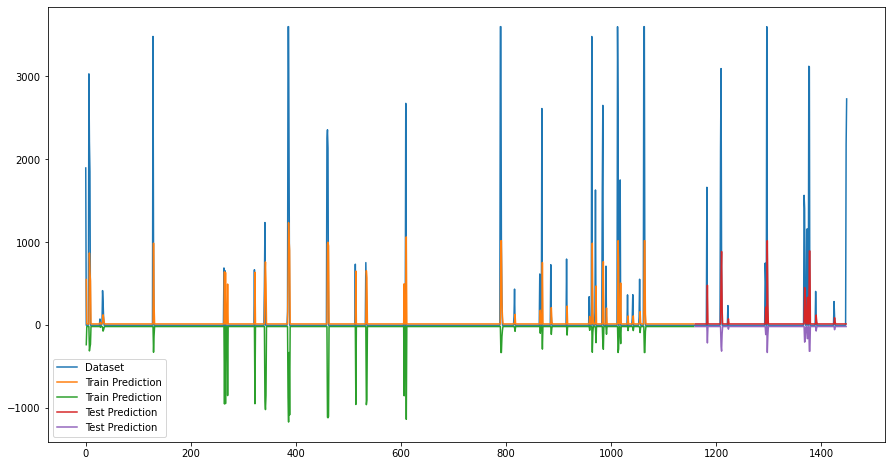

Epoch 1/100
1157/1157 - 3s - loss: 0.0071 - accuracy: 0.9455 - 3s/epoch - 2ms/step
Epoch 2/100
1157/1157 - 1s - loss: 0.0071 - accuracy: 0.9455 - 1s/epoch - 882us/step
Epoch 3/100
1157/1157 - 1s - loss: 0.0071 - accuracy: 0.9455 - 1s/epoch - 892us/step
Epoch 4/100
1157/1157 - 1s - loss: 0.0071 - accuracy: 0.9455 - 1s/epoch - 879us/step
Epoch 5/100
1157/1157 - 1s - loss: 0.0071 - accuracy: 0.9455 - 1s/epoch - 881us/step
Epoch 6/100
1157/1157 - 1s - loss: 0.0071 - accuracy: 0.9455 - 1s/epoch - 877us/step
Epoch 7/100
1157/1157 - 1s - loss: 0.0071 - accuracy: 0.9455 - 1s/epoch - 878us/step
Epoch 8/100
1157/1157 - 1s - loss: 0.0071 - accuracy: 0.9455 - 1s/epoch - 888us/step
Epoch 9/100
1157/1157 - 1s - loss: 0.0071 - accuracy: 0.9455 - 1s/epoch - 881us/step
Epoch 10/100
1157/1157 - 1s - loss: 0.0071 - accuracy: 0.9455 - 1s/epoch - 881us/step
Epoch 11/100
1157/1157 - 1s - loss: 0.0071 - accuracy: 0.9455 - 1s/epoch - 903us/step
Epoch 12/100
1157/1157 - 1s - loss: 0.0071 - accuracy: 0.9455 - 1

Epoch 97/100
1157/1157 - 1s - loss: 0.0071 - accuracy: 0.9455 - 1s/epoch - 880us/step
Epoch 98/100
1157/1157 - 1s - loss: 0.0071 - accuracy: 0.9455 - 1s/epoch - 890us/step
Epoch 99/100
1157/1157 - 1s - loss: 0.0071 - accuracy: 0.9455 - 1s/epoch - 896us/step
Epoch 100/100
1157/1157 - 1s - loss: 0.0071 - accuracy: 0.9455 - 1s/epoch - 881us/step
Train Score: 445.27 RMSE
Test Score: 484.49 RMSE


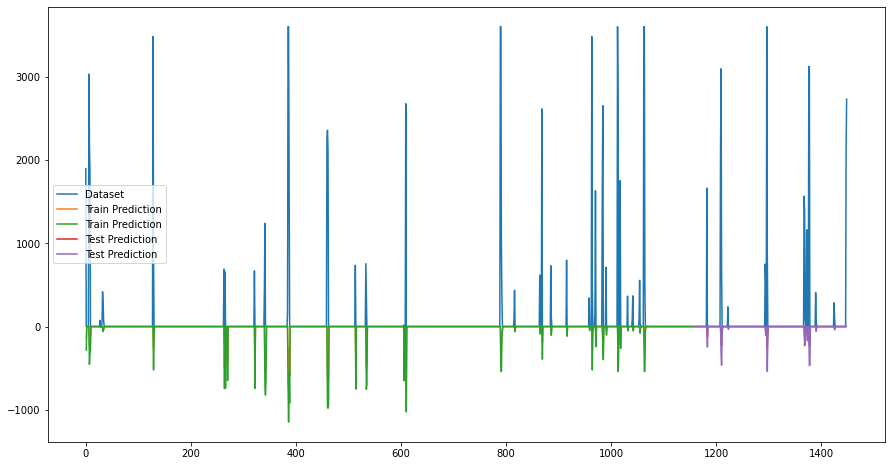

Epoch 1/100
1157/1157 - 2s - loss: 0.0071 - accuracy: 0.9455 - 2s/epoch - 2ms/step
Epoch 2/100
1157/1157 - 1s - loss: 0.0071 - accuracy: 0.9455 - 1s/epoch - 875us/step
Epoch 3/100
1157/1157 - 1s - loss: 0.0071 - accuracy: 0.9455 - 996ms/epoch - 861us/step
Epoch 4/100
1157/1157 - 1s - loss: 0.0071 - accuracy: 0.9455 - 1s/epoch - 867us/step
Epoch 5/100
1157/1157 - 1s - loss: 0.0071 - accuracy: 0.9455 - 1s/epoch - 865us/step
Epoch 6/100
1157/1157 - 1s - loss: 0.0071 - accuracy: 0.9455 - 1s/epoch - 869us/step
Epoch 7/100
1157/1157 - 1s - loss: 0.0071 - accuracy: 0.9455 - 1s/epoch - 869us/step
Epoch 8/100
1157/1157 - 1s - loss: 0.0071 - accuracy: 0.9455 - 1s/epoch - 869us/step
Epoch 9/100
1157/1157 - 1s - loss: 0.0071 - accuracy: 0.9455 - 1s/epoch - 872us/step
Epoch 10/100
1157/1157 - 1s - loss: 0.0071 - accuracy: 0.9455 - 994ms/epoch - 859us/step
Epoch 11/100
1157/1157 - 1s - loss: 0.0071 - accuracy: 0.9455 - 1s/epoch - 865us/step
Epoch 12/100
1157/1157 - 1s - loss: 0.0071 - accuracy: 0.94

Epoch 96/100
1157/1157 - 1s - loss: 0.0071 - accuracy: 0.9455 - 1s/epoch - 872us/step
Epoch 97/100
1157/1157 - 1s - loss: 0.0071 - accuracy: 0.9455 - 1s/epoch - 877us/step
Epoch 98/100
1157/1157 - 1s - loss: 0.0071 - accuracy: 0.9455 - 1s/epoch - 870us/step
Epoch 99/100
1157/1157 - 1s - loss: 0.0071 - accuracy: 0.9455 - 1s/epoch - 904us/step
Epoch 100/100
1157/1157 - 1s - loss: 0.0071 - accuracy: 0.9455 - 1s/epoch - 905us/step
Train Score: 413.40 RMSE
Test Score: 469.56 RMSE


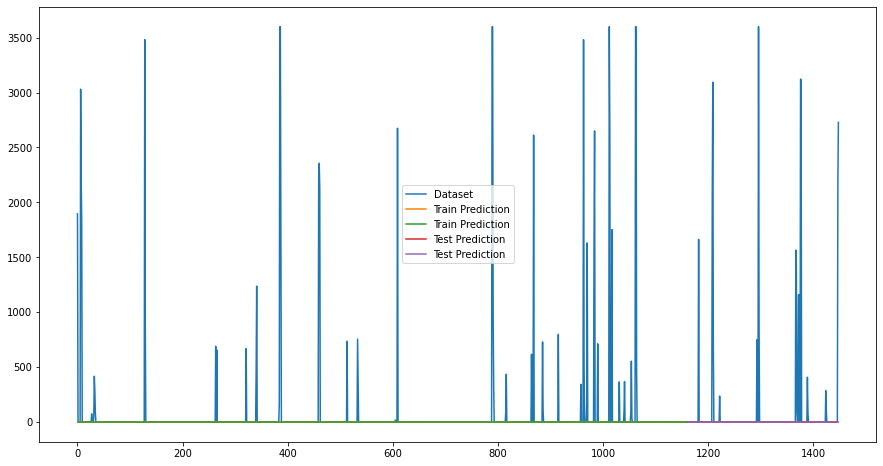

Epoch 1/100
1157/1157 - 2s - loss: -7.5783e-02 - accuracy: 0.0182 - 2s/epoch - 2ms/step
Epoch 2/100
1157/1157 - 1s - loss: -7.7006e-02 - accuracy: 0.0061 - 970ms/epoch - 839us/step
Epoch 3/100
1157/1157 - 1s - loss: -7.7006e-02 - accuracy: 0.0061 - 977ms/epoch - 845us/step
Epoch 4/100
1157/1157 - 1s - loss: -7.7006e-02 - accuracy: 0.0061 - 979ms/epoch - 846us/step
Epoch 5/100
1157/1157 - 1s - loss: -7.7006e-02 - accuracy: 0.0061 - 984ms/epoch - 851us/step
Epoch 6/100
1157/1157 - 1s - loss: -7.7006e-02 - accuracy: 0.0061 - 992ms/epoch - 857us/step
Epoch 7/100
1157/1157 - 1s - loss: -7.7006e-02 - accuracy: 0.0061 - 970ms/epoch - 839us/step
Epoch 8/100
1157/1157 - 1s - loss: -7.7006e-02 - accuracy: 0.0061 - 969ms/epoch - 838us/step
Epoch 9/100
1157/1157 - 1s - loss: -7.7006e-02 - accuracy: 0.0061 - 974ms/epoch - 842us/step
Epoch 10/100
1157/1157 - 1s - loss: -7.7006e-02 - accuracy: 0.0061 - 980ms/epoch - 847us/step
Epoch 11/100
1157/1157 - 1s - loss: -7.7006e-02 - accuracy: 0.0061 - 983ms

Epoch 89/100
1157/1157 - 1s - loss: -7.7006e-02 - accuracy: 0.0061 - 989ms/epoch - 855us/step
Epoch 90/100
1157/1157 - 1s - loss: -7.7006e-02 - accuracy: 0.0061 - 992ms/epoch - 858us/step
Epoch 91/100
1157/1157 - 1s - loss: -7.7006e-02 - accuracy: 0.0061 - 978ms/epoch - 845us/step
Epoch 92/100
1157/1157 - 1s - loss: -7.7006e-02 - accuracy: 0.0061 - 972ms/epoch - 840us/step
Epoch 93/100
1157/1157 - 1s - loss: -7.7006e-02 - accuracy: 0.0061 - 979ms/epoch - 846us/step
Epoch 94/100
1157/1157 - 1s - loss: -7.7006e-02 - accuracy: 0.0061 - 965ms/epoch - 834us/step
Epoch 95/100
1157/1157 - 1s - loss: -7.7006e-02 - accuracy: 0.0061 - 980ms/epoch - 847us/step
Epoch 96/100
1157/1157 - 1s - loss: -7.7006e-02 - accuracy: 0.0061 - 975ms/epoch - 842us/step
Epoch 97/100
1157/1157 - 1s - loss: -7.7006e-02 - accuracy: 0.0061 - 991ms/epoch - 857us/step
Epoch 98/100
1157/1157 - 1s - loss: -7.7006e-02 - accuracy: 0.0061 - 978ms/epoch - 845us/step
Epoch 99/100
1157/1157 - 1s - loss: -7.7006e-02 - accuracy: 

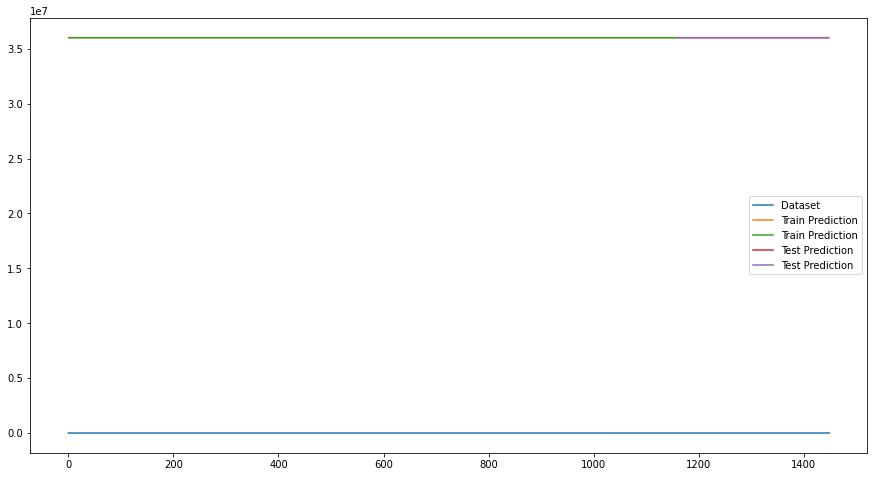

Epoch 1/100
1157/1157 - 2s - loss: -5.3219e-02 - accuracy: 0.6889 - 2s/epoch - 2ms/step
Epoch 2/100
1157/1157 - 1s - loss: -7.2325e-02 - accuracy: 0.7934 - 987ms/epoch - 853us/step
Epoch 3/100
1157/1157 - 1s - loss: -7.6656e-02 - accuracy: 0.6465 - 995ms/epoch - 860us/step
Epoch 4/100
1157/1157 - 1s - loss: -7.6979e-02 - accuracy: 0.5056 - 1s/epoch - 874us/step
Epoch 5/100
1157/1157 - 1s - loss: -7.6980e-02 - accuracy: 0.5782 - 988ms/epoch - 854us/step
Epoch 6/100
1157/1157 - 1s - loss: -7.6985e-02 - accuracy: 0.5791 - 990ms/epoch - 855us/step
Epoch 7/100
1157/1157 - 1s - loss: -7.6983e-02 - accuracy: 0.4901 - 982ms/epoch - 849us/step
Epoch 8/100
1157/1157 - 1s - loss: -7.6989e-02 - accuracy: 0.4529 - 1s/epoch - 866us/step
Epoch 9/100
1157/1157 - 1s - loss: -7.6989e-02 - accuracy: 0.4849 - 987ms/epoch - 853us/step
Epoch 10/100
1157/1157 - 1s - loss: -7.6995e-02 - accuracy: 0.4054 - 993ms/epoch - 858us/step
Epoch 11/100
1157/1157 - 1s - loss: -7.6991e-02 - accuracy: 0.4373 - 986ms/epoch

Epoch 90/100
1157/1157 - 1s - loss: -7.7005e-02 - accuracy: 0.4114 - 986ms/epoch - 852us/step
Epoch 91/100
1157/1157 - 1s - loss: -7.7005e-02 - accuracy: 0.5670 - 1s/epoch - 865us/step
Epoch 92/100
1157/1157 - 1s - loss: -7.7005e-02 - accuracy: 0.4244 - 987ms/epoch - 853us/step
Epoch 93/100
1157/1157 - 1s - loss: -7.7005e-02 - accuracy: 0.5748 - 1s/epoch - 885us/step
Epoch 94/100
1157/1157 - 1s - loss: -7.7005e-02 - accuracy: 0.5488 - 1s/epoch - 878us/step
Epoch 95/100
1157/1157 - 1s - loss: -7.7005e-02 - accuracy: 0.4244 - 1s/epoch - 867us/step
Epoch 96/100
1157/1157 - 1s - loss: -7.7005e-02 - accuracy: 0.5825 - 1s/epoch - 869us/step
Epoch 97/100
1157/1157 - 1s - loss: -7.7005e-02 - accuracy: 0.4045 - 995ms/epoch - 860us/step
Epoch 98/100
1157/1157 - 1s - loss: -7.7005e-02 - accuracy: 0.4736 - 1s/epoch - 870us/step
Epoch 99/100
1157/1157 - 1s - loss: -7.7005e-02 - accuracy: 0.4520 - 1s/epoch - 875us/step
Epoch 100/100
1157/1157 - 1s - loss: -7.7005e-02 - accuracy: 0.4278 - 991ms/epoch

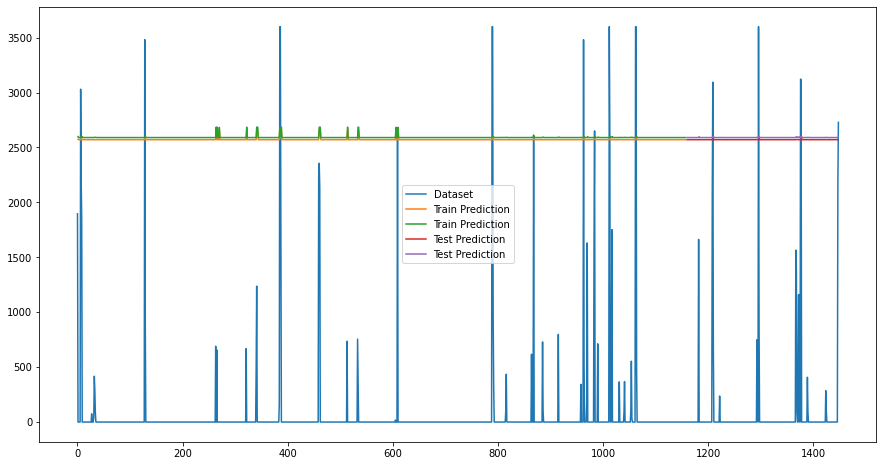

Epoch 1/100
1157/1157 - 2s - loss: -5.9131e-02 - accuracy: 0.0354 - 2s/epoch - 2ms/step
Epoch 2/100
1157/1157 - 1s - loss: -7.5831e-02 - accuracy: 0.1573 - 993ms/epoch - 858us/step
Epoch 3/100
1157/1157 - 1s - loss: -7.6911e-02 - accuracy: 0.9118 - 995ms/epoch - 860us/step
Epoch 4/100
1157/1157 - 1s - loss: -7.6963e-02 - accuracy: 0.5272 - 1s/epoch - 868us/step
Epoch 5/100
1157/1157 - 1s - loss: -7.6913e-02 - accuracy: 0.2126 - 996ms/epoch - 861us/step
Epoch 6/100
1157/1157 - 1s - loss: -7.6983e-02 - accuracy: 0.3717 - 990ms/epoch - 856us/step
Epoch 7/100
1157/1157 - 1s - loss: -7.6954e-02 - accuracy: 0.3881 - 1s/epoch - 867us/step
Epoch 8/100
1157/1157 - 1s - loss: -7.6952e-02 - accuracy: 0.5739 - 989ms/epoch - 855us/step
Epoch 9/100
1157/1157 - 1s - loss: -7.6946e-02 - accuracy: 0.5436 - 988ms/epoch - 854us/step
Epoch 10/100
1157/1157 - 1s - loss: -7.6961e-02 - accuracy: 0.5670 - 996ms/epoch - 861us/step
Epoch 11/100
1157/1157 - 1s - loss: -7.6978e-02 - accuracy: 0.4875 - 1s/epoch - 

Epoch 90/100
1157/1157 - 1s - loss: -7.7004e-02 - accuracy: 0.5099 - 999ms/epoch - 863us/step
Epoch 91/100
1157/1157 - 1s - loss: -7.7003e-02 - accuracy: 0.5169 - 997ms/epoch - 861us/step
Epoch 92/100
1157/1157 - 1s - loss: -7.7005e-02 - accuracy: 0.5264 - 996ms/epoch - 861us/step
Epoch 93/100
1157/1157 - 1s - loss: -7.7004e-02 - accuracy: 0.4883 - 1s/epoch - 870us/step
Epoch 94/100
1157/1157 - 1s - loss: -7.7004e-02 - accuracy: 0.4719 - 983ms/epoch - 850us/step
Epoch 95/100
1157/1157 - 1s - loss: -7.7005e-02 - accuracy: 0.4512 - 1s/epoch - 873us/step
Epoch 96/100
1157/1157 - 1s - loss: -7.7001e-02 - accuracy: 0.4710 - 1s/epoch - 871us/step
Epoch 97/100
1157/1157 - 1s - loss: -7.7005e-02 - accuracy: 0.4235 - 996ms/epoch - 861us/step
Epoch 98/100
1157/1157 - 1s - loss: -7.7004e-02 - accuracy: 0.4710 - 996ms/epoch - 861us/step
Epoch 99/100
1157/1157 - 1s - loss: -7.7005e-02 - accuracy: 0.4287 - 993ms/epoch - 859us/step
Epoch 100/100
1157/1157 - 1s - loss: -7.7004e-02 - accuracy: 0.4252 -

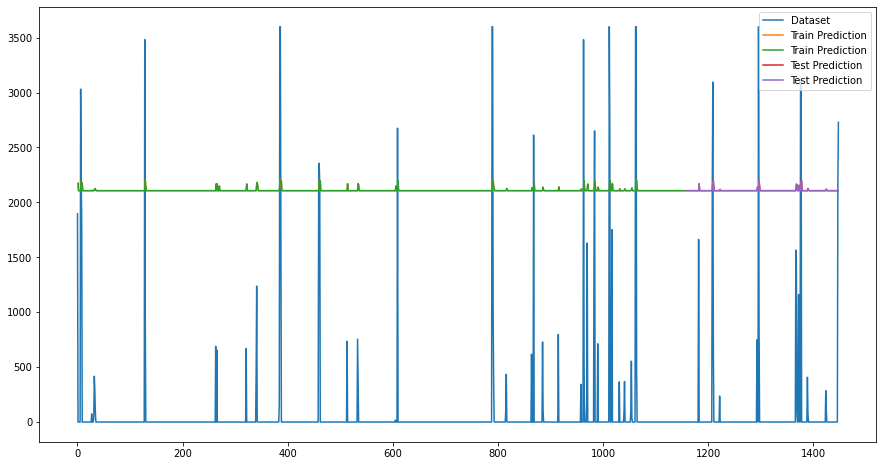

Epoch 1/100
1157/1157 - 2s - loss: -7.3774e-02 - accuracy: 0.4019 - 2s/epoch - 2ms/step
Epoch 2/100
1157/1157 - 1s - loss: -7.5877e-02 - accuracy: 0.4564 - 990ms/epoch - 856us/step
Epoch 3/100
1157/1157 - 1s - loss: -7.6016e-02 - accuracy: 0.4797 - 993ms/epoch - 858us/step
Epoch 4/100
1157/1157 - 1s - loss: -7.6065e-02 - accuracy: 0.4434 - 999ms/epoch - 863us/step
Epoch 5/100
1157/1157 - 1s - loss: -7.6103e-02 - accuracy: 0.4667 - 993ms/epoch - 859us/step
Epoch 6/100
1157/1157 - 1s - loss: -7.6133e-02 - accuracy: 0.5359 - 989ms/epoch - 855us/step
Epoch 7/100
1157/1157 - 1s - loss: -7.6136e-02 - accuracy: 0.6353 - 986ms/epoch - 852us/step
Epoch 8/100
1157/1157 - 1s - loss: -7.6164e-02 - accuracy: 0.6569 - 1s/epoch - 869us/step
Epoch 9/100
1157/1157 - 1s - loss: -7.6143e-02 - accuracy: 0.5635 - 987ms/epoch - 853us/step
Epoch 10/100
1157/1157 - 1s - loss: -7.6188e-02 - accuracy: 0.4062 - 1s/epoch - 865us/step
Epoch 11/100
1157/1157 - 1s - loss: -7.6196e-02 - accuracy: 0.4978 - 992ms/epoch

Epoch 89/100
1157/1157 - 1s - loss: -7.6525e-02 - accuracy: 0.5324 - 993ms/epoch - 858us/step
Epoch 90/100
1157/1157 - 1s - loss: -7.6528e-02 - accuracy: 0.5177 - 1s/epoch - 868us/step
Epoch 91/100
1157/1157 - 1s - loss: -7.6529e-02 - accuracy: 0.6361 - 991ms/epoch - 857us/step
Epoch 92/100
1157/1157 - 1s - loss: -7.6533e-02 - accuracy: 0.4088 - 993ms/epoch - 859us/step
Epoch 93/100
1157/1157 - 1s - loss: -7.6535e-02 - accuracy: 0.5869 - 995ms/epoch - 860us/step
Epoch 94/100
1157/1157 - 1s - loss: -7.6539e-02 - accuracy: 0.5117 - 990ms/epoch - 856us/step
Epoch 95/100
1157/1157 - 1s - loss: -7.6537e-02 - accuracy: 0.6482 - 997ms/epoch - 862us/step
Epoch 96/100
1157/1157 - 1s - loss: -7.6543e-02 - accuracy: 0.5091 - 998ms/epoch - 862us/step
Epoch 97/100
1157/1157 - 1s - loss: -7.6545e-02 - accuracy: 0.5428 - 990ms/epoch - 856us/step
Epoch 98/100
1157/1157 - 1s - loss: -7.6548e-02 - accuracy: 0.4589 - 991ms/epoch - 856us/step
Epoch 99/100
1157/1157 - 1s - loss: -7.6551e-02 - accuracy: 0.6

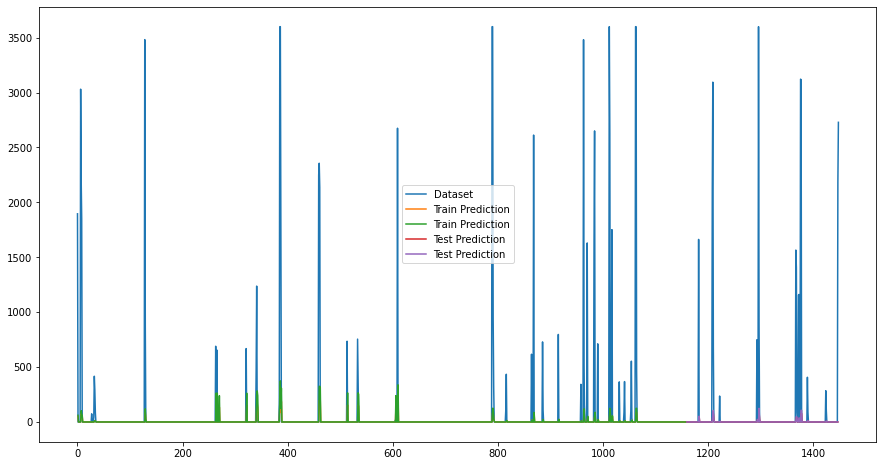

Epoch 1/100
1157/1157 - 2s - loss: -7.2576e-02 - accuracy: 0.0570 - 2s/epoch - 2ms/step
Epoch 2/100
1157/1157 - 1s - loss: -7.4398e-02 - accuracy: 0.0303 - 980ms/epoch - 847us/step
Epoch 3/100
1157/1157 - 1s - loss: -7.4749e-02 - accuracy: 0.0303 - 987ms/epoch - 853us/step
Epoch 4/100
1157/1157 - 1s - loss: -7.5006e-02 - accuracy: 0.0303 - 978ms/epoch - 845us/step
Epoch 5/100
1157/1157 - 1s - loss: -7.5208e-02 - accuracy: 0.0303 - 977ms/epoch - 845us/step
Epoch 6/100
1157/1157 - 1s - loss: -7.5374e-02 - accuracy: 0.0303 - 981ms/epoch - 848us/step
Epoch 7/100
1157/1157 - 1s - loss: -7.5513e-02 - accuracy: 0.0303 - 989ms/epoch - 855us/step
Epoch 8/100
1157/1157 - 1s - loss: -7.5633e-02 - accuracy: 0.0303 - 1s/epoch - 872us/step
Epoch 9/100
1157/1157 - 1s - loss: -7.5737e-02 - accuracy: 0.0303 - 979ms/epoch - 846us/step
Epoch 10/100
1157/1157 - 1s - loss: -7.5829e-02 - accuracy: 0.0303 - 981ms/epoch - 848us/step
Epoch 11/100
1157/1157 - 1s - loss: -7.5910e-02 - accuracy: 0.0303 - 984ms/ep

Epoch 89/100
1157/1157 - 1s - loss: -7.6896e-02 - accuracy: 0.0121 - 990ms/epoch - 856us/step
Epoch 90/100
1157/1157 - 1s - loss: -7.6898e-02 - accuracy: 0.0121 - 961ms/epoch - 830us/step
Epoch 91/100
1157/1157 - 1s - loss: -7.6899e-02 - accuracy: 0.0121 - 987ms/epoch - 853us/step
Epoch 92/100
1157/1157 - 1s - loss: -7.6900e-02 - accuracy: 0.0138 - 978ms/epoch - 845us/step
Epoch 93/100
1157/1157 - 1s - loss: -7.6901e-02 - accuracy: 0.0138 - 983ms/epoch - 850us/step
Epoch 94/100
1157/1157 - 1s - loss: -7.6901e-02 - accuracy: 0.0138 - 992ms/epoch - 857us/step
Epoch 95/100
1157/1157 - 1s - loss: -7.6902e-02 - accuracy: 0.0138 - 990ms/epoch - 856us/step
Epoch 96/100
1157/1157 - 1s - loss: -7.6903e-02 - accuracy: 0.0138 - 983ms/epoch - 849us/step
Epoch 97/100
1157/1157 - 1s - loss: -7.6904e-02 - accuracy: 0.0138 - 982ms/epoch - 849us/step
Epoch 98/100
1157/1157 - 1s - loss: -7.6905e-02 - accuracy: 0.0138 - 977ms/epoch - 844us/step
Epoch 99/100
1157/1157 - 1s - loss: -7.6906e-02 - accuracy: 

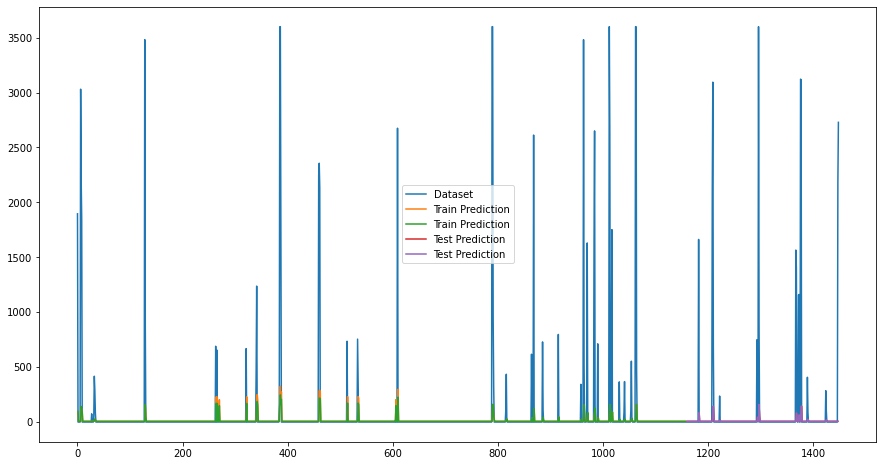

Epoch 1/100
1157/1157 - 2s - loss: -7.3058e-02 - accuracy: 0.7243 - 2s/epoch - 2ms/step
Epoch 2/100
1157/1157 - 1s - loss: -7.6475e-02 - accuracy: 0.5635 - 1s/epoch - 870us/step
Epoch 3/100
1157/1157 - 1s - loss: -7.6551e-02 - accuracy: 0.2826 - 1s/epoch - 872us/step
Epoch 4/100
1157/1157 - 1s - loss: -7.6659e-02 - accuracy: 0.4226 - 1s/epoch - 868us/step
Epoch 5/100
1157/1157 - 1s - loss: -7.6745e-02 - accuracy: 0.5834 - 1s/epoch - 868us/step
Epoch 6/100
1157/1157 - 1s - loss: -7.6792e-02 - accuracy: 0.4736 - 1s/epoch - 866us/step
Epoch 7/100
1157/1157 - 1s - loss: -7.6837e-02 - accuracy: 0.3725 - 1s/epoch - 871us/step
Epoch 8/100
1157/1157 - 1s - loss: -7.6885e-02 - accuracy: 0.4356 - 1s/epoch - 873us/step
Epoch 9/100
1157/1157 - 1s - loss: -7.6910e-02 - accuracy: 0.4105 - 1s/epoch - 871us/step
Epoch 10/100
1157/1157 - 1s - loss: -7.6926e-02 - accuracy: 0.3371 - 1s/epoch - 876us/step
Epoch 11/100
1157/1157 - 1s - loss: -7.6939e-02 - accuracy: 0.3803 - 1s/epoch - 870us/step
Epoch 12/1

Epoch 92/100
1157/1157 - 1s - loss: -7.7002e-02 - accuracy: 0.5117 - 1s/epoch - 887us/step
Epoch 93/100
1157/1157 - 1s - loss: -7.7004e-02 - accuracy: 0.4451 - 1s/epoch - 878us/step
Epoch 94/100
1157/1157 - 1s - loss: -7.7004e-02 - accuracy: 0.4572 - 1s/epoch - 874us/step
Epoch 95/100
1157/1157 - 1s - loss: -7.7003e-02 - accuracy: 0.5851 - 1s/epoch - 867us/step
Epoch 96/100
1157/1157 - 1s - loss: -7.7003e-02 - accuracy: 0.4909 - 1s/epoch - 866us/step
Epoch 97/100
1157/1157 - 1s - loss: -7.7004e-02 - accuracy: 0.3630 - 1s/epoch - 899us/step
Epoch 98/100
1157/1157 - 1s - loss: -7.7003e-02 - accuracy: 0.4244 - 1s/epoch - 869us/step
Epoch 99/100
1157/1157 - 1s - loss: -7.7003e-02 - accuracy: 0.4814 - 1s/epoch - 874us/step
Epoch 100/100
1157/1157 - 1s - loss: -7.7002e-02 - accuracy: 0.4157 - 1s/epoch - 870us/step
Train Score: 403.50 RMSE
Test Score: 455.23 RMSE


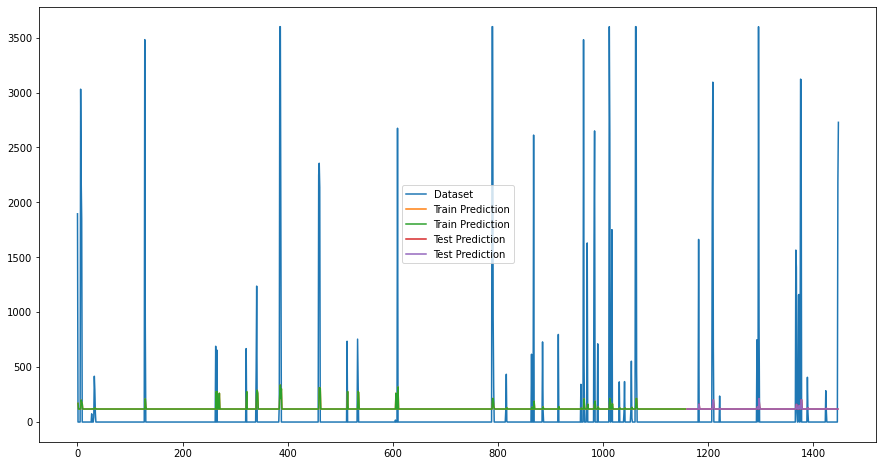

Epoch 1/100
1157/1157 - 2s - loss: -7.2283e-02 - accuracy: 0.6966 - 2s/epoch - 2ms/step
Epoch 2/100
1157/1157 - 1s - loss: -7.6859e-02 - accuracy: 0.5635 - 1s/epoch - 893us/step
Epoch 3/100
1157/1157 - 1s - loss: -7.6943e-02 - accuracy: 0.4218 - 1s/epoch - 903us/step
Epoch 4/100
1157/1157 - 1s - loss: -7.6917e-02 - accuracy: 0.4987 - 1s/epoch - 916us/step
Epoch 5/100
1157/1157 - 1s - loss: -7.6974e-02 - accuracy: 0.3786 - 1s/epoch - 919us/step
Epoch 6/100
1157/1157 - 1s - loss: -7.6940e-02 - accuracy: 0.5125 - 1s/epoch - 915us/step
Epoch 7/100
1157/1157 - 1s - loss: -7.6885e-02 - accuracy: 0.3544 - 1s/epoch - 911us/step
Epoch 8/100
1157/1157 - 1s - loss: -7.6998e-02 - accuracy: 0.4140 - 1s/epoch - 890us/step
Epoch 9/100
1157/1157 - 1s - loss: -7.6969e-02 - accuracy: 0.4572 - 1s/epoch - 902us/step
Epoch 10/100
1157/1157 - 1s - loss: -7.6994e-02 - accuracy: 0.3673 - 1s/epoch - 894us/step
Epoch 11/100
1157/1157 - 1s - loss: -7.6983e-02 - accuracy: 0.5298 - 1s/epoch - 896us/step
Epoch 12/1

Epoch 92/100
1157/1157 - 1s - loss: -7.7005e-02 - accuracy: 0.4831 - 1s/epoch - 904us/step
Epoch 93/100
1157/1157 - 1s - loss: -7.7005e-02 - accuracy: 0.5385 - 1s/epoch - 904us/step
Epoch 94/100
1157/1157 - 1s - loss: -7.7004e-02 - accuracy: 0.4036 - 1s/epoch - 890us/step
Epoch 95/100
1157/1157 - 1s - loss: -7.7006e-02 - accuracy: 0.4175 - 1s/epoch - 891us/step
Epoch 96/100
1157/1157 - 1s - loss: -7.7005e-02 - accuracy: 0.4935 - 1s/epoch - 910us/step
Epoch 97/100
1157/1157 - 1s - loss: -7.7005e-02 - accuracy: 0.5298 - 1s/epoch - 889us/step
Epoch 98/100
1157/1157 - 1s - loss: -7.7005e-02 - accuracy: 0.4546 - 1s/epoch - 894us/step
Epoch 99/100
1157/1157 - 1s - loss: -7.7005e-02 - accuracy: 0.3639 - 1s/epoch - 910us/step
Epoch 100/100
1157/1157 - 1s - loss: -7.7005e-02 - accuracy: 0.4054 - 1s/epoch - 943us/step
Train Score: 2715.11 RMSE
Test Score: 2693.06 RMSE


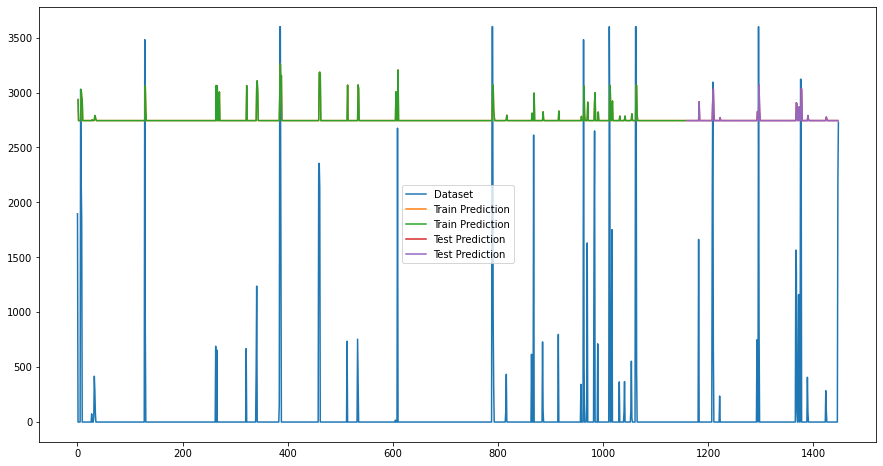

Epoch 1/100
1157/1157 - 3s - loss: -7.5783e-02 - accuracy: 0.9455 - 3s/epoch - 2ms/step
Epoch 2/100
1157/1157 - 1s - loss: -7.7006e-02 - accuracy: 0.9455 - 1s/epoch - 872us/step
Epoch 3/100
1157/1157 - 1s - loss: -7.7006e-02 - accuracy: 0.9455 - 1s/epoch - 890us/step
Epoch 4/100
1157/1157 - 1s - loss: -7.7006e-02 - accuracy: 0.9455 - 1s/epoch - 871us/step
Epoch 5/100
1157/1157 - 1s - loss: -7.7006e-02 - accuracy: 0.9455 - 1s/epoch - 872us/step
Epoch 6/100
1157/1157 - 1s - loss: -7.7006e-02 - accuracy: 0.9455 - 1s/epoch - 868us/step
Epoch 7/100
1157/1157 - 1s - loss: -7.7006e-02 - accuracy: 0.9455 - 1s/epoch - 871us/step
Epoch 8/100
1157/1157 - 1s - loss: -7.7006e-02 - accuracy: 0.9455 - 1s/epoch - 895us/step
Epoch 9/100
1157/1157 - 1s - loss: -7.7006e-02 - accuracy: 0.9455 - 990ms/epoch - 856us/step
Epoch 10/100
1157/1157 - 1s - loss: -7.7006e-02 - accuracy: 0.9455 - 1s/epoch - 874us/step
Epoch 11/100
1157/1157 - 1s - loss: -7.7006e-02 - accuracy: 0.9455 - 1s/epoch - 869us/step
Epoch 1

Epoch 91/100
1157/1157 - 1s - loss: -7.7006e-02 - accuracy: 0.9455 - 991ms/epoch - 857us/step
Epoch 92/100
1157/1157 - 1s - loss: -7.7006e-02 - accuracy: 0.9455 - 1s/epoch - 879us/step
Epoch 93/100
1157/1157 - 1s - loss: -7.7006e-02 - accuracy: 0.9455 - 1s/epoch - 868us/step
Epoch 94/100
1157/1157 - 1s - loss: -7.7006e-02 - accuracy: 0.9455 - 999ms/epoch - 864us/step
Epoch 95/100
1157/1157 - 1s - loss: -7.7006e-02 - accuracy: 0.9455 - 999ms/epoch - 864us/step
Epoch 96/100
1157/1157 - 1s - loss: -7.7006e-02 - accuracy: 0.9455 - 1s/epoch - 878us/step
Epoch 97/100
1157/1157 - 1s - loss: -7.7006e-02 - accuracy: 0.9455 - 1s/epoch - 867us/step
Epoch 98/100
1157/1157 - 1s - loss: -7.7006e-02 - accuracy: 0.9455 - 1s/epoch - 884us/step
Epoch 99/100
1157/1157 - 1s - loss: -7.7006e-02 - accuracy: 0.9455 - 1s/epoch - 866us/step
Epoch 100/100
1157/1157 - 1s - loss: -7.7006e-02 - accuracy: 0.9455 - 999ms/epoch - 864us/step
Train Score: 412.82 RMSE
Test Score: 468.82 RMSE


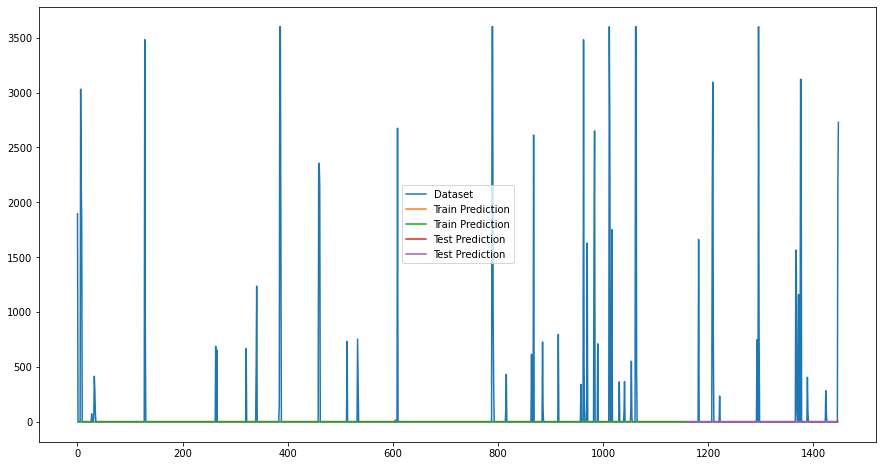

Epoch 1/100
1157/1157 - 2s - loss: 0.0071 - accuracy: 0.0622 - 2s/epoch - 2ms/step
Epoch 2/100
1157/1157 - 1s - loss: 0.0070 - accuracy: 0.0277 - 984ms/epoch - 851us/step
Epoch 3/100
1157/1157 - 1s - loss: 0.0070 - accuracy: 0.0268 - 979ms/epoch - 846us/step
Epoch 4/100
1157/1157 - 1s - loss: 0.0069 - accuracy: 0.0277 - 968ms/epoch - 837us/step
Epoch 5/100
1157/1157 - 1s - loss: 0.0069 - accuracy: 0.0285 - 986ms/epoch - 852us/step
Epoch 6/100
1157/1157 - 1s - loss: 0.0069 - accuracy: 0.0268 - 983ms/epoch - 849us/step
Epoch 7/100
1157/1157 - 1s - loss: 0.0068 - accuracy: 0.0268 - 976ms/epoch - 844us/step
Epoch 8/100
1157/1157 - 1s - loss: 0.0068 - accuracy: 0.0268 - 982ms/epoch - 848us/step
Epoch 9/100
1157/1157 - 1s - loss: 0.0067 - accuracy: 0.0277 - 976ms/epoch - 844us/step
Epoch 10/100
1157/1157 - 1s - loss: 0.0067 - accuracy: 0.0277 - 987ms/epoch - 853us/step
Epoch 11/100
1157/1157 - 1s - loss: 0.0067 - accuracy: 0.0268 - 976ms/epoch - 843us/step
Epoch 12/100
1157/1157 - 1s - loss:

Epoch 94/100
1157/1157 - 1s - loss: 0.0056 - accuracy: 0.0277 - 983ms/epoch - 850us/step
Epoch 95/100
1157/1157 - 1s - loss: 0.0056 - accuracy: 0.1167 - 981ms/epoch - 848us/step
Epoch 96/100
1157/1157 - 1s - loss: 0.0056 - accuracy: 0.0778 - 967ms/epoch - 836us/step
Epoch 97/100
1157/1157 - 1s - loss: 0.0056 - accuracy: 0.0441 - 989ms/epoch - 855us/step
Epoch 98/100
1157/1157 - 1s - loss: 0.0056 - accuracy: 0.1314 - 988ms/epoch - 854us/step
Epoch 99/100
1157/1157 - 1s - loss: 0.0056 - accuracy: 0.0977 - 971ms/epoch - 840us/step
Epoch 100/100
1157/1157 - 1s - loss: 0.0056 - accuracy: 0.0553 - 961ms/epoch - 831us/step
Train Score: 381.36 RMSE
Test Score: 442.90 RMSE


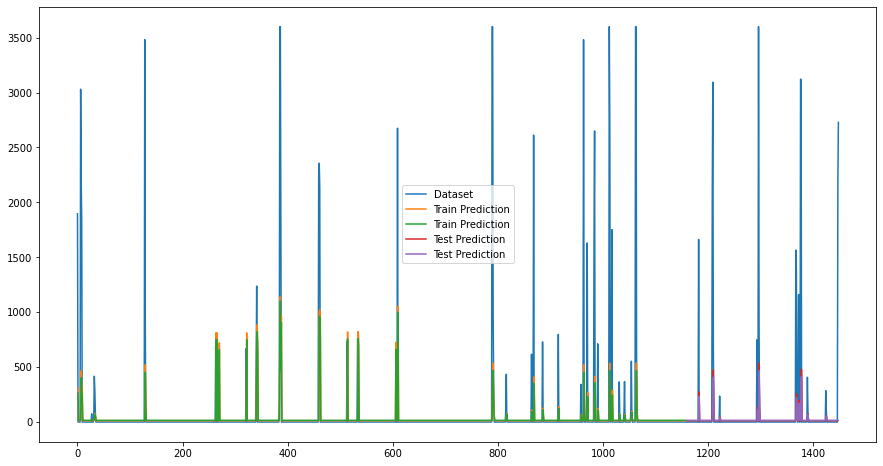

Epoch 1/100
1157/1157 - 2s - loss: 0.0063 - accuracy: 0.5756 - 2s/epoch - 2ms/step
Epoch 2/100
1157/1157 - 1s - loss: 0.0063 - accuracy: 0.7226 - 981ms/epoch - 848us/step
Epoch 3/100
1157/1157 - 1s - loss: 0.0062 - accuracy: 0.6085 - 997ms/epoch - 861us/step
Epoch 4/100
1157/1157 - 1s - loss: 0.0061 - accuracy: 0.6050 - 979ms/epoch - 846us/step
Epoch 5/100
1157/1157 - 1s - loss: 0.0061 - accuracy: 0.5687 - 984ms/epoch - 851us/step
Epoch 6/100
1157/1157 - 1s - loss: 0.0060 - accuracy: 0.5134 - 991ms/epoch - 856us/step
Epoch 7/100
1157/1157 - 1s - loss: 0.0060 - accuracy: 0.5385 - 982ms/epoch - 849us/step
Epoch 8/100
1157/1157 - 1s - loss: 0.0060 - accuracy: 0.5687 - 987ms/epoch - 853us/step
Epoch 9/100
1157/1157 - 1s - loss: 0.0059 - accuracy: 0.6197 - 976ms/epoch - 844us/step
Epoch 10/100
1157/1157 - 1s - loss: 0.0059 - accuracy: 0.4641 - 979ms/epoch - 846us/step
Epoch 11/100
1157/1157 - 1s - loss: 0.0060 - accuracy: 0.6102 - 1s/epoch - 865us/step
Epoch 12/100
1157/1157 - 1s - loss: 0.

Epoch 94/100
1157/1157 - 1s - loss: 0.0057 - accuracy: 0.4667 - 985ms/epoch - 851us/step
Epoch 95/100
1157/1157 - 1s - loss: 0.0056 - accuracy: 0.4304 - 991ms/epoch - 856us/step
Epoch 96/100
1157/1157 - 1s - loss: 0.0057 - accuracy: 0.4304 - 985ms/epoch - 852us/step
Epoch 97/100
1157/1157 - 1s - loss: 0.0056 - accuracy: 0.4633 - 977ms/epoch - 845us/step
Epoch 98/100
1157/1157 - 1s - loss: 0.0058 - accuracy: 0.4149 - 994ms/epoch - 859us/step
Epoch 99/100
1157/1157 - 1s - loss: 0.0057 - accuracy: 0.4296 - 987ms/epoch - 853us/step
Epoch 100/100
1157/1157 - 1s - loss: 0.0056 - accuracy: 0.4840 - 987ms/epoch - 853us/step
Train Score: 381.27 RMSE
Test Score: 439.69 RMSE


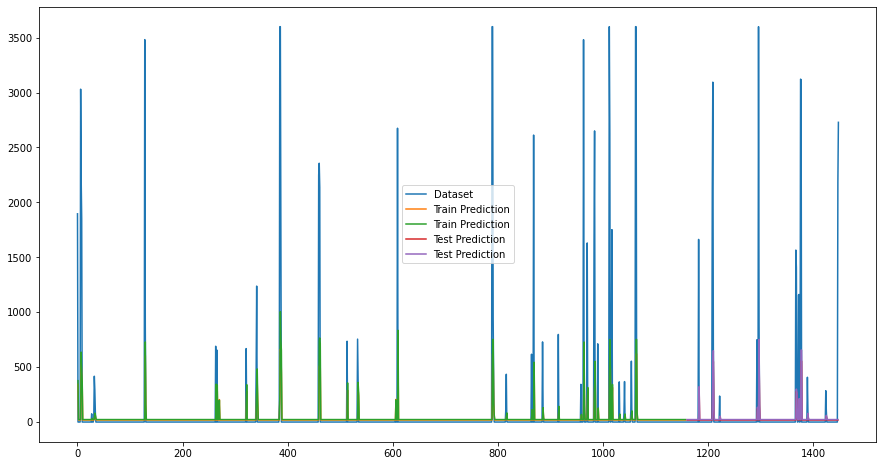

Epoch 1/100
1157/1157 - 2s - loss: 0.0062 - accuracy: 0.8712 - 2s/epoch - 2ms/step
Epoch 2/100
1157/1157 - 1s - loss: 0.0058 - accuracy: 0.6681 - 996ms/epoch - 860us/step
Epoch 3/100
1157/1157 - 1s - loss: 0.0055 - accuracy: 0.7148 - 1s/epoch - 870us/step
Epoch 4/100
1157/1157 - 1s - loss: 0.0054 - accuracy: 0.6612 - 1s/epoch - 865us/step
Epoch 5/100
1157/1157 - 1s - loss: 0.0054 - accuracy: 0.5341 - 995ms/epoch - 860us/step
Epoch 6/100
1157/1157 - 1s - loss: 0.0053 - accuracy: 0.4373 - 1s/epoch - 865us/step
Epoch 7/100
1157/1157 - 1s - loss: 0.0053 - accuracy: 0.4218 - 992ms/epoch - 857us/step
Epoch 8/100
1157/1157 - 1s - loss: 0.0053 - accuracy: 0.5315 - 1s/epoch - 867us/step
Epoch 9/100
1157/1157 - 1s - loss: 0.0052 - accuracy: 0.4365 - 1s/epoch - 866us/step
Epoch 10/100
1157/1157 - 1s - loss: 0.0052 - accuracy: 0.3907 - 1s/epoch - 866us/step
Epoch 11/100
1157/1157 - 1s - loss: 0.0052 - accuracy: 0.3034 - 996ms/epoch - 861us/step
Epoch 12/100
1157/1157 - 1s - loss: 0.0051 - accuracy

1157/1157 - 1s - loss: 0.0050 - accuracy: 0.5748 - 992ms/epoch - 858us/step
Epoch 96/100
1157/1157 - 1s - loss: 0.0050 - accuracy: 0.4693 - 999ms/epoch - 864us/step
Epoch 97/100
1157/1157 - 1s - loss: 0.0051 - accuracy: 0.5696 - 988ms/epoch - 854us/step
Epoch 98/100
1157/1157 - 1s - loss: 0.0050 - accuracy: 0.6024 - 1000ms/epoch - 864us/step
Epoch 99/100
1157/1157 - 1s - loss: 0.0050 - accuracy: 0.5497 - 993ms/epoch - 859us/step
Epoch 100/100
1157/1157 - 1s - loss: 0.0050 - accuracy: 0.4952 - 1s/epoch - 865us/step
Train Score: 357.81 RMSE
Test Score: 430.42 RMSE


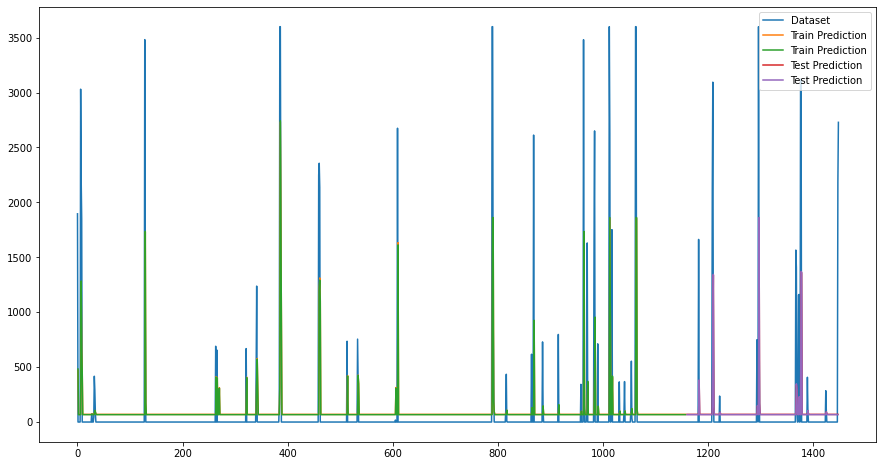

Epoch 1/100
1157/1157 - 2s - loss: 0.0071 - accuracy: 0.8669 - 2s/epoch - 2ms/step
Epoch 2/100
1157/1157 - 1s - loss: 0.0071 - accuracy: 0.9205 - 989ms/epoch - 855us/step
Epoch 3/100
1157/1157 - 1s - loss: 0.0071 - accuracy: 0.9213 - 994ms/epoch - 859us/step
Epoch 4/100
1157/1157 - 1s - loss: 0.0071 - accuracy: 0.9213 - 990ms/epoch - 856us/step
Epoch 5/100
1157/1157 - 1s - loss: 0.0071 - accuracy: 0.9213 - 989ms/epoch - 855us/step
Epoch 6/100
1157/1157 - 1s - loss: 0.0071 - accuracy: 0.9213 - 988ms/epoch - 854us/step
Epoch 7/100
1157/1157 - 1s - loss: 0.0071 - accuracy: 0.9213 - 989ms/epoch - 855us/step
Epoch 8/100
1157/1157 - 1s - loss: 0.0071 - accuracy: 0.9213 - 991ms/epoch - 857us/step
Epoch 9/100
1157/1157 - 1s - loss: 0.0071 - accuracy: 0.9213 - 981ms/epoch - 848us/step
Epoch 10/100
1157/1157 - 1s - loss: 0.0071 - accuracy: 0.9213 - 996ms/epoch - 861us/step
Epoch 11/100
1157/1157 - 1s - loss: 0.0071 - accuracy: 0.9213 - 987ms/epoch - 853us/step
Epoch 12/100
1157/1157 - 1s - loss:

Epoch 94/100
1157/1157 - 1s - loss: 0.0070 - accuracy: 0.9231 - 1s/epoch - 866us/step
Epoch 95/100
1157/1157 - 1s - loss: 0.0070 - accuracy: 0.9231 - 997ms/epoch - 862us/step
Epoch 96/100
1157/1157 - 1s - loss: 0.0070 - accuracy: 0.9231 - 982ms/epoch - 849us/step
Epoch 97/100
1157/1157 - 1s - loss: 0.0070 - accuracy: 0.9231 - 981ms/epoch - 848us/step
Epoch 98/100
1157/1157 - 1s - loss: 0.0070 - accuracy: 0.9231 - 983ms/epoch - 850us/step
Epoch 99/100
1157/1157 - 1s - loss: 0.0070 - accuracy: 0.9231 - 987ms/epoch - 853us/step
Epoch 100/100
1157/1157 - 1s - loss: 0.0070 - accuracy: 0.9231 - 982ms/epoch - 849us/step
Train Score: 441.16 RMSE
Test Score: 478.33 RMSE


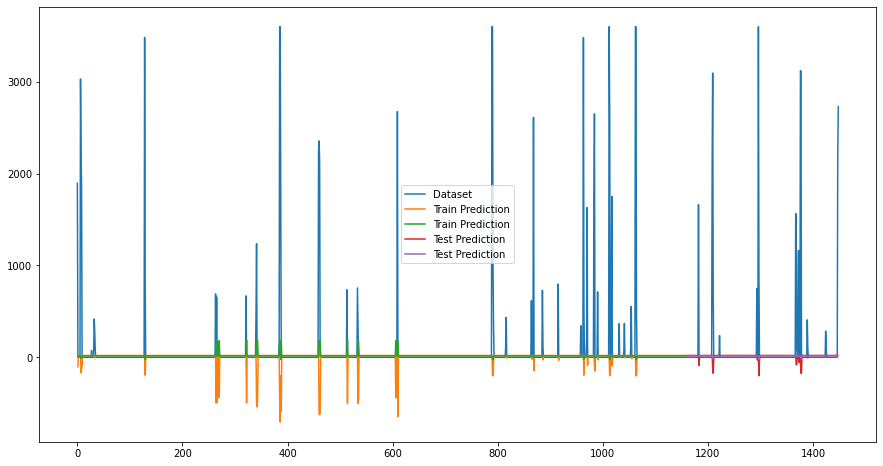

Epoch 1/100
1157/1157 - 2s - loss: 0.0063 - accuracy: 0.9231 - 2s/epoch - 2ms/step
Epoch 2/100
1157/1157 - 1s - loss: 0.0062 - accuracy: 0.9248 - 984ms/epoch - 850us/step
Epoch 3/100
1157/1157 - 1s - loss: 0.0062 - accuracy: 0.9248 - 988ms/epoch - 854us/step
Epoch 4/100
1157/1157 - 1s - loss: 0.0062 - accuracy: 0.9248 - 985ms/epoch - 851us/step
Epoch 5/100
1157/1157 - 1s - loss: 0.0062 - accuracy: 0.9248 - 985ms/epoch - 851us/step
Epoch 6/100
1157/1157 - 1s - loss: 0.0062 - accuracy: 0.9248 - 988ms/epoch - 854us/step
Epoch 7/100
1157/1157 - 1s - loss: 0.0062 - accuracy: 0.9248 - 983ms/epoch - 849us/step
Epoch 8/100
1157/1157 - 1s - loss: 0.0062 - accuracy: 0.9248 - 994ms/epoch - 860us/step
Epoch 9/100
1157/1157 - 1s - loss: 0.0062 - accuracy: 0.9248 - 991ms/epoch - 856us/step
Epoch 10/100
1157/1157 - 1s - loss: 0.0061 - accuracy: 0.9248 - 980ms/epoch - 847us/step
Epoch 11/100
1157/1157 - 1s - loss: 0.0061 - accuracy: 0.9248 - 983ms/epoch - 850us/step
Epoch 12/100
1157/1157 - 1s - loss:

Epoch 94/100
1157/1157 - 1s - loss: 0.0059 - accuracy: 0.9248 - 973ms/epoch - 841us/step
Epoch 95/100
1157/1157 - 1s - loss: 0.0059 - accuracy: 0.9248 - 1s/epoch - 881us/step
Epoch 96/100
1157/1157 - 1s - loss: 0.0059 - accuracy: 0.9248 - 1s/epoch - 866us/step
Epoch 97/100
1157/1157 - 1s - loss: 0.0059 - accuracy: 0.9248 - 979ms/epoch - 846us/step
Epoch 98/100
1157/1157 - 1s - loss: 0.0059 - accuracy: 0.9248 - 991ms/epoch - 857us/step
Epoch 99/100
1157/1157 - 1s - loss: 0.0059 - accuracy: 0.9248 - 978ms/epoch - 845us/step
Epoch 100/100
1157/1157 - 1s - loss: 0.0059 - accuracy: 0.9248 - 966ms/epoch - 835us/step
Train Score: 399.06 RMSE
Test Score: 454.56 RMSE


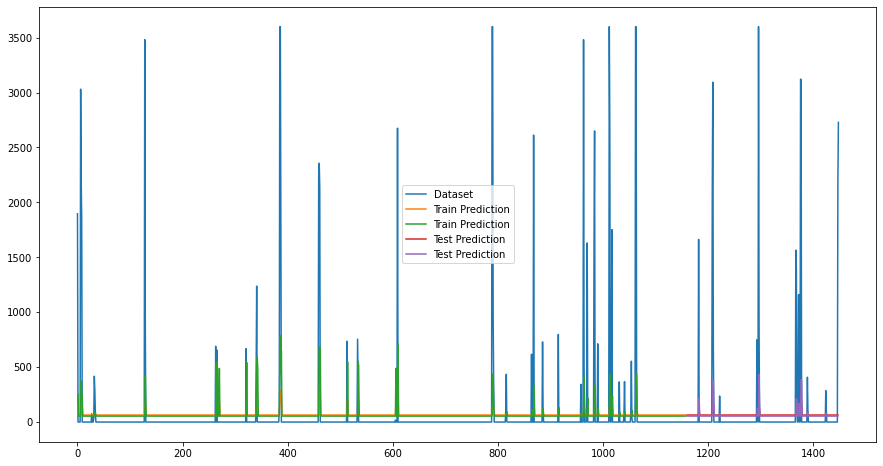

Epoch 1/100
1157/1157 - 2s - loss: 0.0075 - accuracy: 0.0320 - 2s/epoch - 2ms/step
Epoch 2/100
1157/1157 - 1s - loss: 0.0073 - accuracy: 0.0277 - 1s/epoch - 915us/step
Epoch 3/100
1157/1157 - 1s - loss: 0.0072 - accuracy: 0.0268 - 1s/epoch - 875us/step
Epoch 4/100
1157/1157 - 1s - loss: 0.0071 - accuracy: 0.0285 - 1s/epoch - 868us/step
Epoch 5/100
1157/1157 - 1s - loss: 0.0070 - accuracy: 0.0268 - 1s/epoch - 870us/step
Epoch 6/100
1157/1157 - 1s - loss: 0.0070 - accuracy: 0.0285 - 998ms/epoch - 863us/step
Epoch 7/100
1157/1157 - 1s - loss: 0.0069 - accuracy: 0.0268 - 998ms/epoch - 863us/step
Epoch 8/100
1157/1157 - 1s - loss: 0.0068 - accuracy: 0.0277 - 1s/epoch - 868us/step
Epoch 9/100
1157/1157 - 1s - loss: 0.0068 - accuracy: 0.0277 - 1s/epoch - 872us/step
Epoch 10/100
1157/1157 - 1s - loss: 0.0067 - accuracy: 0.0285 - 1s/epoch - 870us/step
Epoch 11/100
1157/1157 - 1s - loss: 0.0067 - accuracy: 0.0277 - 1s/epoch - 865us/step
Epoch 12/100
1157/1157 - 1s - loss: 0.0067 - accuracy: 0.02

Epoch 96/100
1157/1157 - 1s - loss: 0.0053 - accuracy: 0.0156 - 1s/epoch - 924us/step
Epoch 97/100
1157/1157 - 1s - loss: 0.0053 - accuracy: 0.0216 - 1s/epoch - 887us/step
Epoch 98/100
1157/1157 - 1s - loss: 0.0053 - accuracy: 0.0562 - 1s/epoch - 867us/step
Epoch 99/100
1157/1157 - 1s - loss: 0.0053 - accuracy: 0.0294 - 1s/epoch - 869us/step
Epoch 100/100
1157/1157 - 1s - loss: 0.0053 - accuracy: 0.0545 - 1s/epoch - 874us/step
Train Score: 371.11 RMSE
Test Score: 426.72 RMSE


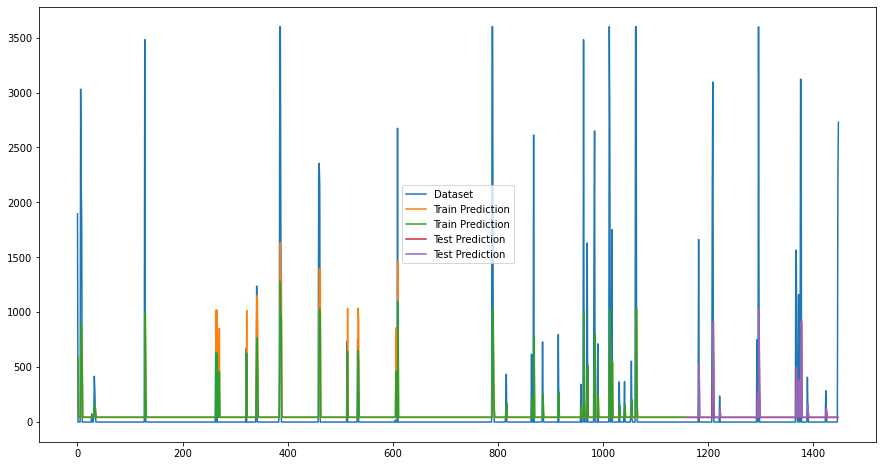

Epoch 1/100
1157/1157 - 2s - loss: 0.0062 - accuracy: 0.1746 - 2s/epoch - 2ms/step
Epoch 2/100
1157/1157 - 1s - loss: 0.0058 - accuracy: 0.2498 - 1s/epoch - 891us/step
Epoch 3/100
1157/1157 - 1s - loss: 0.0056 - accuracy: 0.3060 - 1s/epoch - 900us/step
Epoch 4/100
1157/1157 - 1s - loss: 0.0055 - accuracy: 0.3302 - 1s/epoch - 893us/step
Epoch 5/100
1157/1157 - 1s - loss: 0.0054 - accuracy: 0.4538 - 1s/epoch - 886us/step
Epoch 6/100
1157/1157 - 1s - loss: 0.0053 - accuracy: 0.3475 - 1s/epoch - 884us/step
Epoch 7/100
1157/1157 - 1s - loss: 0.0053 - accuracy: 0.3794 - 1s/epoch - 896us/step
Epoch 8/100
1157/1157 - 1s - loss: 0.0053 - accuracy: 0.4097 - 1s/epoch - 885us/step
Epoch 9/100
1157/1157 - 1s - loss: 0.0053 - accuracy: 0.3621 - 1s/epoch - 892us/step
Epoch 10/100
1157/1157 - 1s - loss: 0.0053 - accuracy: 0.3898 - 1s/epoch - 939us/step
Epoch 11/100
1157/1157 - 1s - loss: 0.0053 - accuracy: 0.4114 - 1s/epoch - 909us/step
Epoch 12/100
1157/1157 - 1s - loss: 0.0053 - accuracy: 0.3829 - 1

Epoch 97/100
1157/1157 - 1s - loss: 0.0050 - accuracy: 0.4875 - 1s/epoch - 886us/step
Epoch 98/100
1157/1157 - 1s - loss: 0.0051 - accuracy: 0.4607 - 1s/epoch - 893us/step
Epoch 99/100
1157/1157 - 1s - loss: 0.0051 - accuracy: 0.5177 - 1s/epoch - 887us/step
Epoch 100/100
1157/1157 - 1s - loss: 0.0050 - accuracy: 0.4278 - 1s/epoch - 891us/step
Train Score: 361.21 RMSE
Test Score: 430.76 RMSE


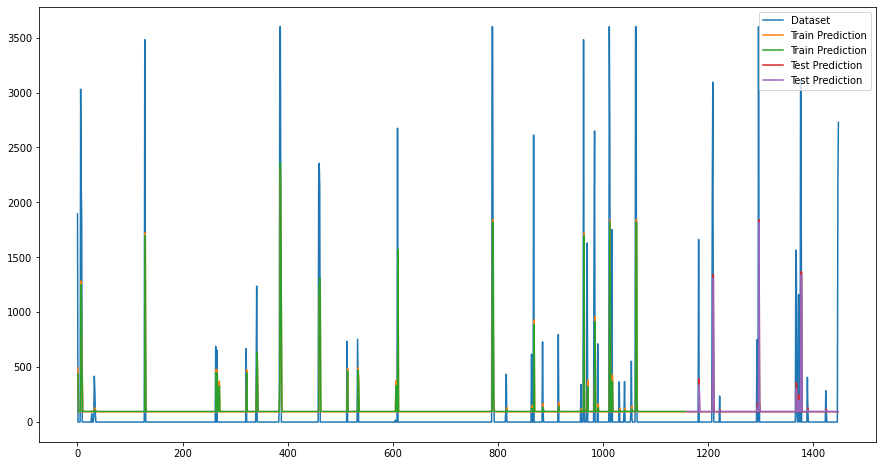

Epoch 1/100
1157/1157 - 2s - loss: 0.0065 - accuracy: 0.9455 - 2s/epoch - 2ms/step
Epoch 2/100
1157/1157 - 1s - loss: 0.0065 - accuracy: 0.9455 - 1s/epoch - 879us/step
Epoch 3/100
1157/1157 - 1s - loss: 0.0064 - accuracy: 0.9455 - 1s/epoch - 896us/step
Epoch 4/100
1157/1157 - 1s - loss: 0.0064 - accuracy: 0.9455 - 1s/epoch - 892us/step
Epoch 5/100
1157/1157 - 1s - loss: 0.0064 - accuracy: 0.9455 - 1s/epoch - 885us/step
Epoch 6/100
1157/1157 - 1s - loss: 0.0064 - accuracy: 0.9455 - 1s/epoch - 899us/step
Epoch 7/100
1157/1157 - 1s - loss: 0.0064 - accuracy: 0.9455 - 1s/epoch - 881us/step
Epoch 8/100
1157/1157 - 1s - loss: 0.0064 - accuracy: 0.9455 - 1s/epoch - 883us/step
Epoch 9/100
1157/1157 - 1s - loss: 0.0064 - accuracy: 0.9455 - 1s/epoch - 876us/step
Epoch 10/100
1157/1157 - 1s - loss: 0.0064 - accuracy: 0.9455 - 1s/epoch - 873us/step
Epoch 11/100
1157/1157 - 1s - loss: 0.0064 - accuracy: 0.9455 - 1s/epoch - 888us/step
Epoch 12/100
1157/1157 - 1s - loss: 0.0064 - accuracy: 0.9455 - 1

Epoch 97/100
1157/1157 - 1s - loss: 0.0064 - accuracy: 0.9455 - 1s/epoch - 892us/step
Epoch 98/100
1157/1157 - 1s - loss: 0.0064 - accuracy: 0.9455 - 1s/epoch - 877us/step
Epoch 99/100
1157/1157 - 1s - loss: 0.0064 - accuracy: 0.9455 - 1s/epoch - 890us/step
Epoch 100/100
1157/1157 - 1s - loss: 0.0064 - accuracy: 0.9455 - 1s/epoch - 931us/step
Train Score: 407.68 RMSE
Test Score: 460.17 RMSE


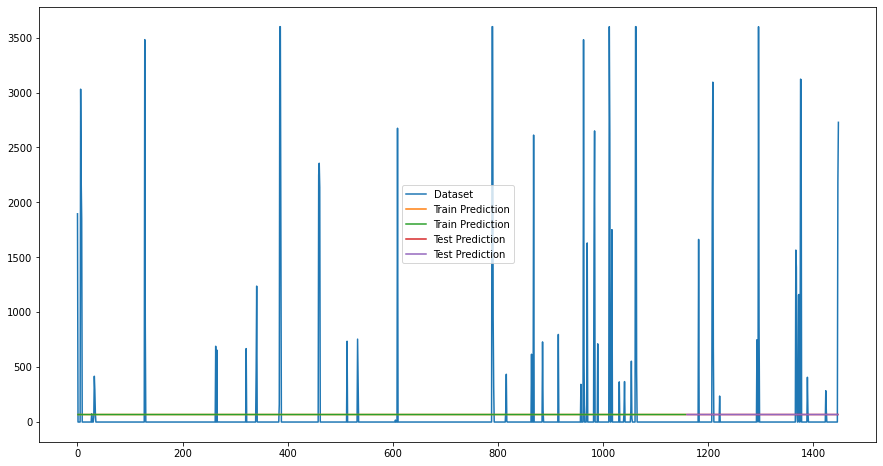

Epoch 1/100
1157/1157 - 2s - loss: 0.0061 - accuracy: 0.0294 - 2s/epoch - 2ms/step
Epoch 2/100
1157/1157 - 1s - loss: 0.0060 - accuracy: 0.0268 - 954ms/epoch - 824us/step
Epoch 3/100
1157/1157 - 1s - loss: 0.0060 - accuracy: 0.0268 - 946ms/epoch - 818us/step
Epoch 4/100
1157/1157 - 1s - loss: 0.0059 - accuracy: 0.0268 - 961ms/epoch - 831us/step
Epoch 5/100
1157/1157 - 1s - loss: 0.0059 - accuracy: 0.0268 - 965ms/epoch - 834us/step
Epoch 6/100
1157/1157 - 1s - loss: 0.0058 - accuracy: 0.0277 - 956ms/epoch - 826us/step
Epoch 7/100
1157/1157 - 1s - loss: 0.0058 - accuracy: 0.0268 - 955ms/epoch - 826us/step
Epoch 8/100
1157/1157 - 1s - loss: 0.0057 - accuracy: 0.0268 - 966ms/epoch - 835us/step
Epoch 9/100
1157/1157 - 1s - loss: 0.0057 - accuracy: 0.0277 - 945ms/epoch - 816us/step
Epoch 10/100
1157/1157 - 1s - loss: 0.0057 - accuracy: 0.0268 - 953ms/epoch - 823us/step
Epoch 11/100
1157/1157 - 1s - loss: 0.0056 - accuracy: 0.0268 - 953ms/epoch - 824us/step
Epoch 12/100
1157/1157 - 1s - loss:

Epoch 94/100
1157/1157 - 1s - loss: 0.0050 - accuracy: 0.0268 - 959ms/epoch - 829us/step
Epoch 95/100
1157/1157 - 1s - loss: 0.0050 - accuracy: 0.0268 - 950ms/epoch - 821us/step
Epoch 96/100
1157/1157 - 1s - loss: 0.0050 - accuracy: 0.0268 - 956ms/epoch - 826us/step
Epoch 97/100
1157/1157 - 1s - loss: 0.0050 - accuracy: 0.0268 - 957ms/epoch - 827us/step
Epoch 98/100
1157/1157 - 1s - loss: 0.0050 - accuracy: 0.0268 - 952ms/epoch - 823us/step
Epoch 99/100
1157/1157 - 1s - loss: 0.0050 - accuracy: 0.0268 - 966ms/epoch - 835us/step
Epoch 100/100
1157/1157 - 1s - loss: 0.0050 - accuracy: 0.0268 - 957ms/epoch - 827us/step
Train Score: 375.75 RMSE
Test Score: 430.71 RMSE


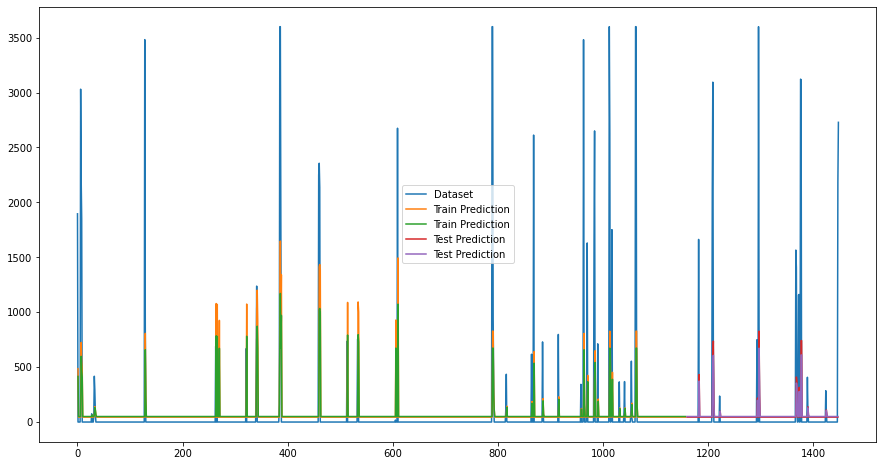

Epoch 1/100
1157/1157 - 2s - loss: 0.0054 - accuracy: 0.3060 - 2s/epoch - 2ms/step
Epoch 2/100
1157/1157 - 1s - loss: 0.0055 - accuracy: 0.3189 - 1s/epoch - 867us/step
Epoch 3/100
1157/1157 - 1s - loss: 0.0055 - accuracy: 0.3492 - 1s/epoch - 867us/step
Epoch 4/100
1157/1157 - 1s - loss: 0.0055 - accuracy: 0.3742 - 991ms/epoch - 856us/step
Epoch 5/100
1157/1157 - 1s - loss: 0.0054 - accuracy: 0.4356 - 1s/epoch - 868us/step
Epoch 6/100
1157/1157 - 1s - loss: 0.0054 - accuracy: 0.4417 - 993ms/epoch - 858us/step
Epoch 7/100
1157/1157 - 1s - loss: 0.0054 - accuracy: 0.4391 - 995ms/epoch - 860us/step
Epoch 8/100
1157/1157 - 1s - loss: 0.0055 - accuracy: 0.4373 - 993ms/epoch - 858us/step
Epoch 9/100
1157/1157 - 1s - loss: 0.0054 - accuracy: 0.4589 - 997ms/epoch - 862us/step
Epoch 10/100
1157/1157 - 1s - loss: 0.0054 - accuracy: 0.4719 - 1s/epoch - 867us/step
Epoch 11/100
1157/1157 - 1s - loss: 0.0054 - accuracy: 0.4633 - 1s/epoch - 866us/step
Epoch 12/100
1157/1157 - 1s - loss: 0.0054 - accur

Epoch 95/100
1157/1157 - 1s - loss: 0.0050 - accuracy: 0.5194 - 1s/epoch - 867us/step
Epoch 96/100
1157/1157 - 1s - loss: 0.0051 - accuracy: 0.5229 - 997ms/epoch - 862us/step
Epoch 97/100
1157/1157 - 1s - loss: 0.0051 - accuracy: 0.5022 - 1s/epoch - 870us/step
Epoch 98/100
1157/1157 - 1s - loss: 0.0051 - accuracy: 0.5350 - 992ms/epoch - 858us/step
Epoch 99/100
1157/1157 - 1s - loss: 0.0052 - accuracy: 0.5774 - 986ms/epoch - 852us/step
Epoch 100/100
1157/1157 - 1s - loss: 0.0051 - accuracy: 0.5765 - 1s/epoch - 866us/step
Train Score: 379.34 RMSE
Test Score: 431.49 RMSE


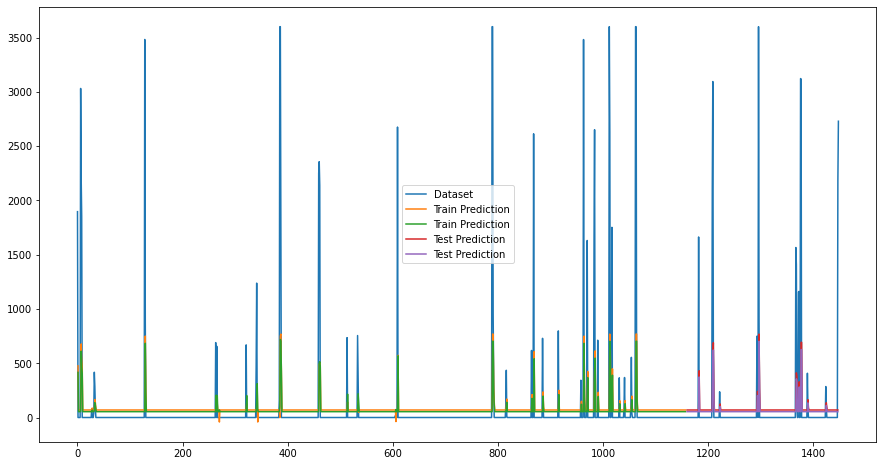

Epoch 1/100
1157/1157 - 2s - loss: 0.0058 - accuracy: 0.4391 - 2s/epoch - 2ms/step
Epoch 2/100
1157/1157 - 1s - loss: 0.0055 - accuracy: 0.2757 - 998ms/epoch - 863us/step
Epoch 3/100
1157/1157 - 1s - loss: 0.0052 - accuracy: 0.2913 - 994ms/epoch - 859us/step
Epoch 4/100
1157/1157 - 1s - loss: 0.0050 - accuracy: 0.3656 - 1s/epoch - 865us/step
Epoch 5/100
1157/1157 - 1s - loss: 0.0049 - accuracy: 0.3794 - 1s/epoch - 868us/step
Epoch 6/100
1157/1157 - 1s - loss: 0.0049 - accuracy: 0.3760 - 999ms/epoch - 863us/step
Epoch 7/100
1157/1157 - 1s - loss: 0.0049 - accuracy: 0.4149 - 999ms/epoch - 863us/step
Epoch 8/100
1157/1157 - 1s - loss: 0.0048 - accuracy: 0.3820 - 1s/epoch - 871us/step
Epoch 9/100
1157/1157 - 1s - loss: 0.0048 - accuracy: 0.4218 - 1s/epoch - 902us/step
Epoch 10/100
1157/1157 - 1s - loss: 0.0048 - accuracy: 0.3345 - 1s/epoch - 865us/step
Epoch 11/100
1157/1157 - 1s - loss: 0.0048 - accuracy: 0.4719 - 1s/epoch - 872us/step
Epoch 12/100
1157/1157 - 1s - loss: 0.0048 - accuracy

Epoch 94/100
1157/1157 - 1s - loss: 0.0046 - accuracy: 0.6283 - 1s/epoch - 868us/step
Epoch 95/100
1157/1157 - 1s - loss: 0.0046 - accuracy: 0.4728 - 981ms/epoch - 848us/step
Epoch 96/100
1157/1157 - 1s - loss: 0.0046 - accuracy: 0.4520 - 999ms/epoch - 864us/step
Epoch 97/100
1157/1157 - 1s - loss: 0.0046 - accuracy: 0.4978 - 999ms/epoch - 863us/step
Epoch 98/100
1157/1157 - 1s - loss: 0.0046 - accuracy: 0.5125 - 1s/epoch - 867us/step
Epoch 99/100
1157/1157 - 1s - loss: 0.0046 - accuracy: 0.5194 - 998ms/epoch - 863us/step
Epoch 100/100
1157/1157 - 1s - loss: 0.0046 - accuracy: 0.5333 - 999ms/epoch - 864us/step
Train Score: 357.88 RMSE
Test Score: 436.93 RMSE


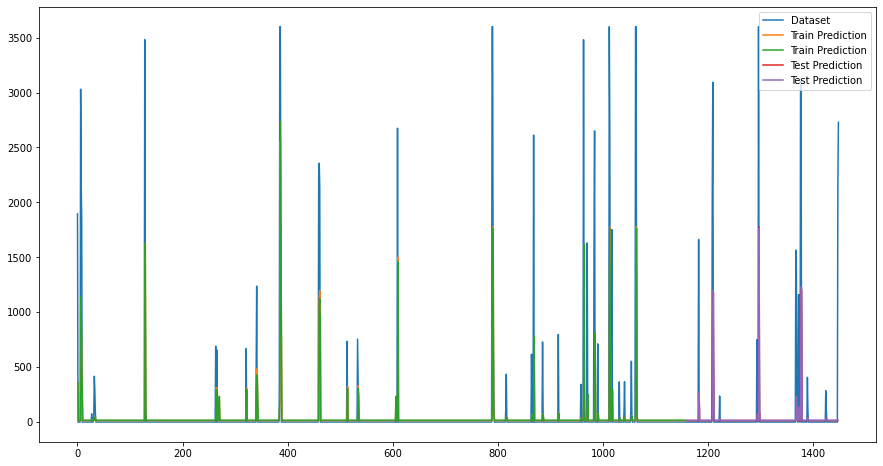

Epoch 1/100
1157/1157 - 2s - loss: 0.0054 - accuracy: 0.0061 - 2s/epoch - 2ms/step
Epoch 2/100
1157/1157 - 1s - loss: 0.0054 - accuracy: 0.0061 - 985ms/epoch - 851us/step
Epoch 3/100
1157/1157 - 1s - loss: 0.0054 - accuracy: 0.0061 - 983ms/epoch - 850us/step
Epoch 4/100
1157/1157 - 1s - loss: 0.0054 - accuracy: 0.0061 - 987ms/epoch - 853us/step
Epoch 5/100
1157/1157 - 1s - loss: 0.0054 - accuracy: 0.0061 - 991ms/epoch - 857us/step
Epoch 6/100
1157/1157 - 1s - loss: 0.0054 - accuracy: 0.0061 - 984ms/epoch - 851us/step
Epoch 7/100
1157/1157 - 1s - loss: 0.0054 - accuracy: 0.0061 - 989ms/epoch - 854us/step
Epoch 8/100
1157/1157 - 1s - loss: 0.0054 - accuracy: 0.0061 - 985ms/epoch - 852us/step
Epoch 9/100
1157/1157 - 1s - loss: 0.0054 - accuracy: 0.0061 - 985ms/epoch - 852us/step
Epoch 10/100
1157/1157 - 1s - loss: 0.0054 - accuracy: 0.0061 - 995ms/epoch - 860us/step
Epoch 11/100
1157/1157 - 1s - loss: 0.0054 - accuracy: 0.0061 - 984ms/epoch - 850us/step
Epoch 12/100
1157/1157 - 1s - loss:

Epoch 94/100
1157/1157 - 1s - loss: 0.0054 - accuracy: 0.0061 - 969ms/epoch - 837us/step
Epoch 95/100
1157/1157 - 1s - loss: 0.0054 - accuracy: 0.0061 - 969ms/epoch - 838us/step
Epoch 96/100
1157/1157 - 1s - loss: 0.0054 - accuracy: 0.0061 - 983ms/epoch - 850us/step
Epoch 97/100
1157/1157 - 1s - loss: 0.0054 - accuracy: 0.0061 - 979ms/epoch - 846us/step
Epoch 98/100
1157/1157 - 1s - loss: 0.0054 - accuracy: 0.0061 - 977ms/epoch - 844us/step
Epoch 99/100
1157/1157 - 1s - loss: 0.0054 - accuracy: 0.0061 - 1s/epoch - 879us/step
Epoch 100/100
1157/1157 - 1s - loss: 0.0054 - accuracy: 0.0061 - 1s/epoch - 877us/step
Train Score: 394.61 RMSE
Test Score: 454.39 RMSE


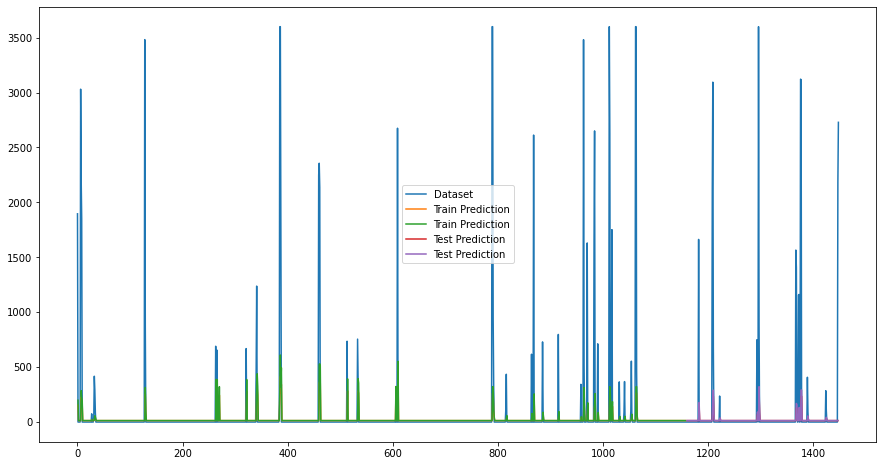

Epoch 1/100
1157/1157 - 2s - loss: 0.0056 - accuracy: 0.9378 - 2s/epoch - 2ms/step
Epoch 2/100
1157/1157 - 1s - loss: 0.0055 - accuracy: 0.9378 - 942ms/epoch - 814us/step
Epoch 3/100
1157/1157 - 1s - loss: 0.0055 - accuracy: 0.9421 - 957ms/epoch - 827us/step
Epoch 4/100
1157/1157 - 1s - loss: 0.0055 - accuracy: 0.9352 - 953ms/epoch - 824us/step
Epoch 5/100
1157/1157 - 1s - loss: 0.0055 - accuracy: 0.9343 - 946ms/epoch - 818us/step
Epoch 6/100
1157/1157 - 1s - loss: 0.0055 - accuracy: 0.9334 - 975ms/epoch - 843us/step
Epoch 7/100
1157/1157 - 1s - loss: 0.0055 - accuracy: 0.9343 - 971ms/epoch - 839us/step
Epoch 8/100
1157/1157 - 1s - loss: 0.0055 - accuracy: 0.9343 - 951ms/epoch - 822us/step
Epoch 9/100
1157/1157 - 1s - loss: 0.0055 - accuracy: 0.9343 - 952ms/epoch - 823us/step
Epoch 10/100
1157/1157 - 1s - loss: 0.0055 - accuracy: 0.9326 - 955ms/epoch - 826us/step
Epoch 11/100
1157/1157 - 1s - loss: 0.0055 - accuracy: 0.1469 - 963ms/epoch - 832us/step
Epoch 12/100
1157/1157 - 1s - loss:

Epoch 94/100
1157/1157 - 1s - loss: 0.0054 - accuracy: 0.0233 - 957ms/epoch - 827us/step
Epoch 95/100
1157/1157 - 1s - loss: 0.0054 - accuracy: 0.0233 - 956ms/epoch - 826us/step
Epoch 96/100
1157/1157 - 1s - loss: 0.0054 - accuracy: 0.0233 - 953ms/epoch - 823us/step
Epoch 97/100
1157/1157 - 1s - loss: 0.0054 - accuracy: 0.0233 - 966ms/epoch - 835us/step
Epoch 98/100
1157/1157 - 1s - loss: 0.0054 - accuracy: 0.0233 - 949ms/epoch - 820us/step
Epoch 99/100
1157/1157 - 1s - loss: 0.0054 - accuracy: 0.0233 - 955ms/epoch - 825us/step
Epoch 100/100
1157/1157 - 1s - loss: 0.0054 - accuracy: 0.0233 - 944ms/epoch - 816us/step
Train Score: 389.74 RMSE
Test Score: 449.47 RMSE


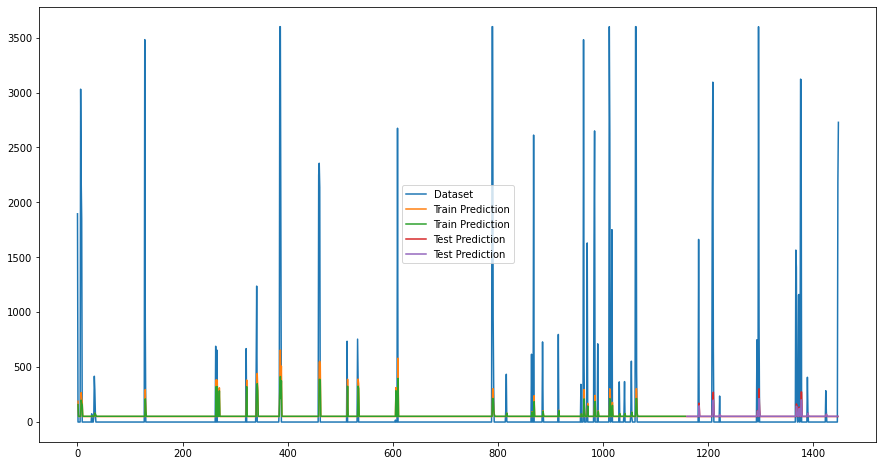

Epoch 1/100
1157/1157 - 2s - loss: 0.0058 - accuracy: 0.9222 - 2s/epoch - 2ms/step
Epoch 2/100
1157/1157 - 1s - loss: 0.0057 - accuracy: 0.9248 - 1s/epoch - 870us/step
Epoch 3/100
1157/1157 - 1s - loss: 0.0057 - accuracy: 0.9248 - 988ms/epoch - 854us/step
Epoch 4/100
1157/1157 - 1s - loss: 0.0057 - accuracy: 0.9248 - 1s/epoch - 870us/step
Epoch 5/100
1157/1157 - 1s - loss: 0.0056 - accuracy: 0.9239 - 982ms/epoch - 849us/step
Epoch 6/100
1157/1157 - 1s - loss: 0.0056 - accuracy: 0.9239 - 1s/epoch - 871us/step
Epoch 7/100
1157/1157 - 1s - loss: 0.0056 - accuracy: 0.9239 - 975ms/epoch - 842us/step
Epoch 8/100
1157/1157 - 1s - loss: 0.0055 - accuracy: 0.9170 - 972ms/epoch - 840us/step
Epoch 9/100
1157/1157 - 1s - loss: 0.0055 - accuracy: 0.9239 - 992ms/epoch - 858us/step
Epoch 10/100
1157/1157 - 1s - loss: 0.0055 - accuracy: 0.9239 - 991ms/epoch - 857us/step
Epoch 11/100
1157/1157 - 1s - loss: 0.0055 - accuracy: 0.9239 - 995ms/epoch - 860us/step
Epoch 12/100
1157/1157 - 1s - loss: 0.0054 -

Epoch 95/100
1157/1157 - 1s - loss: 0.0048 - accuracy: 0.9127 - 990ms/epoch - 856us/step
Epoch 96/100
1157/1157 - 1s - loss: 0.0048 - accuracy: 0.9231 - 983ms/epoch - 850us/step
Epoch 97/100
1157/1157 - 1s - loss: 0.0048 - accuracy: 0.8280 - 985ms/epoch - 851us/step
Epoch 98/100
1157/1157 - 1s - loss: 0.0048 - accuracy: 0.7727 - 994ms/epoch - 859us/step
Epoch 99/100
1157/1157 - 1s - loss: 0.0048 - accuracy: 0.8755 - 983ms/epoch - 849us/step
Epoch 100/100
1157/1157 - 1s - loss: 0.0048 - accuracy: 0.9136 - 1s/epoch - 911us/step
Train Score: 366.48 RMSE
Test Score: 424.95 RMSE


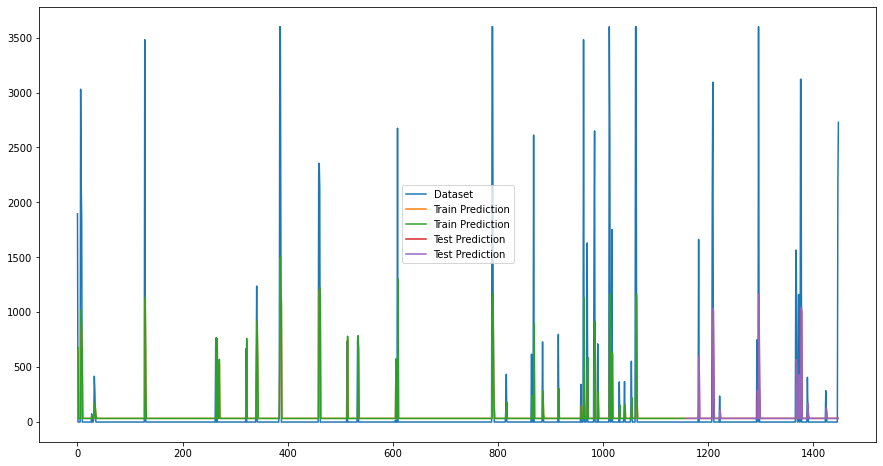

Epoch 1/100
1157/1157 - 2s - loss: 0.0055 - accuracy: 0.2662 - 2s/epoch - 2ms/step
Epoch 2/100
1157/1157 - 1s - loss: 0.0052 - accuracy: 0.1651 - 1s/epoch - 879us/step
Epoch 3/100
1157/1157 - 1s - loss: 0.0050 - accuracy: 0.1746 - 1s/epoch - 881us/step
Epoch 4/100
1157/1157 - 1s - loss: 0.0050 - accuracy: 0.2368 - 1s/epoch - 869us/step
Epoch 5/100
1157/1157 - 1s - loss: 0.0049 - accuracy: 0.2152 - 1s/epoch - 959us/step
Epoch 6/100
1157/1157 - 1s - loss: 0.0049 - accuracy: 0.2385 - 1s/epoch - 949us/step
Epoch 7/100
1157/1157 - 1s - loss: 0.0049 - accuracy: 0.3016 - 1s/epoch - 883us/step
Epoch 8/100
1157/1157 - 1s - loss: 0.0049 - accuracy: 0.4183 - 1s/epoch - 878us/step
Epoch 9/100
1157/1157 - 1s - loss: 0.0049 - accuracy: 0.2619 - 1s/epoch - 891us/step
Epoch 10/100
1157/1157 - 1s - loss: 0.0049 - accuracy: 0.2835 - 1s/epoch - 873us/step
Epoch 11/100
1157/1157 - 1s - loss: 0.0049 - accuracy: 0.2956 - 1s/epoch - 877us/step
Epoch 12/100
1157/1157 - 1s - loss: 0.0049 - accuracy: 0.4425 - 1

1157/1157 - 1s - loss: 0.0046 - accuracy: 0.3855 - 1s/epoch - 901us/step
Epoch 97/100
1157/1157 - 1s - loss: 0.0046 - accuracy: 0.3984 - 1s/epoch - 930us/step
Epoch 98/100
1157/1157 - 1s - loss: 0.0046 - accuracy: 0.3820 - 999ms/epoch - 863us/step
Epoch 99/100
1157/1157 - 1s - loss: 0.0046 - accuracy: 0.4114 - 1s/epoch - 884us/step
Epoch 100/100
1157/1157 - 1s - loss: 0.0046 - accuracy: 0.2653 - 1s/epoch - 870us/step
Train Score: 357.42 RMSE
Test Score: 432.16 RMSE


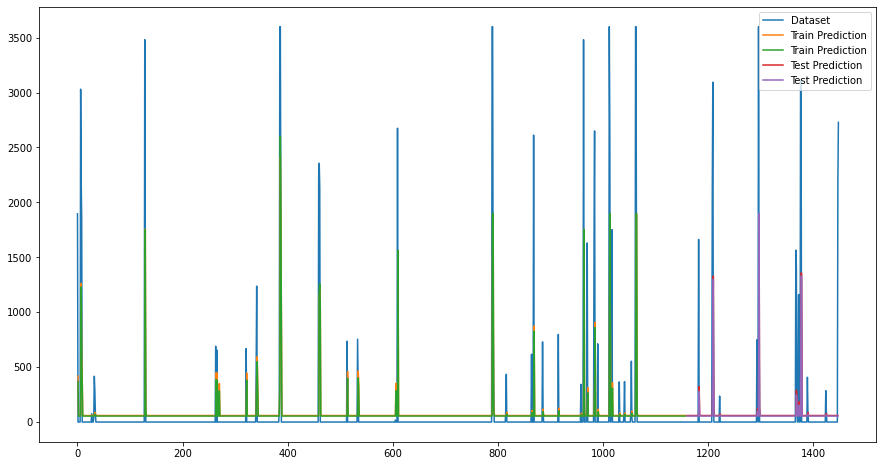

Epoch 1/100
1157/1157 - 2s - loss: 0.0059 - accuracy: 0.9455 - 2s/epoch - 2ms/step
Epoch 2/100
1157/1157 - 1s - loss: 0.0058 - accuracy: 0.9455 - 987ms/epoch - 853us/step
Epoch 3/100
1157/1157 - 1s - loss: 0.0058 - accuracy: 0.9455 - 991ms/epoch - 856us/step
Epoch 4/100
1157/1157 - 1s - loss: 0.0058 - accuracy: 0.9455 - 988ms/epoch - 854us/step
Epoch 5/100
1157/1157 - 1s - loss: 0.0058 - accuracy: 0.9455 - 994ms/epoch - 859us/step
Epoch 6/100
1157/1157 - 1s - loss: 0.0058 - accuracy: 0.9455 - 988ms/epoch - 854us/step
Epoch 7/100
1157/1157 - 1s - loss: 0.0058 - accuracy: 0.9455 - 998ms/epoch - 863us/step
Epoch 8/100
1157/1157 - 1s - loss: 0.0058 - accuracy: 0.9455 - 993ms/epoch - 858us/step
Epoch 9/100
1157/1157 - 1s - loss: 0.0058 - accuracy: 0.9455 - 1s/epoch - 864us/step
Epoch 10/100
1157/1157 - 1s - loss: 0.0058 - accuracy: 0.9455 - 992ms/epoch - 857us/step
Epoch 11/100
1157/1157 - 1s - loss: 0.0058 - accuracy: 0.9455 - 993ms/epoch - 858us/step
Epoch 12/100
1157/1157 - 1s - loss: 0.

Epoch 96/100
1157/1157 - 1s - loss: 0.0058 - accuracy: 0.9455 - 996ms/epoch - 860us/step
Epoch 97/100
1157/1157 - 1s - loss: 0.0058 - accuracy: 0.9455 - 988ms/epoch - 854us/step
Epoch 98/100
1157/1157 - 1s - loss: 0.0058 - accuracy: 0.9455 - 997ms/epoch - 862us/step
Epoch 99/100
1157/1157 - 1s - loss: 0.0058 - accuracy: 0.9455 - 995ms/epoch - 860us/step
Epoch 100/100
1157/1157 - 1s - loss: 0.0058 - accuracy: 0.9455 - 991ms/epoch - 857us/step
Train Score: 407.79 RMSE
Test Score: 460.87 RMSE


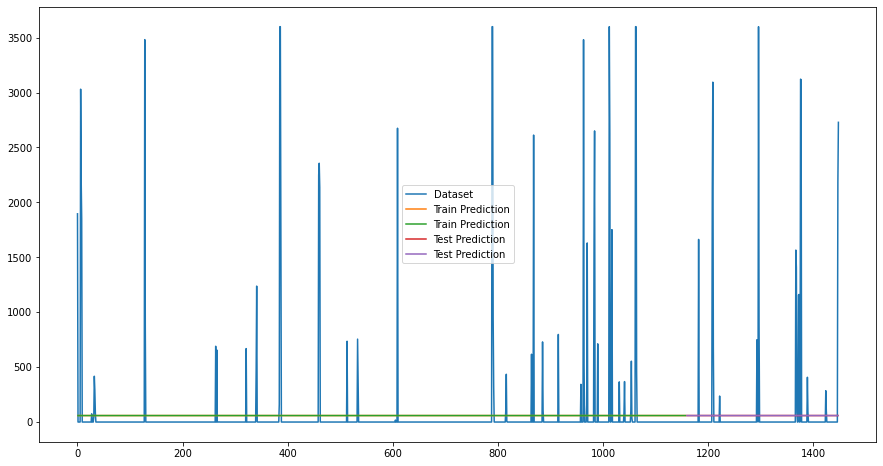

In [219]:
loss = ['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error',
       'mean_squared_logarithmic_error', 'cosine_similarity', 'huber', 'log_cosh']
optimizer = ['SGD', 'RMSprop', 'Adam', 'Adadelta', 'Adagrad', 'Adamax',
            'Nadam', 'Ftrl']

models = defaultdict(object)
testPredictions = defaultdict(object)
testYs = defaultdict(object)

for i in loss:
    for j in optimizer:
        models[(i, j)], testPredictions[(i, j)], testYs[(i, j)] = basic_LSTM(lookback = 3, num_inputs = 2, 
                                                                            density = 2, loss = i, optimizer = j)

In [260]:
for i in testPredictions:
    accuracy = calculate_accuracy(testPredictions[i][:, 1], testYs[i][0])
    print(f'{i}\t\taccuracy: {accuracy}')

('mean_squared_error', 'SGD')		accuracy: 0.03125
('mean_squared_error', 'RMSprop')		accuracy: 0.034722222222222224
('mean_squared_error', 'Adam')		accuracy: 0.0625
('mean_squared_error', 'Adadelta')		accuracy: 0.07291666666666667
('mean_squared_error', 'Adagrad')		accuracy: 0.05555555555555555
('mean_squared_error', 'Adamax')		accuracy: 0.03125
('mean_squared_error', 'Nadam')		accuracy: 0.03819444444444445
('mean_squared_error', 'Ftrl')		accuracy: 0.05555555555555555
('mean_absolute_error', 'SGD')		accuracy: 0.07291666666666667
('mean_absolute_error', 'RMSprop')		accuracy: 0.06944444444444445
('mean_absolute_error', 'Adam')		accuracy: 0.0625
('mean_absolute_error', 'Adadelta')		accuracy: 0.9652777777777778
('mean_absolute_error', 'Adagrad')		accuracy: 0.9791666666666666
('mean_absolute_error', 'Adamax')		accuracy: 0.07291666666666667
('mean_absolute_error', 'Nadam')		accuracy: 0.0625
('mean_absolute_error', 'Ftrl')		accuracy: 1.0
('mean_absolute_percentage_error', 'SGD')		accuracy: 0.0